# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

# Non shared resources
filename = 'hoasa-kmeans'
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['ac', 'air_panas', 'bau', 'general', 'kebersihan', 'linen', 'service', 'sunrise_meal', 'tv', 'wifi']
aspect_mapping = {'ac': 0, 'air_panas': 1, 'bau': 2, 'general': 3, 'kebersihan': 4, 'linen': 5, 'service': 6, 'sunrise_meal': 7, 'tv': 8, 'wifi': 9}
label_mapping = {"neg": 0, "neut": 1, 'neg_pos': 1, 'pos': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/hoasa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/hoasa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/hoasa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,review,ac,air_panas,bau,general,kebersihan,linen,service,sunrise_meal,tv,wifi
0,kebersihan kurang...,neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
1,"sangat mengecewakan... hotel bad image, kebers...",neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
2,Tempat nyaman bersih tapi tv terlalu tinggi ti...,neut,neut,neut,neut,pos,neut,neut,neut,neg,neut
3,"semuanya bagus sesuai profile,dan harga promo ...",neut,neg,neut,pos,neut,neut,neut,neut,neut,neut
4,"Tempat tidur sangat keras, bantal besar dan ke...",neg,neg,neut,neut,neut,neg,neut,neut,neut,neut


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [8]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['review'].values
y_train = train_data[train_labels].values
X_val = val_data['review'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2283,) (2283, 10)
(571,) (571, 10)


# BUILD DATASET & DATALOADERS

In [9]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=sequence_length, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

In [10]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [11]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [12]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [13]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# TRAIN THE MODEL

In [14]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 50

In [15]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [16]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }


In [17]:
def train_model(current_train_size, train_indices, aspect_metrics, sentiment_metrics, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    aspect_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    # Freeze the first few layers of the encoder
    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define optimizer and loss function
    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(current_X_train, current_y_train, X_val, y_val, sequence_length)

    # Prepare everything with Accelerator
    aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader
    )

    aspect_result = None
    start_time = time.time()

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(epochs):
        aspect_model.train()
        epoch_loss = 0

        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            None,
            aspect_list,
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'{filename}-aspect-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            aspect_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nAspect detection accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    best_aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{trials + 1}-model')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("--------------------------------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    sentiment_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=2e-5, weight_decay=0.01)

    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(epochs):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            [0, 1],
            ['negative', 'positive']
        )

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                 f'{filename}-sentiment-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    
    end_time = time.time()
    duration = end_time - start_time

    accelerator.print(f"\nSentiment analysis accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained( f'{filename}-sentiment-{trials + 1}-model')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    with torch.no_grad():
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
       
        
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])
        
    accelerator.print(f"Total train time: {duration} s")
    accelerator.end_training()
    return

# PLOT THE RESULTS

In [18]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [19]:
def kmeans_clustering_sampling(aspect_model, sentiment_model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    aspect_model.to(device)
    aspect_model.eval()
    sentiment_model.to(device)
    sentiment_model.eval()

    current_train_size = len(train_indices)
    aspect_dataset = AspectDetectionDataset(
        X_pool, 
        [['neut' for i in range(len(train_labels))] for x in range(len(X_pool))], 
        label_mapping, 
        tokenizer, 
        max_length=sequence_length
    )
    aspect_loader = DataLoader(
        aspect_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )
    
    aspect_outputs = {}
    sentiment_outputs = {}

    aspects = []
    data = []
    labels = []
    indices = []

    start_time = time.time()

    # Pass through aspect detction model
    for batch in aspect_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        
        with torch.no_grad():
            outputs = aspect_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids).logits
            embeddings = aspect_model.base_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        for i in range(len(outputs)):
            aspect_outputs[batch['ori_indices'][i].item()] = embeddings.last_hidden_state[i].mean(dim=1).cpu().numpy()
            
            for j in range(len(outputs[i])):
                if int(outputs[i][j].round()) != 1:
                    aspects.append(aspect_list[j])
                    data.append(batch['ori_text'][i])
                    labels.append(batch['ori_label'][i][j])
                    indices.append(batch['ori_indices'][i])

    if len(data) > 0:
        sentiment_dataset = SentimentAnalysisDataset(data, labels, aspects, indices, label_mapping, tokenizer, max_length=sequence_length)
        sentiment_loader = torch.utils.data.DataLoader(
            sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
        )
    
        # Pass through sentiment analysis model
        for batch in sentiment_loader:
            token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
    
            with torch.no_grad():
                outputs = sentiment_model.base_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    
            for i in range(len(outputs.last_hidden_state)):
                ori_index = batch['ori_indices'][i].item()
                if ori_index in sentiment_outputs.keys():
                    sentiment_outputs[ori_index].append(outputs.last_hidden_state[i].mean(dim=1).cpu().numpy())
                else:
                    sentiment_outputs[ori_index] = [outputs.last_hidden_state[i].mean(dim=1).cpu().numpy()]

    for key, val in sentiment_outputs.items():
        sentiment_outputs[key] = np.mean(val, axis=0)

    collected_indices = set()  # Initialize set to store selected indices
    thresholds = []

    if accelerator.is_main_process:
        aspect_outputs = dict(sorted(aspect_outputs.items()))

        if len(data) > 0:
            for key, val in sentiment_outputs.items():
                aspect_outputs[key] = np.mean([val, aspect_outputs[key]], axis=0)

        embeddings = np.array(list(aspect_outputs.values()))
        target_samples = len(embeddings[:math.ceil(0.1 * len(embeddings))])
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
                
        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size

        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'ac': [y_train[i][0] for i in temp],
                'air_panas': [y_train[i][1] for i in temp],
                'bau': [y_train[i][2] for i in temp],
                'general': [y_train[i][3] for i in temp],
                'kebersihan': [y_train[i][4] for i in temp],
                'linen': [y_train[i][5] for i in temp],
                'service': [y_train[i][6] for i in temp],
                'sunrise_meal': [y_train[i][7] for i in temp],
                'tv': [y_train[i][8] for i in temp],
                'wifi': [y_train[i][9] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(embeddings)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 90)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
                collected_indices.update(below_threshold_indices)

            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'ac': [y_train[i][0] for i in temp],
                    'air_panas': [y_train[i][1] for i in temp],
                    'bau': [y_train[i][2] for i in temp],
                    'general': [y_train[i][3] for i in temp],
                    'kebersihan': [y_train[i][4] for i in temp],
                    'linen': [y_train[i][5] for i in temp],
                    'service': [y_train[i][6] for i in temp],
                    'sunrise_meal': [y_train[i][7] for i in temp],
                    'tv': [y_train[i][8] for i in temp],
                    'wifi': [y_train[i][9] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

        threshold_data = pd.DataFrame({
            'Threshold': thresholds
        })
        threshold_data.to_csv(f"results/{filename}-thresholds-{trials+1}-{current_train_size}.csv", index=False)

# MAIN LOOP

In [20]:
def active_learning(seed, i):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (
            current_train_size, 
            train_indices, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            i,
            seed
        )
        notebook_launcher(train_model, args, num_processes=2)

        aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{i+1}-model')
        sentiment_model = BertForSequenceClassification.from_pretrained(f'{filename}-sentiment-{i+1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (
            aspect_model, 
            sentiment_model, 
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            sampling_dur, 
            new_samples, 
            i
        )
        notebook_launcher(kmeans_clustering_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (
        current_train_size, 
        train_indices, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        i,
        seed
    )
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    # print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [21]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5865, Accuracy: 0.7995, F1 Micro: 0.8876, F1 Macro: 0.8805
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4747, Accuracy: 0.801, F1 Micro: 0.8892, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4337, Accuracy: 0.8007, F1 Micro: 0.8893, F1 Macro: 0.8848
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.425, Accuracy: 0.8033, F1 Micro: 0.8905, F1 Macro: 0.8856
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4065, Accuracy: 0.8064, F1 Micro: 0.8916, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4121, Accuracy: 0.8101, F1 Micro: 0.8933, F1 Macro: 0.8874
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3857, Accuracy: 0.8177, F1 Micro: 0.8971, F1 Macro: 0.8914
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3725, Accuracy: 0.8321, F1 Micro: 0.9044, F1 Macro: 0.8994
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6014, Accuracy: 0.6293, F1 Micro: 0.6293, F1 Macro: 0.3862
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5503, Accuracy: 0.6293, F1 Micro: 0.6293, F1 Macro: 0.3862
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4934, Accuracy: 0.6293, F1 Micro: 0.6293, F1 Macro: 0.3862
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3898, Accuracy: 0.6878, F1 Micro: 0.6878, F1 Macro: 0.5444
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3441, Accuracy: 0.7488, F1 Micro: 0.7488, F1 Macro: 0.6959
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2311, Accuracy: 0.7634, F1 Micro: 0.7634, F1 Macro: 0.719
Epoch 7/10, Train Loss: 0.181, Accuracy: 0.7439, F1 Micro: 0.7439, F1 Macro: 0.6915
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2402, Accuracy: 0.7756, F1 Micro: 0.7756, F1 Macro: 0.7399
Epoch 9/10, Train Loss: 0.1526, Accuracy: 0.7512, F1 Micro: 0.7512, F1 Macro: 0.6996
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5414, Accuracy: 0.8007, F1 Micro: 0.8893, F1 Macro: 0.8848
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4635, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.446, Accuracy: 0.8186, F1 Micro: 0.8974, F1 Macro: 0.8914
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3999, Accuracy: 0.8415, F1 Micro: 0.9092, F1 Macro: 0.9054
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3563, Accuracy: 0.854, F1 Micro: 0.9157, F1 Macro: 0.912
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3118, Accuracy: 0.8682, F1 Micro: 0.923, F1 Macro: 0.9189
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2714, Accuracy: 0.8925, F1 Micro: 0.9365, F1 Macro: 0.9329
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2303, Accuracy: 0.9047, F1 Micro: 0.9428, F1 Macro: 0.9388
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5533, Accuracy: 0.7161, F1 Micro: 0.7161, F1 Macro: 0.4396
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4251, Accuracy: 0.8164, F1 Micro: 0.8164, F1 Macro: 0.728
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2899, Accuracy: 0.8438, F1 Micro: 0.8438, F1 Macro: 0.7899
Epoch 4/10, Train Loss: 0.2469, Accuracy: 0.8347, F1 Micro: 0.8347, F1 Macro: 0.7631
Epoch 5/10, Train Loss: 0.2308, Accuracy: 0.8415, F1 Micro: 0.8415, F1 Macro: 0.7745
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.183, Accuracy: 0.8597, F1 Micro: 0.8597, F1 Macro: 0.8126
Epoch 7/10, Train Loss: 0.1868, Accuracy: 0.8552, F1 Micro: 0.8552, F1 Macro: 0.8071
Epoch 8/10, Train Loss: 0.1362, Accuracy: 0.8518, F1 Micro: 0.8518, F1 Macro: 0.7991
Epoch 9/10, Train Loss: 0.1055, Accuracy: 0.8586, F1 Micro: 0.8586, F1 Macro: 0.8072
Epoch 10/10, Train Loss: 0.0788, Accuracy: 0.8586, F1 Micro: 0.8586, F1 Macro: 0.8072

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5144, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4619, Accuracy: 0.8054, F1 Micro: 0.8916, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4165, Accuracy: 0.8505, F1 Micro: 0.9136, F1 Macro: 0.9094
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3614, Accuracy: 0.8783, F1 Micro: 0.9287, F1 Macro: 0.9251
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3037, Accuracy: 0.9101, F1 Micro: 0.946, F1 Macro: 0.942
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2491, Accuracy: 0.9262, F1 Micro: 0.9551, F1 Macro: 0.9516
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2059, Accuracy: 0.9326, F1 Micro: 0.959, F1 Macro: 0.956
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1802, Accuracy: 0.9358, F1 Micro: 0.9608, F1 Macro: 0.9575
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5314, Accuracy: 0.7948, F1 Micro: 0.7948, F1 Macro: 0.6894
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3835, Accuracy: 0.7948, F1 Micro: 0.7948, F1 Macro: 0.6593
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2712, Accuracy: 0.8398, F1 Micro: 0.8398, F1 Macro: 0.7849
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.224, Accuracy: 0.8438, F1 Micro: 0.8438, F1 Macro: 0.7741
Epoch 5/10, Train Loss: 0.223, Accuracy: 0.8418, F1 Micro: 0.8418, F1 Macro: 0.7705
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1624, Accuracy: 0.8609, F1 Micro: 0.8609, F1 Macro: 0.804
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.092, Accuracy: 0.8789, F1 Micro: 0.8789, F1 Macro: 0.8409
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0846, Accuracy: 0.8789, F1 Micro: 0.8789, F1 Macro: 0.8339
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0768, Accuracy: 0.8839, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5019, Accuracy: 0.8017, F1 Micro: 0.8898, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4383, Accuracy: 0.8318, F1 Micro: 0.9047, F1 Macro: 0.9004
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3783, Accuracy: 0.87, F1 Micro: 0.924, F1 Macro: 0.9203
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2969, Accuracy: 0.9141, F1 Micro: 0.9484, F1 Macro: 0.9455
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2415, Accuracy: 0.9262, F1 Micro: 0.9554, F1 Macro: 0.9521
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2007, Accuracy: 0.933, F1 Micro: 0.9593, F1 Macro: 0.9562
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1738, Accuracy: 0.9399, F1 Micro: 0.9633, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1524, Accuracy: 0.9424, F1 Micro: 0.9647, F1 Macro: 0.9616
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5262, Accuracy: 0.8177, F1 Micro: 0.8177, F1 Macro: 0.7764
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3188, Accuracy: 0.8322, F1 Micro: 0.8322, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2651, Accuracy: 0.8602, F1 Micro: 0.8602, F1 Macro: 0.8236
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.24, Accuracy: 0.8785, F1 Micro: 0.8785, F1 Macro: 0.8415
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1872, Accuracy: 0.8901, F1 Micro: 0.8901, F1 Macro: 0.8569
Epoch 6/10, Train Loss: 0.1025, Accuracy: 0.8804, F1 Micro: 0.8804, F1 Macro: 0.8425
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0837, Accuracy: 0.893, F1 Micro: 0.893, F1 Macro: 0.8619
Epoch 8/10, Train Loss: 0.0619, Accuracy: 0.8862, F1 Micro: 0.8862, F1 Macro: 0.8563
Epoch 9/10, Train Loss: 0.0571, Accuracy: 0.8881, F1 Micro: 0.8881, F1 Macro: 0.8526
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4985, Accuracy: 0.8156, F1 Micro: 0.8947, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4297, Accuracy: 0.8444, F1 Micro: 0.9093, F1 Macro: 0.901
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3476, Accuracy: 0.896, F1 Micro: 0.9383, F1 Macro: 0.9354
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2746, Accuracy: 0.9222, F1 Micro: 0.953, F1 Macro: 0.9494
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2246, Accuracy: 0.9398, F1 Micro: 0.9632, F1 Macro: 0.9599
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1877, Accuracy: 0.9422, F1 Micro: 0.9646, F1 Macro: 0.9615
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1586, Accuracy: 0.9467, F1 Micro: 0.9673, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1368, Accuracy: 0.9479, F1 Micro: 0.9681, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5026, Accuracy: 0.83, F1 Micro: 0.83, F1 Macro: 0.785
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3006, Accuracy: 0.852, F1 Micro: 0.852, F1 Macro: 0.8068
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2296, Accuracy: 0.8672, F1 Micro: 0.8672, F1 Macro: 0.8201
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1765, Accuracy: 0.8739, F1 Micro: 0.8739, F1 Macro: 0.8298
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1246, Accuracy: 0.8892, F1 Micro: 0.8892, F1 Macro: 0.8549
Epoch 6/10, Train Loss: 0.0977, Accuracy: 0.873, F1 Micro: 0.873, F1 Macro: 0.8269
Epoch 7/10, Train Loss: 0.0976, Accuracy: 0.8883, F1 Micro: 0.8883, F1 Macro: 0.8517
Epoch 8/10, Train Loss: 0.0535, Accuracy: 0.8797, F1 Micro: 0.8797, F1 Macro: 0.8371
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0469, Accuracy: 0.8902, F1 Micro: 0.8902, F1 Macro: 0.86
Epoch 10/10, Train Loss: 0.0239, Accuracy: 0.889

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4993, Accuracy: 0.8123, F1 Micro: 0.8949, F1 Macro: 0.8901
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4174, Accuracy: 0.8646, F1 Micro: 0.9211, F1 Macro: 0.9169
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3155, Accuracy: 0.9181, F1 Micro: 0.9506, F1 Macro: 0.9472
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2413, Accuracy: 0.9349, F1 Micro: 0.9603, F1 Macro: 0.9574
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2049, Accuracy: 0.9385, F1 Micro: 0.9626, F1 Macro: 0.9599
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1703, Accuracy: 0.947, F1 Micro: 0.9675, F1 Macro: 0.9645
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1459, Accuracy: 0.954, F1 Micro: 0.9716, F1 Macro: 0.9687
Epoch 8/10, Train Loss: 0.1283, Accuracy: 0.9538, F1 Micro: 0.9715, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1108, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.459, Accuracy: 0.8465, F1 Micro: 0.8465, F1 Macro: 0.7789
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3145, Accuracy: 0.8591, F1 Micro: 0.8591, F1 Macro: 0.8256
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2478, Accuracy: 0.8958, F1 Micro: 0.8958, F1 Macro: 0.8617
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1736, Accuracy: 0.8986, F1 Micro: 0.8986, F1 Macro: 0.8684
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1267, Accuracy: 0.9035, F1 Micro: 0.9035, F1 Macro: 0.8713
Epoch 6/10, Train Loss: 0.0772, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8658
Epoch 7/10, Train Loss: 0.0695, Accuracy: 0.9025, F1 Micro: 0.9025, F1 Macro: 0.8715
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0514, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.8872
Epoch 9/10, Train Loss: 0.0455, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8812
Epoch 10/10, Train Loss: 0.0347, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4933, Accuracy: 0.8076, F1 Micro: 0.8927, F1 Macro: 0.8881
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.397, Accuracy: 0.8821, F1 Micro: 0.9305, F1 Macro: 0.9268
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3, Accuracy: 0.9259, F1 Micro: 0.9552, F1 Macro: 0.9525
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2278, Accuracy: 0.9453, F1 Micro: 0.9665, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1822, Accuracy: 0.9472, F1 Micro: 0.9677, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1532, Accuracy: 0.9486, F1 Micro: 0.9686, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1364, Accuracy: 0.9571, F1 Micro: 0.9734, F1 Macro: 0.9703
Epoch 8/10, Train Loss: 0.1197, Accuracy: 0.955, F1 Micro: 0.9723, F1 Macro: 0.9692
Epoch 9/10, Train Loss: 0.1006, Accuracy: 0.9521, F1 Micro: 0.9705, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4797, Accuracy: 0.8347, F1 Micro: 0.8347, F1 Macro: 0.7701
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3116, Accuracy: 0.8627, F1 Micro: 0.8627, F1 Macro: 0.8187
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2433, Accuracy: 0.8861, F1 Micro: 0.8861, F1 Macro: 0.8532
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1691, Accuracy: 0.8926, F1 Micro: 0.8926, F1 Macro: 0.8624
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1308, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0874, Accuracy: 0.9029, F1 Micro: 0.9029, F1 Macro: 0.8748
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0673, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.875
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.066, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8781
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4829, Accuracy: 0.8217, F1 Micro: 0.8996, F1 Macro: 0.895
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3823, Accuracy: 0.8905, F1 Micro: 0.9353, F1 Macro: 0.9318
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2724, Accuracy: 0.9304, F1 Micro: 0.9579, F1 Macro: 0.9554
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2046, Accuracy: 0.9488, F1 Micro: 0.9686, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1716, Accuracy: 0.9498, F1 Micro: 0.9693, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1404, Accuracy: 0.9563, F1 Micro: 0.9729, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1236, Accuracy: 0.958, F1 Micro: 0.974, F1 Macro: 0.9709
Epoch 8/10, Train Loss: 0.1052, Accuracy: 0.9569, F1 Micro: 0.9734, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0892, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4413, Accuracy: 0.8465, F1 Micro: 0.8465, F1 Macro: 0.7993
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2902, Accuracy: 0.8674, F1 Micro: 0.8674, F1 Macro: 0.8288
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2153, Accuracy: 0.8801, F1 Micro: 0.8801, F1 Macro: 0.8423
Epoch 4/10, Train Loss: 0.1561, Accuracy: 0.8774, F1 Micro: 0.8774, F1 Macro: 0.837
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1019, Accuracy: 0.8955, F1 Micro: 0.8955, F1 Macro: 0.8673
Epoch 6/10, Train Loss: 0.0768, Accuracy: 0.891, F1 Micro: 0.891, F1 Macro: 0.8617
Epoch 7/10, Train Loss: 0.0774, Accuracy: 0.8928, F1 Micro: 0.8928, F1 Macro: 0.8637
Epoch 8/10, Train Loss: 0.0589, Accuracy: 0.8874, F1 Micro: 0.8874, F1 Macro: 0.8529
Epoch 9/10, Train Loss: 0.035, Accuracy: 0.8919, F1 Micro: 0.8919, F1 Macro: 0.8596
Epoch 10/10, Train Loss: 0.0341, Accuracy: 0.8892, F1 Micro: 0.8892, F1 Macro: 0.8578

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4917, Accuracy: 0.8373, F1 Micro: 0.9071, F1 Macro: 0.9025
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3694, Accuracy: 0.905, F1 Micro: 0.9433, F1 Macro: 0.9398
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2574, Accuracy: 0.934, F1 Micro: 0.9598, F1 Macro: 0.9572
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2009, Accuracy: 0.9474, F1 Micro: 0.9678, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1676, Accuracy: 0.9497, F1 Micro: 0.9691, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1368, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.972
Epoch 7/10, Train Loss: 0.1198, Accuracy: 0.9569, F1 Micro: 0.9735, F1 Macro: 0.9707
Epoch 8/10, Train Loss: 0.1013, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0832, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4282, Accuracy: 0.8383, F1 Micro: 0.8383, F1 Macro: 0.772
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2829, Accuracy: 0.8776, F1 Micro: 0.8776, F1 Macro: 0.8403
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2151, Accuracy: 0.8888, F1 Micro: 0.8888, F1 Macro: 0.8539
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1373, Accuracy: 0.8972, F1 Micro: 0.8972, F1 Macro: 0.866
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.107, Accuracy: 0.9037, F1 Micro: 0.9037, F1 Macro: 0.8762
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0753, Accuracy: 0.9047, F1 Micro: 0.9047, F1 Macro: 0.8778
Epoch 7/10, Train Loss: 0.068, Accuracy: 0.8953, F1 Micro: 0.8953, F1 Macro: 0.8684
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0476, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8799
Epoch 9/10, Train Loss: 0.033, Accuracy: 0.8972, F1 Micro: 0.8972, F1 Macro: 0.8657
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4882, Accuracy: 0.8358, F1 Micro: 0.9058, F1 Macro: 0.9002
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3571, Accuracy: 0.9123, F1 Micro: 0.9474, F1 Macro: 0.9443
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2453, Accuracy: 0.9378, F1 Micro: 0.9621, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1974, Accuracy: 0.947, F1 Micro: 0.9675, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.169, Accuracy: 0.9521, F1 Micro: 0.9705, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1356, Accuracy: 0.9549, F1 Micro: 0.9722, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1162, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9745
Epoch 8/10, Train Loss: 0.1038, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.9704
Epoch 9/10, Train Loss: 0.0868, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4266, Accuracy: 0.8574, F1 Micro: 0.8574, F1 Macro: 0.8144
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2543, Accuracy: 0.8861, F1 Micro: 0.8861, F1 Macro: 0.8573
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1773, Accuracy: 0.9046, F1 Micro: 0.9046, F1 Macro: 0.8768
Epoch 4/10, Train Loss: 0.1297, Accuracy: 0.8991, F1 Micro: 0.8991, F1 Macro: 0.8697
Epoch 5/10, Train Loss: 0.1, Accuracy: 0.8972, F1 Micro: 0.8972, F1 Macro: 0.867
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0749, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macro: 0.8785
Epoch 7/10, Train Loss: 0.0595, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.8747
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0423, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macro: 0.8787
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.8816
Epoch 10/10, Train Loss: 0.0264, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4775, Accuracy: 0.8377, F1 Micro: 0.9065, F1 Macro: 0.9005
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3389, Accuracy: 0.9186, F1 Micro: 0.951, F1 Macro: 0.9481
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2385, Accuracy: 0.9394, F1 Micro: 0.963, F1 Macro: 0.9608
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1894, Accuracy: 0.951, F1 Micro: 0.9699, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.155, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1329, Accuracy: 0.9559, F1 Micro: 0.9728, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1134, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0936, Accuracy: 0.9611, F1 Micro: 0.9758, F1 Macro: 0.9731
Epoch 9/10, Train Loss: 0.0806, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4229, Accuracy: 0.8501, F1 Micro: 0.8501, F1 Macro: 0.8037
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2571, Accuracy: 0.8839, F1 Micro: 0.8839, F1 Macro: 0.8543
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.21, Accuracy: 0.8876, F1 Micro: 0.8876, F1 Macro: 0.8614
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1414, Accuracy: 0.8921, F1 Micro: 0.8921, F1 Macro: 0.86
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0912, Accuracy: 0.8967, F1 Micro: 0.8967, F1 Macro: 0.867
Epoch 6/10, Train Loss: 0.0736, Accuracy: 0.8867, F1 Micro: 0.8867, F1 Macro: 0.8494
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0769, Accuracy: 0.8976, F1 Micro: 0.8976, F1 Macro: 0.8695
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.056, Accuracy: 0.8995, F1 Micro: 0.8995, F1 Macro: 0.8701
Epoch 9/10, Train Loss: 0.031, Accuracy: 0.8985, F1 Micro: 0.8985, F1 Macro: 0.8708
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4727, Accuracy: 0.8474, F1 Micro: 0.9121, F1 Macro: 0.9082
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3278, Accuracy: 0.9219, F1 Micro: 0.953, F1 Macro: 0.9509
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2368, Accuracy: 0.9425, F1 Micro: 0.9648, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1841, Accuracy: 0.9503, F1 Micro: 0.9695, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1552, Accuracy: 0.9512, F1 Micro: 0.97, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1296, Accuracy: 0.9569, F1 Micro: 0.9734, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1062, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0908, Accuracy: 0.9618, F1 Micro: 0.9762, F1 Macro: 0.973
Epoch 9/10, Train Loss: 0.08, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4074, Accuracy: 0.8555, F1 Micro: 0.8555, F1 Macro: 0.8146
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2669, Accuracy: 0.8761, F1 Micro: 0.8761, F1 Macro: 0.8409
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.187, Accuracy: 0.8851, F1 Micro: 0.8851, F1 Macro: 0.8518
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1411, Accuracy: 0.895, F1 Micro: 0.895, F1 Macro: 0.8659
Epoch 5/10, Train Loss: 0.1046, Accuracy: 0.8932, F1 Micro: 0.8932, F1 Macro: 0.8633
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0783, Accuracy: 0.8995, F1 Micro: 0.8995, F1 Macro: 0.8712
Epoch 7/10, Train Loss: 0.0523, Accuracy: 0.8977, F1 Micro: 0.8977, F1 Macro: 0.8705
Epoch 8/10, Train Loss: 0.0468, Accuracy: 0.8977, F1 Micro: 0.8977, F1 Macro: 0.8689
Epoch 9/10, Train Loss: 0.0383, Accuracy: 0.8932, F1 Micro: 0.8932, F1 Macro: 0.8664
Epoch 10/10, Train Loss: 0.0323, Accuracy: 0.8896, F1 Micro: 0.8896, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.471, Accuracy: 0.8538, F1 Micro: 0.9157, F1 Macro: 0.9119
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3256, Accuracy: 0.9274, F1 Micro: 0.9561, F1 Macro: 0.9536
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.223, Accuracy: 0.9396, F1 Micro: 0.9632, F1 Macro: 0.961
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1808, Accuracy: 0.9552, F1 Micro: 0.9724, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1519, Accuracy: 0.9576, F1 Micro: 0.9738, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1262, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1014, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0892, Accuracy: 0.9613, F1 Micro: 0.9761, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3866, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.8028
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2369, Accuracy: 0.8942, F1 Micro: 0.8942, F1 Macro: 0.8664
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1602, Accuracy: 0.9017, F1 Micro: 0.9017, F1 Macro: 0.8703
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1203, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.8881
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0906, Accuracy: 0.9156, F1 Micro: 0.9156, F1 Macro: 0.8914
Epoch 6/10, Train Loss: 0.0638, Accuracy: 0.9054, F1 Micro: 0.9054, F1 Macro: 0.88
Epoch 7/10, Train Loss: 0.0583, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.8885
Epoch 8/10, Train Loss: 0.0344, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.8834
Epoch 9/10, Train Loss: 0.0368, Accuracy: 0.91, F1 Micro: 0.91, F1 Macro: 0.8834
Epoch 10/10, Train Loss: 0.0292, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4607, Accuracy: 0.8509, F1 Micro: 0.9141, F1 Macro: 0.9102
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.312, Accuracy: 0.929, F1 Micro: 0.9568, F1 Macro: 0.9537
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2192, Accuracy: 0.9429, F1 Micro: 0.9651, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1788, Accuracy: 0.9521, F1 Micro: 0.9706, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1424, Accuracy: 0.9568, F1 Micro: 0.9734, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1201, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.098, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9748
Epoch 8/10, Train Loss: 0.085, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9734
Epoch 9/10, Train Loss: 0.072, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3705, Accuracy: 0.8657, F1 Micro: 0.8657, F1 Macro: 0.8203
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2497, Accuracy: 0.8991, F1 Micro: 0.8991, F1 Macro: 0.8688
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1802, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.8808
Epoch 4/10, Train Loss: 0.1272, Accuracy: 0.9009, F1 Micro: 0.9009, F1 Macro: 0.869
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0874, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8838
Epoch 6/10, Train Loss: 0.0865, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8791
Epoch 7/10, Train Loss: 0.0641, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.8774
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0462, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0323, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.8923
Epoch 10/10, Train Loss: 0.0218, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4571, Accuracy: 0.8599, F1 Micro: 0.9189, F1 Macro: 0.9154
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3001, Accuracy: 0.9335, F1 Micro: 0.9596, F1 Macro: 0.9574
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2114, Accuracy: 0.942, F1 Micro: 0.9646, F1 Macro: 0.9623
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1672, Accuracy: 0.9545, F1 Micro: 0.972, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1387, Accuracy: 0.9571, F1 Micro: 0.9736, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1175, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9733
Epoch 7/10, Train Loss: 0.0983, Accuracy: 0.9597, F1 Micro: 0.9752, F1 Macro: 0.9729
Epoch 8/10, Train Loss: 0.0821, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0707, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3895, Accuracy: 0.8623, F1 Micro: 0.8623, F1 Macro: 0.8077
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.225, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8781
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1598, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8805
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1297, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.8887
Epoch 5/10, Train Loss: 0.0787, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8747
Epoch 6/10, Train Loss: 0.0681, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8796
Epoch 7/10, Train Loss: 0.0443, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.8878
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.039, Accuracy: 0.9181, F1 Micro: 0.9181, F1 Macro: 0.8917
Epoch 9/10, Train Loss: 0.0255, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0307, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4595, Accuracy: 0.8609, F1 Micro: 0.9193, F1 Macro: 0.9156
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3017, Accuracy: 0.9243, F1 Micro: 0.9539, F1 Macro: 0.95
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.218, Accuracy: 0.945, F1 Micro: 0.9664, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1767, Accuracy: 0.9542, F1 Micro: 0.9718, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1428, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1166, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9746
Epoch 7/10, Train Loss: 0.1004, Accuracy: 0.9602, F1 Micro: 0.9753, F1 Macro: 0.9727
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0695, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3701, Accuracy: 0.8723, F1 Micro: 0.8723, F1 Macro: 0.8266
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.218, Accuracy: 0.9001, F1 Micro: 0.9001, F1 Macro: 0.8702
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1541, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.88
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1059, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8816
Epoch 5/10, Train Loss: 0.0886, Accuracy: 0.9029, F1 Micro: 0.9029, F1 Macro: 0.8689
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0709, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8801
Epoch 7/10, Train Loss: 0.054, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.88
Epoch 8/10, Train Loss: 0.0303, Accuracy: 0.9066, F1 Micro: 0.9066, F1 Macro: 0.8736
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0226, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.884
Higher F1 achieved, saving model
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4558, Accuracy: 0.8679, F1 Micro: 0.9222, F1 Macro: 0.9156
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2865, Accuracy: 0.9342, F1 Micro: 0.9599, F1 Macro: 0.9577
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2079, Accuracy: 0.9474, F1 Micro: 0.9678, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1674, Accuracy: 0.9509, F1 Micro: 0.9699, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1423, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1141, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9746
Epoch 7/10, Train Loss: 0.0967, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0818, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 0.9758
Epoch 9/10, Train Loss: 0.0681, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3745, Accuracy: 0.8603, F1 Micro: 0.8603, F1 Macro: 0.8059
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2424, Accuracy: 0.8925, F1 Micro: 0.8925, F1 Macro: 0.8669
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1441, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8819
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1133, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.8808
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0902, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.8885
Epoch 6/10, Train Loss: 0.0582, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8856
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0369, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.8909
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0433, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.8919
Epoch 9/10, Train Loss: 0.035, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.883
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4484, Accuracy: 0.8731, F1 Micro: 0.9257, F1 Macro: 0.9216
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2846, Accuracy: 0.9377, F1 Micro: 0.9619, F1 Macro: 0.9595
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2043, Accuracy: 0.9477, F1 Micro: 0.968, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1582, Accuracy: 0.9582, F1 Micro: 0.9742, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1304, Accuracy: 0.9583, F1 Micro: 0.9742, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1096, Accuracy: 0.9606, F1 Micro: 0.9755, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0919, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.974
Epoch 8/10, Train Loss: 0.0795, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0646, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3681, Accuracy: 0.8561, F1 Micro: 0.8561, F1 Macro: 0.8029
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2214, Accuracy: 0.8796, F1 Micro: 0.8796, F1 Macro: 0.8388
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1489, Accuracy: 0.8959, F1 Micro: 0.8959, F1 Macro: 0.8654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1085, Accuracy: 0.9014, F1 Micro: 0.9014, F1 Macro: 0.8733
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0843, Accuracy: 0.9014, F1 Micro: 0.9014, F1 Macro: 0.8736
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0743, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.8816
Epoch 7/10, Train Loss: 0.0507, Accuracy: 0.9032, F1 Micro: 0.9032, F1 Macro: 0.8772
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0405, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.8805
Epoch 9/10, Train Loss: 0.0351, Accuracy: 0.9032, F1 Micro: 0.9032, F1 Macro: 0.8762
High

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4592, Accuracy: 0.8734, F1 Micro: 0.9257, F1 Macro: 0.9212
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2865, Accuracy: 0.9351, F1 Micro: 0.9605, F1 Macro: 0.9584
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2028, Accuracy: 0.9488, F1 Micro: 0.9686, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1599, Accuracy: 0.9542, F1 Micro: 0.9718, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1261, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1097, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.093, Accuracy: 0.9648, F1 Micro: 0.9782, F1 Macro: 0.9761
Epoch 8/10, Train Loss: 0.078, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.065, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3863, Accuracy: 0.8719, F1 Micro: 0.8719, F1 Macro: 0.8298
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2055, Accuracy: 0.8819, F1 Micro: 0.8819, F1 Macro: 0.8401
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1425, Accuracy: 0.911, F1 Micro: 0.911, F1 Macro: 0.8863
Epoch 4/10, Train Loss: 0.0997, Accuracy: 0.9019, F1 Micro: 0.9019, F1 Macro: 0.8725
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0766, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.8869
Epoch 6/10, Train Loss: 0.0515, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.8814
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0398, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.8866
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0226, Accuracy: 0.9146, F1 Micro: 0.9146, F1 Macro: 0.8897
Epoch 9/10, Train Loss: 0.0212, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8864
Epoch 10/10, Train Loss: 0.0284, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4441, Accuracy: 0.8719, F1 Micro: 0.9249, F1 Macro: 0.9208
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2818, Accuracy: 0.9365, F1 Micro: 0.9612, F1 Macro: 0.9589
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1965, Accuracy: 0.947, F1 Micro: 0.9677, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1605, Accuracy: 0.9554, F1 Micro: 0.9725, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1296, Accuracy: 0.9608, F1 Micro: 0.9758, F1 Macro: 0.9734
Epoch 6/10, Train Loss: 0.1115, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0916, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0753, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0659, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3695, Accuracy: 0.8574, F1 Micro: 0.8574, F1 Macro: 0.8115
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2259, Accuracy: 0.8915, F1 Micro: 0.8915, F1 Macro: 0.8607
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1433, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8728
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.111, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8766
Epoch 5/10, Train Loss: 0.0903, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8741
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0781, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.8824
Epoch 7/10, Train Loss: 0.0358, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.8822
Epoch 8/10, Train Loss: 0.0388, Accuracy: 0.9049, F1 Micro: 0.9049, F1 Macro: 0.8789
Epoch 9/10, Train Loss: 0.0273, Accuracy: 0.8969, F1 Micro: 0.8969, F1 Macro: 0.8688
Epoch 10/10, Train Loss: 0.0198, Accuracy: 0.9004, F1 Micro: 0.9004, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4397, Accuracy: 0.8753, F1 Micro: 0.9266, F1 Macro: 0.9221
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2777, Accuracy: 0.9365, F1 Micro: 0.9614, F1 Macro: 0.9592
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1996, Accuracy: 0.9514, F1 Micro: 0.9702, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1524, Accuracy: 0.9576, F1 Micro: 0.9737, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1301, Accuracy: 0.9601, F1 Micro: 0.9754, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1018, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0877, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0758, Accuracy: 0.9658, F1 Micro: 0.9788, F1 Macro: 0.9767
Epoch 9/10, Train Loss: 0.0611, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3559, Accuracy: 0.8861, F1 Micro: 0.8861, F1 Macro: 0.8511
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2155, Accuracy: 0.8982, F1 Micro: 0.8982, F1 Macro: 0.8668
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1268, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.8949
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.093, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9009
Epoch 5/10, Train Loss: 0.0699, Accuracy: 0.9206, F1 Micro: 0.9206, F1 Macro: 0.8971
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0579, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.8997
Epoch 7/10, Train Loss: 0.0411, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.8949
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.029, Accuracy: 0.9244, F1 Micro: 0.9244, F1 Macro: 0.9003
Epoch 9/10, Train Loss: 0.0326, Accuracy: 0.9141, F1 Micro: 0.9141, F1 Macro: 0.8908
Epoch 10/10, Train Loss: 0.0275, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4444, Accuracy: 0.8844, F1 Micro: 0.932, F1 Macro: 0.9288
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.267, Accuracy: 0.9366, F1 Micro: 0.9615, F1 Macro: 0.9594
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1955, Accuracy: 0.9531, F1 Micro: 0.9712, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1542, Accuracy: 0.9573, F1 Micro: 0.9737, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1228, Accuracy: 0.9615, F1 Micro: 0.9762, F1 Macro: 0.9738
Epoch 6/10, Train Loss: 0.1063, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0846, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0738, Accuracy: 0.9634, F1 Micro: 0.9772, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0609, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3394, Accuracy: 0.8597, F1 Micro: 0.8597, F1 Macro: 0.8156
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2141, Accuracy: 0.8912, F1 Micro: 0.8912, F1 Macro: 0.8618
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1461, Accuracy: 0.8966, F1 Micro: 0.8966, F1 Macro: 0.8663
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0928, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8756
Epoch 5/10, Train Loss: 0.0773, Accuracy: 0.9002, F1 Micro: 0.9002, F1 Macro: 0.8695
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0775, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.881
Epoch 7/10, Train Loss: 0.0601, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macro: 0.8769
Epoch 8/10, Train Loss: 0.0348, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8756
Epoch 9/10, Train Loss: 0.0333, Accuracy: 0.8948, F1 Micro: 0.8948, F1 Macro: 0.8669
Epoch 10/10, Train Loss: 0.0328, Accuracy: 0.8957, F1 Micro: 0.8957, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4353, Accuracy: 0.8882, F1 Micro: 0.9336, F1 Macro: 0.93
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2632, Accuracy: 0.9373, F1 Micro: 0.9618, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.188, Accuracy: 0.9566, F1 Micro: 0.9733, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1487, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1218, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0863, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0694, Accuracy: 0.9646, F1 Micro: 0.9781, F1 Macro: 0.9762
Epoch 9/10, Train Loss: 0.0596, Accuracy: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3401, Accuracy: 0.8631, F1 Micro: 0.8631, F1 Macro: 0.8347
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1964, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.8991
Epoch 3/10, Train Loss: 0.125, Accuracy: 0.9106, F1 Micro: 0.9106, F1 Macro: 0.8787
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.088, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.8991
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0731, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Macro: 0.901
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0608, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9069
Epoch 7/10, Train Loss: 0.0292, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9049
Epoch 8/10, Train Loss: 0.0356, Accuracy: 0.9211, F1 Micro: 0.9211, F1 Macro: 0.8949
Epoch 9/10, Train Loss: 0.0344, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9046
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0194, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4371, Accuracy: 0.8835, F1 Micro: 0.9314, F1 Macro: 0.9281
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2588, Accuracy: 0.9394, F1 Micro: 0.963, F1 Macro: 0.9606
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1837, Accuracy: 0.953, F1 Micro: 0.9711, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.147, Accuracy: 0.958, F1 Micro: 0.974, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1206, Accuracy: 0.9639, F1 Micro: 0.9775, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0981, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0815, Accuracy: 0.966, F1 Micro: 0.9789, F1 Macro: 0.9769
Epoch 8/10, Train Loss: 0.0692, Accuracy: 0.9648, F1 Micro: 0.978, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0581, Accuracy: 0.967

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3449, Accuracy: 0.8796, F1 Micro: 0.8796, F1 Macro: 0.8442
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1731, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8696
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1313, Accuracy: 0.9197, F1 Micro: 0.9197, F1 Macro: 0.8973
Epoch 4/10, Train Loss: 0.0853, Accuracy: 0.9133, F1 Micro: 0.9133, F1 Macro: 0.8895
Epoch 5/10, Train Loss: 0.0677, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8888
Epoch 6/10, Train Loss: 0.0523, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.8948
Epoch 7/10, Train Loss: 0.0357, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.8937
Epoch 8/10, Train Loss: 0.03, Accuracy: 0.9179, F1 Micro: 0.9179, F1 Macro: 0.894
Epoch 9/10, Train Loss: 0.0183, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Macro: 0.8922
Epoch 10/10, Train Loss: 0.0222, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8887

Sentiment analysis accuracy: 0.9197, F1 Micro: 0.9197, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4317, Accuracy: 0.892, F1 Micro: 0.9361, F1 Macro: 0.9327
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2479, Accuracy: 0.9403, F1 Micro: 0.9636, F1 Macro: 0.9614
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.18, Accuracy: 0.9514, F1 Micro: 0.9702, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.146, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1198, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.975
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0815, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.069, Accuracy: 0.9648, F1 Micro: 0.9782, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0549, Accuracy: 0.965

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3142, Accuracy: 0.8668, F1 Micro: 0.8668, F1 Macro: 0.8417
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2085, Accuracy: 0.9078, F1 Micro: 0.9078, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1251, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8893
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0926, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.8934
Epoch 5/10, Train Loss: 0.0581, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Macro: 0.8929
Epoch 6/10, Train Loss: 0.0551, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8872
Epoch 7/10, Train Loss: 0.0363, Accuracy: 0.8942, F1 Micro: 0.8942, F1 Macro: 0.8575
Epoch 8/10, Train Loss: 0.0454, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Macro: 0.8902
Epoch 9/10, Train Loss: 0.0247, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.8906
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0172, Accuracy: 0.9188, F1 Micro: 0.9188, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4211, Accuracy: 0.8948, F1 Micro: 0.9374, F1 Macro: 0.9336
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.242, Accuracy: 0.9417, F1 Micro: 0.9644, F1 Macro: 0.9625
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1782, Accuracy: 0.9514, F1 Micro: 0.9701, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1402, Accuracy: 0.959, F1 Micro: 0.9746, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1152, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9747
Epoch 6/10, Train Loss: 0.0938, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0766, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.976
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9749
Epoch 9/10, Train Loss: 0.0551, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.975
Higher F1 achieved, saving m

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3539, Accuracy: 0.8824, F1 Micro: 0.8824, F1 Macro: 0.8511
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1958, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8843
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1171, Accuracy: 0.9204, F1 Micro: 0.9204, F1 Macro: 0.898
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0719, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.899
Epoch 5/10, Train Loss: 0.0567, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.8965
Epoch 6/10, Train Loss: 0.0588, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8893
Epoch 7/10, Train Loss: 0.0413, Accuracy: 0.9204, F1 Micro: 0.9204, F1 Macro: 0.8977
Epoch 8/10, Train Loss: 0.0325, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8895
Epoch 9/10, Train Loss: 0.0245, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.8913
Epoch 10/10, Train Loss: 0.0174, Accuracy: 0.9194, F1 Micro: 0.9194, F1 Macro: 0.8964

Sentiment analysis

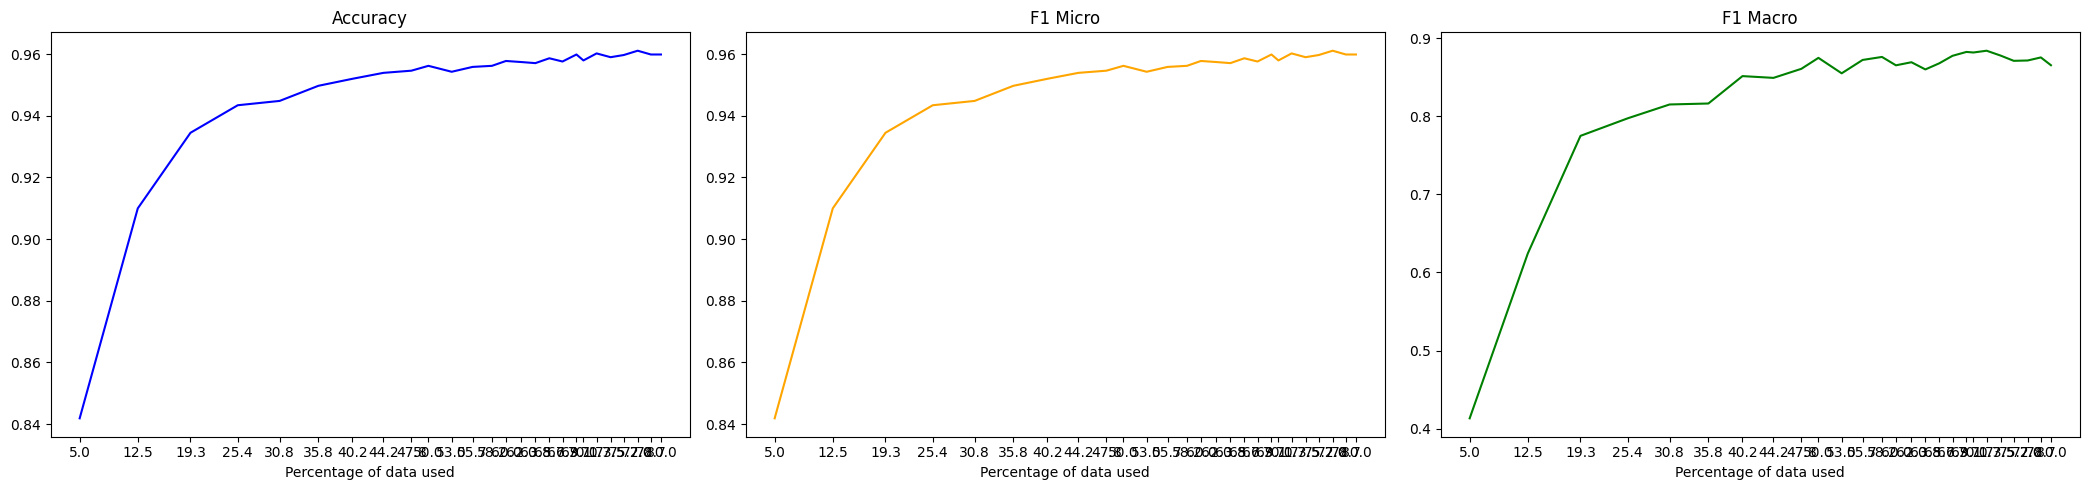

In [ ]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6846, Accuracy: 0.7771, F1 Micro: 0.873, F1 Macro: 0.8661
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5356, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4856, Accuracy: 0.8019, F1 Micro: 0.8899, F1 Macro: 0.8853
Epoch 4/10, Train Loss: 0.4451, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Epoch 5/10, Train Loss: 0.447, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4104, Accuracy: 0.8038, F1 Micro: 0.8908, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4062, Accuracy: 0.8099, F1 Micro: 0.893, F1 Macro: 0.8864
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4023, Accuracy: 0.8189, F1 Micro: 0.8974, F1 Macro: 0.8906
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3668, Accuracy: 0.8349, F1 Micro: 0.9047, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6158, Accuracy: 0.6141, F1 Micro: 0.6141, F1 Macro: 0.3805
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4961, Accuracy: 0.6141, F1 Micro: 0.6141, F1 Macro: 0.3805
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4198, Accuracy: 0.6141, F1 Micro: 0.6141, F1 Macro: 0.3805
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4426, Accuracy: 0.6141, F1 Micro: 0.6141, F1 Macro: 0.3805
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3147, Accuracy: 0.7391, F1 Micro: 0.7391, F1 Macro: 0.6783
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2361, Accuracy: 0.7636, F1 Micro: 0.7636, F1 Macro: 0.7349
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2395, Accuracy: 0.7663, F1 Micro: 0.7663, F1 Macro: 0.7452
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2328, Accuracy: 0.7935, F1 Micro: 0.7935, F1 Macro: 0.781
Epoch 9/10, Train Loss: 0.1405, Accuracy: 0.7799, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5984, Accuracy: 0.8014, F1 Micro: 0.8897, F1 Macro: 0.8852
Epoch 2/10, Train Loss: 0.4729, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4591, Accuracy: 0.8094, F1 Micro: 0.8929, F1 Macro: 0.8867
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4355, Accuracy: 0.8227, F1 Micro: 0.9, F1 Macro: 0.8952
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3857, Accuracy: 0.858, F1 Micro: 0.9173, F1 Macro: 0.9124
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3276, Accuracy: 0.8878, F1 Micro: 0.9327, F1 Macro: 0.9258
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2883, Accuracy: 0.8955, F1 Micro: 0.9374, F1 Macro: 0.9321
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2492, Accuracy: 0.9122, F1 Micro: 0.9468, F1 Macro: 0.9428
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.229, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5712, Accuracy: 0.7244, F1 Micro: 0.7244, F1 Macro: 0.4201
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4249, Accuracy: 0.8015, F1 Micro: 0.8015, F1 Macro: 0.7038
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2802, Accuracy: 0.8049, F1 Micro: 0.8049, F1 Macro: 0.7583
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2505, Accuracy: 0.8324, F1 Micro: 0.8324, F1 Macro: 0.7536
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2168, Accuracy: 0.8445, F1 Micro: 0.8445, F1 Macro: 0.7797
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.175, Accuracy: 0.8501, F1 Micro: 0.8501, F1 Macro: 0.7947
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1403, Accuracy: 0.8578, F1 Micro: 0.8578, F1 Macro: 0.7998
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1235, Accuracy: 0.8633, F1 Micro: 0.8633, F1 Macro: 0.8128
Epoch 9/10, Train Loss: 0.088, Accuracy: 0.8589, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.56, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4781, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4384, Accuracy: 0.8382, F1 Micro: 0.9067, F1 Macro: 0.8988
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3906, Accuracy: 0.867, F1 Micro: 0.9223, F1 Macro: 0.9176
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3332, Accuracy: 0.9068, F1 Micro: 0.9438, F1 Macro: 0.9395
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2722, Accuracy: 0.9264, F1 Micro: 0.955, F1 Macro: 0.9518
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2373, Accuracy: 0.9326, F1 Micro: 0.9589, F1 Macro: 0.956
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2007, Accuracy: 0.9363, F1 Micro: 0.9611, F1 Macro: 0.9581
Higher F1 achieved, saving model
Epoch 9/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5316, Accuracy: 0.7479, F1 Micro: 0.7479, F1 Macro: 0.4943
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3891, Accuracy: 0.8337, F1 Micro: 0.8337, F1 Macro: 0.7518
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3118, Accuracy: 0.8441, F1 Micro: 0.8441, F1 Macro: 0.7942
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2243, Accuracy: 0.863, F1 Micro: 0.863, F1 Macro: 0.8018
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1377, Accuracy: 0.8672, F1 Micro: 0.8672, F1 Macro: 0.8052
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1307, Accuracy: 0.8713, F1 Micro: 0.8713, F1 Macro: 0.8287
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1134, Accuracy: 0.8828, F1 Micro: 0.8828, F1 Macro: 0.8352
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0849, Accuracy: 0.887, F1 Micro: 0.887, F1 Macro: 0.8481
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5443, Accuracy: 0.8021, F1 Micro: 0.89, F1 Macro: 0.8855
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.471, Accuracy: 0.8156, F1 Micro: 0.8952, F1 Macro: 0.8868
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4242, Accuracy: 0.8571, F1 Micro: 0.9173, F1 Macro: 0.9125
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3501, Accuracy: 0.9061, F1 Micro: 0.9438, F1 Macro: 0.9393
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2785, Accuracy: 0.9285, F1 Micro: 0.9567, F1 Macro: 0.9536
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2501, Accuracy: 0.9358, F1 Micro: 0.9608, F1 Macro: 0.9578
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2036, Accuracy: 0.9479, F1 Micro: 0.968, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1719, Accuracy: 0.9509, F1 Micro: 0.9697, F1 Macro: 0.9664
Epoch 9/10, Train Loss: 0.1562, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5027, Accuracy: 0.8321, F1 Micro: 0.8321, F1 Macro: 0.7707
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3613, Accuracy: 0.856, F1 Micro: 0.856, F1 Macro: 0.8102
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2915, Accuracy: 0.8618, F1 Micro: 0.8618, F1 Macro: 0.815
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2415, Accuracy: 0.8724, F1 Micro: 0.8724, F1 Macro: 0.8332
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1811, Accuracy: 0.88, F1 Micro: 0.88, F1 Macro: 0.8396
Epoch 6/10, Train Loss: 0.1514, Accuracy: 0.8704, F1 Micro: 0.8704, F1 Macro: 0.8176
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1332, Accuracy: 0.8858, F1 Micro: 0.8858, F1 Macro: 0.8485
Epoch 8/10, Train Loss: 0.1088, Accuracy: 0.8704, F1 Micro: 0.8704, F1 Macro: 0.8409
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0937, Accuracy: 0.8896, F1 Micro: 0.8896, F1 Macro: 0.8532
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5436, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4561, Accuracy: 0.8281, F1 Micro: 0.902, F1 Macro: 0.8956
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3905, Accuracy: 0.8939, F1 Micro: 0.9365, F1 Macro: 0.9296
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.298, Accuracy: 0.934, F1 Micro: 0.9597, F1 Macro: 0.9566
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2482, Accuracy: 0.942, F1 Micro: 0.9646, F1 Macro: 0.9617
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2025, Accuracy: 0.9481, F1 Micro: 0.9681, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1732, Accuracy: 0.9493, F1 Micro: 0.969, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1555, Accuracy: 0.9564, F1 Micro: 0.9731, F1 Macro: 0.9706
Epoch 9/10, Train Loss: 0.1298, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4824, Accuracy: 0.8387, F1 Micro: 0.8387, F1 Macro: 0.8003
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3094, Accuracy: 0.8688, F1 Micro: 0.8688, F1 Macro: 0.8169
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2419, Accuracy: 0.8795, F1 Micro: 0.8795, F1 Macro: 0.8388
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2029, Accuracy: 0.8892, F1 Micro: 0.8892, F1 Macro: 0.8469
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.166, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.8654
Epoch 6/10, Train Loss: 0.124, Accuracy: 0.896, F1 Micro: 0.896, F1 Macro: 0.8629
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0888, Accuracy: 0.8989, F1 Micro: 0.8989, F1 Macro: 0.8658
Epoch 8/10, Train Loss: 0.0928, Accuracy: 0.897, F1 Micro: 0.897, F1 Macro: 0.8633
Epoch 9/10, Train Loss: 0.0763, Accuracy: 0.8912, F1 Micro: 0.8912, F1 Macro: 0.8525
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5329, Accuracy: 0.8014, F1 Micro: 0.8897, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4514, Accuracy: 0.8394, F1 Micro: 0.907, F1 Macro: 0.8997
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3562, Accuracy: 0.9083, F1 Micro: 0.9451, F1 Macro: 0.9412
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2626, Accuracy: 0.9293, F1 Micro: 0.957, F1 Macro: 0.9537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.228, Accuracy: 0.9403, F1 Micro: 0.9636, F1 Macro: 0.9609
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1899, Accuracy: 0.9509, F1 Micro: 0.9698, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1609, Accuracy: 0.9526, F1 Micro: 0.9708, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1369, Accuracy: 0.9557, F1 Micro: 0.9727, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4795, Accuracy: 0.8341, F1 Micro: 0.8341, F1 Macro: 0.7665
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3081, Accuracy: 0.869, F1 Micro: 0.869, F1 Macro: 0.8259
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2587, Accuracy: 0.8926, F1 Micro: 0.8926, F1 Macro: 0.8574
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1766, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.8682
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1344, Accuracy: 0.901, F1 Micro: 0.901, F1 Macro: 0.8713
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.108, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8762
Epoch 7/10, Train Loss: 0.0724, Accuracy: 0.8963, F1 Micro: 0.8963, F1 Macro: 0.8613
Epoch 8/10, Train Loss: 0.0801, Accuracy: 0.8935, F1 Micro: 0.8935, F1 Macro: 0.8577
Epoch 9/10, Train Loss: 0.0523, Accuracy: 0.8897, F1 Micro: 0.8897, F1 Macro: 0.8523
Epoch 10/10, Train Loss: 0.0701, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5222, Accuracy: 0.8062, F1 Micro: 0.892, F1 Macro: 0.8873
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4349, Accuracy: 0.8795, F1 Micro: 0.9289, F1 Macro: 0.9245
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3293, Accuracy: 0.9292, F1 Micro: 0.9567, F1 Macro: 0.9531
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2506, Accuracy: 0.9425, F1 Micro: 0.9649, F1 Macro: 0.9624
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2059, Accuracy: 0.9455, F1 Micro: 0.9666, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1759, Accuracy: 0.951, F1 Micro: 0.9698, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1533, Accuracy: 0.9538, F1 Micro: 0.9715, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.132, Accuracy: 0.958, F1 Micro: 0.974, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4435, Accuracy: 0.8542, F1 Micro: 0.8542, F1 Macro: 0.8045
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.308, Accuracy: 0.8721, F1 Micro: 0.8721, F1 Macro: 0.8316
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2349, Accuracy: 0.8965, F1 Micro: 0.8965, F1 Macro: 0.8654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.169, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.879
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.8863
Epoch 6/10, Train Loss: 0.1136, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.8798
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0683, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.8877
Epoch 8/10, Train Loss: 0.0788, Accuracy: 0.9106, F1 Micro: 0.9106, F1 Macro: 0.8836
Epoch 9/10, Train Loss: 0.041, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.8855
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5131, Accuracy: 0.8099, F1 Micro: 0.8927, F1 Macro: 0.8855
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4122, Accuracy: 0.8856, F1 Micro: 0.9323, F1 Macro: 0.9272
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.302, Accuracy: 0.9325, F1 Micro: 0.9589, F1 Macro: 0.9563
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2362, Accuracy: 0.9432, F1 Micro: 0.9653, F1 Macro: 0.963
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1973, Accuracy: 0.9531, F1 Micro: 0.9711, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1608, Accuracy: 0.9538, F1 Micro: 0.9715, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1341, Accuracy: 0.9585, F1 Micro: 0.9743, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1189, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9735
Epoch 9/10, Train Loss: 0.1027, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4615, Accuracy: 0.8614, F1 Micro: 0.8614, F1 Macro: 0.8152
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2865, Accuracy: 0.8848, F1 Micro: 0.8848, F1 Macro: 0.851
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2388, Accuracy: 0.8923, F1 Micro: 0.8923, F1 Macro: 0.8626
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.164, Accuracy: 0.9054, F1 Micro: 0.9054, F1 Macro: 0.8785
Epoch 5/10, Train Loss: 0.1308, Accuracy: 0.9017, F1 Micro: 0.9017, F1 Macro: 0.8748
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0789, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8786
Epoch 7/10, Train Loss: 0.0985, Accuracy: 0.9036, F1 Micro: 0.9036, F1 Macro: 0.8755
Epoch 8/10, Train Loss: 0.0646, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.8761
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.051, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8806
Epoch 10/10, Train Loss: 0.0414, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5132, Accuracy: 0.8102, F1 Micro: 0.8932, F1 Macro: 0.8868
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4133, Accuracy: 0.8906, F1 Micro: 0.9353, F1 Macro: 0.9309
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2871, Accuracy: 0.9321, F1 Micro: 0.9588, F1 Macro: 0.9562
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2244, Accuracy: 0.9443, F1 Micro: 0.9659, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1796, Accuracy: 0.9517, F1 Micro: 0.9703, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1506, Accuracy: 0.9523, F1 Micro: 0.9705, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1381, Accuracy: 0.9585, F1 Micro: 0.9743, F1 Macro: 0.9718
Epoch 8/10, Train Loss: 0.1103, Accuracy: 0.958, F1 Micro: 0.974, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0972, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4237, Accuracy: 0.847, F1 Micro: 0.847, F1 Macro: 0.806
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2731, Accuracy: 0.871, F1 Micro: 0.871, F1 Macro: 0.8279
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2234, Accuracy: 0.8977, F1 Micro: 0.8977, F1 Macro: 0.8687
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1685, Accuracy: 0.8995, F1 Micro: 0.8995, F1 Macro: 0.869
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1268, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.8789
Epoch 6/10, Train Loss: 0.0958, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8789
Epoch 7/10, Train Loss: 0.0749, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8745
Epoch 8/10, Train Loss: 0.0665, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8764
Epoch 9/10, Train Loss: 0.0429, Accuracy: 0.9032, F1 Micro: 0.9032, F1 Macro: 0.8769
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0372, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5091, Accuracy: 0.8054, F1 Micro: 0.8917, F1 Macro: 0.8871
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3923, Accuracy: 0.9017, F1 Micro: 0.9413, F1 Macro: 0.937
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2773, Accuracy: 0.9384, F1 Micro: 0.9624, F1 Macro: 0.9597
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.216, Accuracy: 0.9464, F1 Micro: 0.9671, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1812, Accuracy: 0.9556, F1 Micro: 0.9725, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.15, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.9723
Epoch 7/10, Train Loss: 0.1332, Accuracy: 0.958, F1 Micro: 0.974, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1086, Accuracy: 0.9589, F1 Micro: 0.9746, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0911, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4488, Accuracy: 0.8601, F1 Micro: 0.8601, F1 Macro: 0.819
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2625, Accuracy: 0.873, F1 Micro: 0.873, F1 Macro: 0.8271
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2012, Accuracy: 0.899, F1 Micro: 0.899, F1 Macro: 0.8684
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1338, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.8787
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0979, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.8821
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0753, Accuracy: 0.9092, F1 Micro: 0.9092, F1 Macro: 0.8842
Epoch 7/10, Train Loss: 0.0775, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.8781
Epoch 8/10, Train Loss: 0.0657, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8829
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0442, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Macro: 0.8858
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5041, Accuracy: 0.8092, F1 Micro: 0.8935, F1 Macro: 0.8888
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3666, Accuracy: 0.9148, F1 Micro: 0.9488, F1 Macro: 0.9455
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2606, Accuracy: 0.9398, F1 Micro: 0.9633, F1 Macro: 0.9608
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2041, Accuracy: 0.9516, F1 Micro: 0.9701, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1651, Accuracy: 0.9569, F1 Micro: 0.9733, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1417, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.974
Epoch 7/10, Train Loss: 0.1152, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1021, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9748
Epoch 9/10, Train Loss: 0.0867, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4157, Accuracy: 0.8611, F1 Micro: 0.8611, F1 Macro: 0.8114
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2737, Accuracy: 0.8924, F1 Micro: 0.8924, F1 Macro: 0.8646
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1742, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8782
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1293, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.8769
Epoch 5/10, Train Loss: 0.1095, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8801
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0804, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.8866
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0561, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.8906
Epoch 8/10, Train Loss: 0.0435, Accuracy: 0.9006, F1 Micro: 0.9006, F1 Macro: 0.8749
Epoch 9/10, Train Loss: 0.0434, Accuracy: 0.9034, F1 Micro: 0.9034, F1 Macro: 0.8739
Epoch 10/10, Train Loss: 0.0453, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5039, Accuracy: 0.8191, F1 Micro: 0.8973, F1 Macro: 0.8901
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3721, Accuracy: 0.9144, F1 Micro: 0.9484, F1 Macro: 0.9447
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2524, Accuracy: 0.9446, F1 Micro: 0.9661, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.203, Accuracy: 0.9498, F1 Micro: 0.9692, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.169, Accuracy: 0.9564, F1 Micro: 0.9731, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1458, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.117, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1023, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.975
Epoch 9/10, Train Loss: 0.0888, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4199, Accuracy: 0.8598, F1 Micro: 0.8598, F1 Macro: 0.8116
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2754, Accuracy: 0.8976, F1 Micro: 0.8976, F1 Macro: 0.8675
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1648, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.8802
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1459, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.8893
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0935, Accuracy: 0.9179, F1 Micro: 0.9179, F1 Macro: 0.8954
Epoch 6/10, Train Loss: 0.0671, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Macro: 0.8918
Epoch 7/10, Train Loss: 0.0504, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.8905
Epoch 8/10, Train Loss: 0.0509, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0392, Accuracy: 0.9197, F1 Micro: 0.9197, F1 Macro: 0.8968
Epoch 10/10, Train Loss: 0.0327, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4962, Accuracy: 0.829, F1 Micro: 0.9021, F1 Macro: 0.8946
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.353, Accuracy: 0.9158, F1 Micro: 0.949, F1 Macro: 0.9449
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2442, Accuracy: 0.9434, F1 Micro: 0.9654, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1954, Accuracy: 0.951, F1 Micro: 0.9699, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1652, Accuracy: 0.9587, F1 Micro: 0.9744, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1348, Accuracy: 0.9608, F1 Micro: 0.9756, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1153, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9748
Epoch 8/10, Train Loss: 0.0992, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.085, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3983, Accuracy: 0.8586, F1 Micro: 0.8586, F1 Macro: 0.8152
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.253, Accuracy: 0.8896, F1 Micro: 0.8896, F1 Macro: 0.8533
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1709, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1366, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1011, Accuracy: 0.9106, F1 Micro: 0.9106, F1 Macro: 0.8856
Epoch 6/10, Train Loss: 0.0756, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8789
Epoch 7/10, Train Loss: 0.0557, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.8756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0614, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8849
Epoch 9/10, Train Loss: 0.0429, Accuracy: 0.9005, F1 Micro: 0.9005, F1 Macro: 0.8697
Epoch 10/10, Train Loss: 0.0379, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4923, Accuracy: 0.8274, F1 Micro: 0.902, F1 Macro: 0.8963
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3464, Accuracy: 0.9217, F1 Micro: 0.9522, F1 Macro: 0.9479
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2428, Accuracy: 0.9411, F1 Micro: 0.9642, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.184, Accuracy: 0.954, F1 Micro: 0.9717, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1496, Accuracy: 0.9564, F1 Micro: 0.9732, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1327, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1126, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9754
Epoch 8/10, Train Loss: 0.0941, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9753
Epoch 9/10, Train Loss: 0.0792, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.391, Accuracy: 0.8573, F1 Micro: 0.8573, F1 Macro: 0.8091
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2334, Accuracy: 0.8902, F1 Micro: 0.8902, F1 Macro: 0.8556
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1818, Accuracy: 0.8939, F1 Micro: 0.8939, F1 Macro: 0.8581
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1344, Accuracy: 0.8984, F1 Micro: 0.8984, F1 Macro: 0.8678
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0949, Accuracy: 0.9058, F1 Micro: 0.9058, F1 Macro: 0.8768
Epoch 6/10, Train Loss: 0.0816, Accuracy: 0.903, F1 Micro: 0.903, F1 Macro: 0.8739
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0736, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.8848
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0468, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.8861
Epoch 9/10, Train Loss: 0.0345, Accuracy: 0.9085, F1 Micro: 0.9085, F1 Macro: 0.8819
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4876, Accuracy: 0.8342, F1 Micro: 0.9057, F1 Macro: 0.901
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3331, Accuracy: 0.9253, F1 Micro: 0.9549, F1 Macro: 0.952
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2316, Accuracy: 0.9467, F1 Micro: 0.9674, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1818, Accuracy: 0.9523, F1 Micro: 0.9706, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1497, Accuracy: 0.9566, F1 Micro: 0.9731, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1277, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1063, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0881, Accuracy: 0.9668, F1 Micro: 0.9794, F1 Macro: 0.9774
Epoch 9/10, Train Loss: 0.0729, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3888, Accuracy: 0.8662, F1 Micro: 0.8662, F1 Macro: 0.8195
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2299, Accuracy: 0.8891, F1 Micro: 0.8891, F1 Macro: 0.852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1564, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.8821
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1312, Accuracy: 0.9148, F1 Micro: 0.9148, F1 Macro: 0.8874
Epoch 5/10, Train Loss: 0.1065, Accuracy: 0.89, F1 Micro: 0.89, F1 Macro: 0.8635
Epoch 6/10, Train Loss: 0.0666, Accuracy: 0.9047, F1 Micro: 0.9047, F1 Macro: 0.88
Epoch 7/10, Train Loss: 0.0667, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8871
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0361, Accuracy: 0.9203, F1 Micro: 0.9203, F1 Macro: 0.897
Epoch 9/10, Train Loss: 0.0244, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8878
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0387, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4876, Accuracy: 0.8368, F1 Micro: 0.9069, F1 Macro: 0.9016
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3305, Accuracy: 0.9311, F1 Micro: 0.9579, F1 Macro: 0.9551
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2322, Accuracy: 0.946, F1 Micro: 0.9669, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1796, Accuracy: 0.9559, F1 Micro: 0.9728, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1495, Accuracy: 0.9583, F1 Micro: 0.9742, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1292, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1055, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0836, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3809, Accuracy: 0.8668, F1 Micro: 0.8668, F1 Macro: 0.8241
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.231, Accuracy: 0.9005, F1 Micro: 0.9005, F1 Macro: 0.8721
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.179, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.8708
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1077, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.8702
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0866, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.882
Epoch 6/10, Train Loss: 0.0564, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.037, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8901
Epoch 8/10, Train Loss: 0.0431, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8791
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.9133, F1 Micro: 0.9133, F1 Macro: 0.8873
Epoch 10/10, Train Loss: 0.016, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.486, Accuracy: 0.845, F1 Micro: 0.9107, F1 Macro: 0.9052
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3228, Accuracy: 0.9325, F1 Micro: 0.9589, F1 Macro: 0.9566
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2205, Accuracy: 0.9469, F1 Micro: 0.9675, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1718, Accuracy: 0.9517, F1 Micro: 0.9703, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1449, Accuracy: 0.9575, F1 Micro: 0.9738, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1208, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1005, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0838, Accuracy: 0.9644, F1 Micro: 0.9778, F1 Macro: 0.9756
Epoch 9/10, Train Loss: 0.0709, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3795, Accuracy: 0.8685, F1 Micro: 0.8685, F1 Macro: 0.8253
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2282, Accuracy: 0.9018, F1 Micro: 0.9018, F1 Macro: 0.8738
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1466, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.8843
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1065, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.8883
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0812, Accuracy: 0.9153, F1 Micro: 0.9153, F1 Macro: 0.8929
Epoch 6/10, Train Loss: 0.0632, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.8881
Epoch 7/10, Train Loss: 0.0463, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8833
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0374, Accuracy: 0.9207, F1 Micro: 0.9207, F1 Macro: 0.8982
Epoch 9/10, Train Loss: 0.034, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.8959
Epoch 10/10, Train Loss: 0.0427, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4789, Accuracy: 0.8542, F1 Micro: 0.9145, F1 Macro: 0.9064
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3059, Accuracy: 0.9335, F1 Micro: 0.9593, F1 Macro: 0.9561
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2169, Accuracy: 0.9488, F1 Micro: 0.9686, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1727, Accuracy: 0.9564, F1 Micro: 0.9731, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1389, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1167, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0981, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0835, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3598, Accuracy: 0.8454, F1 Micro: 0.8454, F1 Macro: 0.8183
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2527, Accuracy: 0.8911, F1 Micro: 0.8911, F1 Macro: 0.8531
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1588, Accuracy: 0.9021, F1 Micro: 0.9021, F1 Macro: 0.8692
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1056, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.885
Epoch 5/10, Train Loss: 0.0803, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.8821
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0713, Accuracy: 0.914, F1 Micro: 0.914, F1 Macro: 0.8885
Epoch 7/10, Train Loss: 0.0528, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0414, Accuracy: 0.9158, F1 Micro: 0.9158, F1 Macro: 0.8908
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0326, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.8945
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4787, Accuracy: 0.8616, F1 Micro: 0.9195, F1 Macro: 0.9147
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3031, Accuracy: 0.9339, F1 Micro: 0.9598, F1 Macro: 0.9575
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2138, Accuracy: 0.9451, F1 Micro: 0.9663, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1714, Accuracy: 0.9561, F1 Micro: 0.9729, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1399, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9746
Epoch 6/10, Train Loss: 0.1138, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.095, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9757
Epoch 8/10, Train Loss: 0.0823, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9754
Epoch 9/10, Train Loss: 0.0693, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9751
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3566, Accuracy: 0.8698, F1 Micro: 0.8698, F1 Macro: 0.831
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2335, Accuracy: 0.8818, F1 Micro: 0.8818, F1 Macro: 0.8419
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1618, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.8727
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0967, Accuracy: 0.9138, F1 Micro: 0.9138, F1 Macro: 0.8876
Epoch 5/10, Train Loss: 0.0798, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8875
Epoch 6/10, Train Loss: 0.0578, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8813
Epoch 7/10, Train Loss: 0.0449, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.033, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.8917
Epoch 9/10, Train Loss: 0.0303, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0269, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4802, Accuracy: 0.8687, F1 Micro: 0.9231, F1 Macro: 0.9167
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3035, Accuracy: 0.9332, F1 Micro: 0.9594, F1 Macro: 0.9571
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2168, Accuracy: 0.95, F1 Micro: 0.9693, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1708, Accuracy: 0.9561, F1 Micro: 0.9729, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1386, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9738
Epoch 6/10, Train Loss: 0.1145, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0982, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.08, Accuracy: 0.9653, F1 Micro: 0.9785, F1 Macro: 0.9766
Epoch 9/10, Train Loss: 0.0683, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3644, Accuracy: 0.865, F1 Micro: 0.865, F1 Macro: 0.8138
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2091, Accuracy: 0.9022, F1 Micro: 0.9022, F1 Macro: 0.8709
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1495, Accuracy: 0.9143, F1 Micro: 0.9143, F1 Macro: 0.8873
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1032, Accuracy: 0.9143, F1 Micro: 0.9143, F1 Macro: 0.8884
Epoch 5/10, Train Loss: 0.0782, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0519, Accuracy: 0.9209, F1 Micro: 0.9209, F1 Macro: 0.8965
Epoch 7/10, Train Loss: 0.0448, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.8903
Epoch 8/10, Train Loss: 0.0392, Accuracy: 0.9181, F1 Micro: 0.9181, F1 Macro: 0.8927
Epoch 9/10, Train Loss: 0.0284, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.8859
Epoch 10/10, Train Loss: 0.0302, Accuracy: 0.9106, F1 Micro: 0.9106, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4713, Accuracy: 0.8755, F1 Micro: 0.9267, F1 Macro: 0.9208
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2947, Accuracy: 0.9366, F1 Micro: 0.9612, F1 Macro: 0.9583
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2098, Accuracy: 0.947, F1 Micro: 0.9676, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1643, Accuracy: 0.9573, F1 Micro: 0.9737, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.138, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1122, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9755
Epoch 7/10, Train Loss: 0.0964, Accuracy: 0.9632, F1 Micro: 0.9771, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0806, Accuracy: 0.9658, F1 Micro: 0.9788, F1 Macro: 0.9766
Epoch 9/10, Train Loss: 0.0692, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3394, Accuracy: 0.8718, F1 Micro: 0.8718, F1 Macro: 0.8271
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1967, Accuracy: 0.8976, F1 Micro: 0.8976, F1 Macro: 0.8653
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1405, Accuracy: 0.9133, F1 Micro: 0.9133, F1 Macro: 0.8871
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1027, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Macro: 0.8908
Epoch 5/10, Train Loss: 0.0787, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8814
Epoch 6/10, Train Loss: 0.0569, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8655
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0573, Accuracy: 0.9207, F1 Micro: 0.9207, F1 Macro: 0.8977
Epoch 8/10, Train Loss: 0.0266, Accuracy: 0.9197, F1 Micro: 0.9197, F1 Macro: 0.8947
Epoch 9/10, Train Loss: 0.0257, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8871
Epoch 10/10, Train Loss: 0.036, Accuracy: 0.9142, F1 Micro: 0.9142, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4685, Accuracy: 0.8691, F1 Micro: 0.9231, F1 Macro: 0.9175
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2863, Accuracy: 0.9359, F1 Micro: 0.961, F1 Macro: 0.9586
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1996, Accuracy: 0.9488, F1 Micro: 0.9685, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1635, Accuracy: 0.9552, F1 Micro: 0.9723, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.132, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1086, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9758
Epoch 7/10, Train Loss: 0.0914, Accuracy: 0.9637, F1 Micro: 0.9774, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0764, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9762
Epoch 9/10, Train Loss: 0.0655, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3669, Accuracy: 0.8643, F1 Micro: 0.8643, F1 Macro: 0.817
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2066, Accuracy: 0.9021, F1 Micro: 0.9021, F1 Macro: 0.8747
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1353, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8859
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1009, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.8852
Epoch 5/10, Train Loss: 0.0747, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0692, Accuracy: 0.9164, F1 Micro: 0.9164, F1 Macro: 0.8933
Epoch 7/10, Train Loss: 0.037, Accuracy: 0.9057, F1 Micro: 0.9057, F1 Macro: 0.8758
Epoch 8/10, Train Loss: 0.0316, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0298, Accuracy: 0.9164, F1 Micro: 0.9164, F1 Macro: 0.8931
Epoch 10/10, Train Loss: 0.0203, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4616, Accuracy: 0.8795, F1 Micro: 0.929, F1 Macro: 0.9241
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2816, Accuracy: 0.9375, F1 Micro: 0.9619, F1 Macro: 0.9598
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1969, Accuracy: 0.9484, F1 Micro: 0.9684, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1553, Accuracy: 0.9568, F1 Micro: 0.9734, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1302, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro: 0.9744
Epoch 6/10, Train Loss: 0.1072, Accuracy: 0.9597, F1 Micro: 0.9752, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0873, Accuracy: 0.966, F1 Micro: 0.9788, F1 Macro: 0.9766
Epoch 8/10, Train Loss: 0.0737, Accuracy: 0.9651, F1 Micro: 0.9784, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0624, Accuracy: 0.9663, F1 Micro: 0.979, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3464, Accuracy: 0.8692, F1 Micro: 0.8692, F1 Macro: 0.8212
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1927, Accuracy: 0.9012, F1 Micro: 0.9012, F1 Macro: 0.8682
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1467, Accuracy: 0.9131, F1 Micro: 0.9131, F1 Macro: 0.8869
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1062, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.894
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0825, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.8967
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0562, Accuracy: 0.9241, F1 Micro: 0.9241, F1 Macro: 0.9018
Epoch 7/10, Train Loss: 0.0492, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.8991
Epoch 8/10, Train Loss: 0.0417, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.8862
Epoch 9/10, Train Loss: 0.0301, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.8789
Epoch 10/10, Train Loss: 0.0351, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4534, Accuracy: 0.8755, F1 Micro: 0.9266, F1 Macro: 0.9198
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2737, Accuracy: 0.9387, F1 Micro: 0.9626, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1915, Accuracy: 0.953, F1 Micro: 0.9711, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1569, Accuracy: 0.955, F1 Micro: 0.9723, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1251, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1062, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0845, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0739, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3478, Accuracy: 0.8487, F1 Micro: 0.8487, F1 Macro: 0.7787
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2168, Accuracy: 0.8952, F1 Micro: 0.8952, F1 Macro: 0.8626
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1342, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.869
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.089, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.8875
Epoch 5/10, Train Loss: 0.0613, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0468, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.8926
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0339, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.8942
Epoch 8/10, Train Loss: 0.0258, Accuracy: 0.9152, F1 Micro: 0.9152, F1 Macro: 0.8897
Epoch 9/10, Train Loss: 0.0285, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Macro: 0.8897
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4592, Accuracy: 0.883, F1 Micro: 0.9309, F1 Macro: 0.9259
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2732, Accuracy: 0.9391, F1 Micro: 0.9627, F1 Macro: 0.9604
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1871, Accuracy: 0.9507, F1 Micro: 0.9697, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.15, Accuracy: 0.9566, F1 Micro: 0.9732, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1204, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1036, Accuracy: 0.9637, F1 Micro: 0.9774, F1 Macro: 0.9753
Epoch 7/10, Train Loss: 0.0848, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0731, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0585, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3552, Accuracy: 0.87, F1 Micro: 0.87, F1 Macro: 0.8333
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2069, Accuracy: 0.9002, F1 Micro: 0.9002, F1 Macro: 0.8702
Epoch 3/10, Train Loss: 0.1386, Accuracy: 0.8965, F1 Micro: 0.8965, F1 Macro: 0.8648
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1037, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0782, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.8874
Epoch 6/10, Train Loss: 0.0484, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0458, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8879
Epoch 8/10, Train Loss: 0.0418, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8804
Epoch 9/10, Train Loss: 0.0287, Accuracy: 0.9066, F1 Micro: 0.9066, F1 Macro: 0.8797
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0217, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4415, Accuracy: 0.8847, F1 Micro: 0.9319, F1 Macro: 0.927
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.257, Accuracy: 0.9432, F1 Micro: 0.9652, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1811, Accuracy: 0.9493, F1 Micro: 0.9689, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1462, Accuracy: 0.9554, F1 Micro: 0.9725, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1189, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0995, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0848, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0682, Accuracy: 0.966, F1 Micro: 0.9789, F1 Macro: 0.9765
Epoch 9/10, Train Loss: 0.0574, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3289, Accuracy: 0.8792, F1 Micro: 0.8792, F1 Macro: 0.8458
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1988, Accuracy: 0.9039, F1 Micro: 0.9039, F1 Macro: 0.8761
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1413, Accuracy: 0.9131, F1 Micro: 0.9131, F1 Macro: 0.8882
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1031, Accuracy: 0.9177, F1 Micro: 0.9177, F1 Macro: 0.8942
Epoch 5/10, Train Loss: 0.0678, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8848
Epoch 6/10, Train Loss: 0.0485, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.878
Epoch 7/10, Train Loss: 0.0371, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8842
Epoch 8/10, Train Loss: 0.036, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.878
Epoch 9/10, Train Loss: 0.0275, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.8853
Epoch 10/10, Train Loss: 0.0233, Accuracy: 0.9131, F1 Micro: 0.9131, F1 Macro: 0.8879

Sentiment analysis 

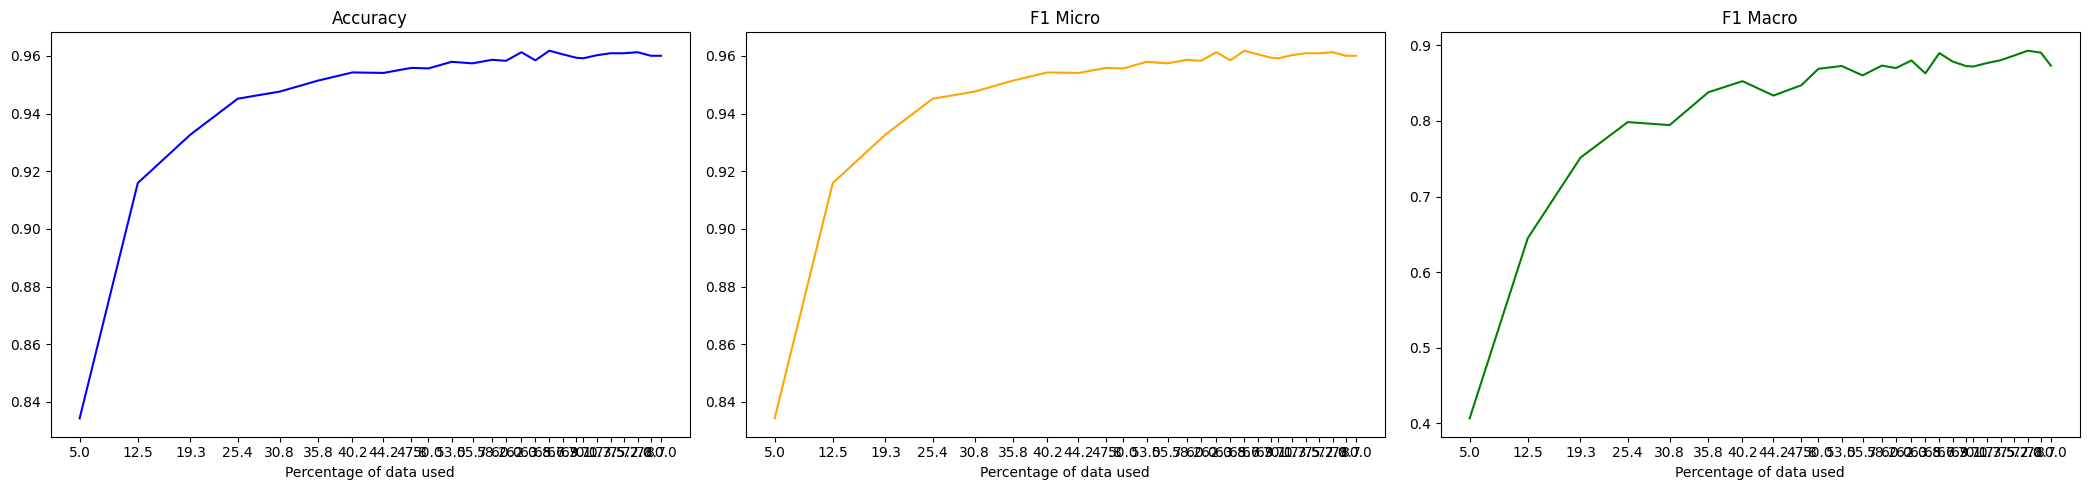

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6341, Accuracy: 0.7974, F1 Micro: 0.8859, F1 Macro: 0.8768
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5134, Accuracy: 0.8014, F1 Micro: 0.8897, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4829, Accuracy: 0.8017, F1 Micro: 0.8897, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4632, Accuracy: 0.8045, F1 Micro: 0.8906, F1 Macro: 0.8847
Epoch 5/10, Train Loss: 0.4642, Accuracy: 0.8047, F1 Micro: 0.8903, F1 Macro: 0.8835
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4501, Accuracy: 0.8075, F1 Micro: 0.891, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.451, Accuracy: 0.8149, F1 Micro: 0.8947, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4034, Accuracy: 0.8273, F1 Micro: 0.9007, F1 Macro: 0.892
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3957, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7316, Accuracy: 0.5412, F1 Micro: 0.5412, F1 Macro: 0.3512
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.612, Accuracy: 0.5412, F1 Micro: 0.5412, F1 Macro: 0.3512
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5437, Accuracy: 0.5645, F1 Micro: 0.5645, F1 Macro: 0.4185
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5596, Accuracy: 0.5751, F1 Micro: 0.5751, F1 Macro: 0.4522
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4998, Accuracy: 0.5877, F1 Micro: 0.5877, F1 Macro: 0.5659
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.478, Accuracy: 0.6025, F1 Micro: 0.6025, F1 Macro: 0.5626
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3806, Accuracy: 0.666, F1 Micro: 0.666, F1 Macro: 0.6564
Epoch 8/10, Train Loss: 0.3522, Accuracy: 0.6195, F1 Micro: 0.6195, F1 Macro: 0.5823
Epoch 9/10, Train Loss: 0.3548, Accuracy: 0.6575, F1 Micro: 0.6575, F1 Macro: 0.6482
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5676, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.465, Accuracy: 0.8038, F1 Micro: 0.8905, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4481, Accuracy: 0.8111, F1 Micro: 0.8939, F1 Macro: 0.8883
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4248, Accuracy: 0.8311, F1 Micro: 0.9029, F1 Macro: 0.8952
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.393, Accuracy: 0.8547, F1 Micro: 0.9155, F1 Macro: 0.9101
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3413, Accuracy: 0.8887, F1 Micro: 0.9339, F1 Macro: 0.9291
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2954, Accuracy: 0.8997, F1 Micro: 0.94, F1 Macro: 0.9363
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.256, Accuracy: 0.9064, F1 Micro: 0.9438, F1 Macro: 0.9399
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5515, Accuracy: 0.7273, F1 Micro: 0.7273, F1 Macro: 0.425
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4942, Accuracy: 0.7991, F1 Micro: 0.7991, F1 Macro: 0.7544
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3284, Accuracy: 0.8316, F1 Micro: 0.8316, F1 Macro: 0.7737
Epoch 4/10, Train Loss: 0.282, Accuracy: 0.8036, F1 Micro: 0.8036, F1 Macro: 0.7605
Epoch 5/10, Train Loss: 0.2583, Accuracy: 0.8126, F1 Micro: 0.8126, F1 Macro: 0.7012
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2902, Accuracy: 0.8328, F1 Micro: 0.8328, F1 Macro: 0.7931
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2358, Accuracy: 0.8451, F1 Micro: 0.8451, F1 Macro: 0.7989
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1825, Accuracy: 0.8507, F1 Micro: 0.8507, F1 Macro: 0.7805
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1815, Accuracy: 0.8732, F1 Micro: 0.8732, F1 Macro: 0.8287
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5366, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4722, Accuracy: 0.8054, F1 Micro: 0.8915, F1 Macro: 0.8868
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4417, Accuracy: 0.8316, F1 Micro: 0.9042, F1 Macro: 0.8994
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.393, Accuracy: 0.8745, F1 Micro: 0.9264, F1 Macro: 0.9222
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3168, Accuracy: 0.9108, F1 Micro: 0.946, F1 Macro: 0.9418
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.272, Accuracy: 0.9259, F1 Micro: 0.9551, F1 Macro: 0.9519
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2369, Accuracy: 0.9349, F1 Micro: 0.9603, F1 Macro: 0.9571
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.196, Accuracy: 0.9378, F1 Micro: 0.962, F1 Macro: 0.9582
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5539, Accuracy: 0.7669, F1 Micro: 0.7669, F1 Macro: 0.6507
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3751, Accuracy: 0.7853, F1 Micro: 0.7853, F1 Macro: 0.763
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2985, Accuracy: 0.8476, F1 Micro: 0.8476, F1 Macro: 0.8083
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2637, Accuracy: 0.8507, F1 Micro: 0.8507, F1 Macro: 0.7937
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1998, Accuracy: 0.865, F1 Micro: 0.865, F1 Macro: 0.8162
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1761, Accuracy: 0.8742, F1 Micro: 0.8742, F1 Macro: 0.8456
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1446, Accuracy: 0.8753, F1 Micro: 0.8753, F1 Macro: 0.837
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1004, Accuracy: 0.8845, F1 Micro: 0.8845, F1 Macro: 0.8476
Epoch 9/10, Train Loss: 0.0796, Accuracy: 0.8742, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5396, Accuracy: 0.8042, F1 Micro: 0.8891, F1 Macro: 0.8794
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4653, Accuracy: 0.8109, F1 Micro: 0.8943, F1 Macro: 0.8898
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.425, Accuracy: 0.8741, F1 Micro: 0.9258, F1 Macro: 0.9199
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3417, Accuracy: 0.9054, F1 Micro: 0.9434, F1 Macro: 0.9394
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2788, Accuracy: 0.928, F1 Micro: 0.9563, F1 Macro: 0.9533
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2332, Accuracy: 0.9344, F1 Micro: 0.96, F1 Macro: 0.9571
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2032, Accuracy: 0.9439, F1 Micro: 0.9655, F1 Macro: 0.9626
Epoch 8/10, Train Loss: 0.1735, Accuracy: 0.9422, F1 Micro: 0.9648, F1 Macro: 0.9617
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1491, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5417, Accuracy: 0.8164, F1 Micro: 0.8164, F1 Macro: 0.7814
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3249, Accuracy: 0.8574, F1 Micro: 0.8574, F1 Macro: 0.8094
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2413, Accuracy: 0.8633, F1 Micro: 0.8633, F1 Macro: 0.8095
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2092, Accuracy: 0.876, F1 Micro: 0.876, F1 Macro: 0.8259
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1452, Accuracy: 0.9043, F1 Micro: 0.9043, F1 Macro: 0.8753
Epoch 6/10, Train Loss: 0.1327, Accuracy: 0.9033, F1 Micro: 0.9033, F1 Macro: 0.8745
Epoch 7/10, Train Loss: 0.0955, Accuracy: 0.8867, F1 Micro: 0.8867, F1 Macro: 0.8422
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0803, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8782
Epoch 9/10, Train Loss: 0.0602, Accuracy: 0.9033, F1 Micro: 0.9033, F1 Macro: 0.8726
Epoch 10/10, Train Loss: 0.0259, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5237, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4544, Accuracy: 0.841, F1 Micro: 0.9087, F1 Macro: 0.9036
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3803, Accuracy: 0.9009, F1 Micro: 0.9405, F1 Macro: 0.9355
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2873, Accuracy: 0.9333, F1 Micro: 0.9593, F1 Macro: 0.9565
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2282, Accuracy: 0.9352, F1 Micro: 0.9607, F1 Macro: 0.9581
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1942, Accuracy: 0.9458, F1 Micro: 0.9669, F1 Macro: 0.9643
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1636, Accuracy: 0.951, F1 Micro: 0.9698, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1435, Accuracy: 0.9535, F1 Micro: 0.9713, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5398, Accuracy: 0.8147, F1 Micro: 0.8147, F1 Macro: 0.7336
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3506, Accuracy: 0.8639, F1 Micro: 0.8639, F1 Macro: 0.8263
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2817, Accuracy: 0.88, F1 Micro: 0.88, F1 Macro: 0.8438
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2144, Accuracy: 0.8951, F1 Micro: 0.8951, F1 Macro: 0.8651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.129, Accuracy: 0.897, F1 Micro: 0.897, F1 Macro: 0.8704
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.8744
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.8922, F1 Micro: 0.8922, F1 Macro: 0.8579
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0571, Accuracy: 0.9017, F1 Micro: 0.9017, F1 Macro: 0.8773
Epoch 9/10, Train Loss: 0.0589, Accuracy: 0.8998, F1 Micro: 0.8998, F1 Macro: 0.8727
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5136, Accuracy: 0.8021, F1 Micro: 0.89, F1 Macro: 0.8855
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4299, Accuracy: 0.8597, F1 Micro: 0.9187, F1 Macro: 0.9139
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3471, Accuracy: 0.9148, F1 Micro: 0.9486, F1 Macro: 0.9448
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2582, Accuracy: 0.9365, F1 Micro: 0.9613, F1 Macro: 0.9589
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2172, Accuracy: 0.9403, F1 Micro: 0.9636, F1 Macro: 0.961
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1768, Accuracy: 0.9476, F1 Micro: 0.9677, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1511, Accuracy: 0.9505, F1 Micro: 0.9696, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1377, Accuracy: 0.9563, F1 Micro: 0.9729, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4984, Accuracy: 0.8611, F1 Micro: 0.8611, F1 Macro: 0.8113
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3289, Accuracy: 0.8869, F1 Micro: 0.8869, F1 Macro: 0.8534
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2281, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.8808
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1649, Accuracy: 0.9177, F1 Micro: 0.9177, F1 Macro: 0.8939
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1209, Accuracy: 0.9206, F1 Micro: 0.9206, F1 Macro: 0.8939
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0861, Accuracy: 0.9236, F1 Micro: 0.9236, F1 Macro: 0.8998
Epoch 7/10, Train Loss: 0.0704, Accuracy: 0.9206, F1 Micro: 0.9206, F1 Macro: 0.8953
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.906
Epoch 9/10, Train Loss: 0.04, Accuracy: 0.9246, F1 Micro: 0.9246, F1 Macro: 0.9
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5086, Accuracy: 0.805, F1 Micro: 0.8913, F1 Macro: 0.8863
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4215, Accuracy: 0.8847, F1 Micro: 0.9318, F1 Macro: 0.927
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3141, Accuracy: 0.9194, F1 Micro: 0.9514, F1 Macro: 0.9479
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2352, Accuracy: 0.9382, F1 Micro: 0.9623, F1 Macro: 0.9599
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1968, Accuracy: 0.9491, F1 Micro: 0.9686, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.165, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9706
Epoch 7/10, Train Loss: 0.138, Accuracy: 0.9554, F1 Micro: 0.9725, F1 Macro: 0.9702
Epoch 8/10, Train Loss: 0.1177, Accuracy: 0.9559, F1 Micro: 0.9727, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1057, Accuracy: 0.9592, F1 Micro: 0.9747, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4938, Accuracy: 0.8111, F1 Micro: 0.8111, F1 Macro: 0.7086
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2929, Accuracy: 0.8712, F1 Micro: 0.8712, F1 Macro: 0.8395
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2392, Accuracy: 0.8938, F1 Micro: 0.8938, F1 Macro: 0.8665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1643, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.885
Epoch 5/10, Train Loss: 0.1256, Accuracy: 0.8976, F1 Micro: 0.8976, F1 Macro: 0.8649
Epoch 6/10, Train Loss: 0.0802, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8823
Epoch 7/10, Train Loss: 0.0835, Accuracy: 0.9032, F1 Micro: 0.9032, F1 Macro: 0.8756
Epoch 8/10, Train Loss: 0.0528, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8858
Epoch 9/10, Train Loss: 0.0468, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.876
Epoch 10/10, Train Loss: 0.0275, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8727

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.498, Accuracy: 0.8097, F1 Micro: 0.8911, F1 Macro: 0.8783
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3974, Accuracy: 0.8889, F1 Micro: 0.9344, F1 Macro: 0.93
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2915, Accuracy: 0.9321, F1 Micro: 0.9585, F1 Macro: 0.9546
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2244, Accuracy: 0.946, F1 Micro: 0.9669, F1 Macro: 0.9645
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1803, Accuracy: 0.951, F1 Micro: 0.9699, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1533, Accuracy: 0.9594, F1 Micro: 0.9748, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1297, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9729
Epoch 8/10, Train Loss: 0.1095, Accuracy: 0.9583, F1 Micro: 0.9742, F1 Macro: 0.9717
Epoch 9/10, Train Loss: 0.0977, Accuracy: 0.9576, F1 Micro: 0.9738, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4496, Accuracy: 0.8577, F1 Micro: 0.8577, F1 Macro: 0.8063
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2947, Accuracy: 0.8661, F1 Micro: 0.8661, F1 Macro: 0.8141
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2224, Accuracy: 0.9045, F1 Micro: 0.9045, F1 Macro: 0.8757
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1584, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8825
Epoch 5/10, Train Loss: 0.1056, Accuracy: 0.9026, F1 Micro: 0.9026, F1 Macro: 0.8782
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.076, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0722, Accuracy: 0.9148, F1 Micro: 0.9148, F1 Macro: 0.8908
Epoch 8/10, Train Loss: 0.0426, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8817
Epoch 9/10, Train Loss: 0.0284, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8809
Epoch 10/10, Train Loss: 0.042, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4972, Accuracy: 0.8021, F1 Micro: 0.89, F1 Macro: 0.8855
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.392, Accuracy: 0.9005, F1 Micro: 0.9407, F1 Macro: 0.9368
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2762, Accuracy: 0.9318, F1 Micro: 0.9584, F1 Macro: 0.9546
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2064, Accuracy: 0.946, F1 Micro: 0.9669, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1784, Accuracy: 0.9554, F1 Micro: 0.9725, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1501, Accuracy: 0.9566, F1 Micro: 0.9733, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1196, Accuracy: 0.9571, F1 Micro: 0.9735, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1055, Accuracy: 0.9611, F1 Micro: 0.976, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.454, Accuracy: 0.8251, F1 Micro: 0.8251, F1 Macro: 0.7946
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2686, Accuracy: 0.8906, F1 Micro: 0.8906, F1 Macro: 0.8531
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1981, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8798
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1499, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8877
Epoch 5/10, Train Loss: 0.1084, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.875
Epoch 6/10, Train Loss: 0.0853, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8844
Epoch 7/10, Train Loss: 0.0536, Accuracy: 0.9121, F1 Micro: 0.9121, F1 Macro: 0.8876
Epoch 8/10, Train Loss: 0.051, Accuracy: 0.9121, F1 Micro: 0.9121, F1 Macro: 0.8836
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0264, Accuracy: 0.9158, F1 Micro: 0.9158, F1 Macro: 0.8904
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.037, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4934, Accuracy: 0.8224, F1 Micro: 0.8998, F1 Macro: 0.8949
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3764, Accuracy: 0.9085, F1 Micro: 0.945, F1 Macro: 0.9413
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2717, Accuracy: 0.9405, F1 Micro: 0.9635, F1 Macro: 0.9604
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2026, Accuracy: 0.9517, F1 Micro: 0.9703, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1621, Accuracy: 0.9582, F1 Micro: 0.9741, F1 Macro: 0.9714
Epoch 6/10, Train Loss: 0.1389, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1171, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0988, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0884, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4277, Accuracy: 0.8438, F1 Micro: 0.8438, F1 Macro: 0.8045
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2807, Accuracy: 0.8669, F1 Micro: 0.8669, F1 Macro: 0.8363
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2047, Accuracy: 0.8817, F1 Micro: 0.8817, F1 Macro: 0.8376
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1458, Accuracy: 0.9057, F1 Micro: 0.9057, F1 Macro: 0.8785
Epoch 5/10, Train Loss: 0.1131, Accuracy: 0.903, F1 Micro: 0.903, F1 Macro: 0.8731
Epoch 6/10, Train Loss: 0.0945, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8772
Epoch 7/10, Train Loss: 0.0608, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.8643
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0419, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.8795
Epoch 9/10, Train Loss: 0.0368, Accuracy: 0.903, F1 Micro: 0.903, F1 Macro: 0.8728
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0347, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4901, Accuracy: 0.8238, F1 Micro: 0.9004, F1 Macro: 0.8966
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3664, Accuracy: 0.9102, F1 Micro: 0.9459, F1 Macro: 0.9416
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2545, Accuracy: 0.9363, F1 Micro: 0.9613, F1 Macro: 0.9588
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1962, Accuracy: 0.9517, F1 Micro: 0.9702, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1569, Accuracy: 0.9536, F1 Micro: 0.9715, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1345, Accuracy: 0.959, F1 Micro: 0.9746, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1145, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0978, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9749
Epoch 9/10, Train Loss: 0.083, Accuracy: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4438, Accuracy: 0.8664, F1 Micro: 0.8664, F1 Macro: 0.8238
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2682, Accuracy: 0.885, F1 Micro: 0.885, F1 Macro: 0.8464
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1806, Accuracy: 0.9007, F1 Micro: 0.9007, F1 Macro: 0.8686
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1411, Accuracy: 0.91, F1 Micro: 0.91, F1 Macro: 0.8845
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.124, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.8842
Epoch 6/10, Train Loss: 0.08, Accuracy: 0.9063, F1 Micro: 0.9063, F1 Macro: 0.8769
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0623, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.8903
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0437, Accuracy: 0.9165, F1 Micro: 0.9165, F1 Macro: 0.8907
Epoch 9/10, Train Loss: 0.039, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.8863
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4837, Accuracy: 0.8224, F1 Micro: 0.8999, F1 Macro: 0.8954
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3623, Accuracy: 0.9148, F1 Micro: 0.9487, F1 Macro: 0.9454
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2459, Accuracy: 0.9398, F1 Micro: 0.963, F1 Macro: 0.96
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1924, Accuracy: 0.95, F1 Micro: 0.9693, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1583, Accuracy: 0.9559, F1 Micro: 0.9728, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1319, Accuracy: 0.9582, F1 Micro: 0.9742, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.116, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9737
Epoch 8/10, Train Loss: 0.0944, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0831, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4487, Accuracy: 0.8524, F1 Micro: 0.8524, F1 Macro: 0.8046
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2858, Accuracy: 0.8819, F1 Micro: 0.8819, F1 Macro: 0.8549
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2067, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.8818
Epoch 4/10, Train Loss: 0.146, Accuracy: 0.8911, F1 Micro: 0.8911, F1 Macro: 0.8519
Epoch 5/10, Train Loss: 0.0954, Accuracy: 0.905, F1 Micro: 0.905, F1 Macro: 0.8741
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0565, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.882
Epoch 7/10, Train Loss: 0.0517, Accuracy: 0.9096, F1 Micro: 0.9096, F1 Macro: 0.8823
Epoch 8/10, Train Loss: 0.0459, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8788
Epoch 9/10, Train Loss: 0.0336, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.8818
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0256, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4778, Accuracy: 0.8332, F1 Micro: 0.9045, F1 Macro: 0.8993
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3476, Accuracy: 0.916, F1 Micro: 0.9494, F1 Macro: 0.946
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2457, Accuracy: 0.9408, F1 Micro: 0.9638, F1 Macro: 0.9612
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1917, Accuracy: 0.9505, F1 Micro: 0.9696, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1572, Accuracy: 0.9564, F1 Micro: 0.973, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1276, Accuracy: 0.9566, F1 Micro: 0.9731, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1089, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9754
Epoch 8/10, Train Loss: 0.0945, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9742
Epoch 9/10, Train Loss: 0.0777, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4524, Accuracy: 0.8512, F1 Micro: 0.8512, F1 Macro: 0.7985
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2836, Accuracy: 0.8825, F1 Micro: 0.8825, F1 Macro: 0.8496
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2118, Accuracy: 0.899, F1 Micro: 0.899, F1 Macro: 0.8652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1423, Accuracy: 0.8999, F1 Micro: 0.8999, F1 Macro: 0.8688
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1046, Accuracy: 0.9063, F1 Micro: 0.9063, F1 Macro: 0.8753
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0813, Accuracy: 0.9063, F1 Micro: 0.9063, F1 Macro: 0.8753
Epoch 7/10, Train Loss: 0.0768, Accuracy: 0.9027, F1 Micro: 0.9027, F1 Macro: 0.8738
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.053, Accuracy: 0.91, F1 Micro: 0.91, F1 Macro: 0.8817
Epoch 9/10, Train Loss: 0.0391, Accuracy: 0.9036, F1 Micro: 0.9036, F1 Macro: 0.8742
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4766, Accuracy: 0.8464, F1 Micro: 0.9107, F1 Macro: 0.9032
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3286, Accuracy: 0.9233, F1 Micro: 0.9534, F1 Macro: 0.9498
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.231, Accuracy: 0.9382, F1 Micro: 0.9624, F1 Macro: 0.96
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.182, Accuracy: 0.954, F1 Micro: 0.9716, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1492, Accuracy: 0.9568, F1 Micro: 0.9734, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1236, Accuracy: 0.9583, F1 Micro: 0.9743, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1029, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0894, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4136, Accuracy: 0.8539, F1 Micro: 0.8539, F1 Macro: 0.8084
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2484, Accuracy: 0.8739, F1 Micro: 0.8739, F1 Macro: 0.8267
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1671, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8728
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1125, Accuracy: 0.9165, F1 Micro: 0.9165, F1 Macro: 0.8924
Epoch 5/10, Train Loss: 0.0879, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8838
Epoch 6/10, Train Loss: 0.0714, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8817
Epoch 7/10, Train Loss: 0.0586, Accuracy: 0.9047, F1 Micro: 0.9047, F1 Macro: 0.8786
Epoch 8/10, Train Loss: 0.0392, Accuracy: 0.9138, F1 Micro: 0.9138, F1 Macro: 0.888
Epoch 9/10, Train Loss: 0.0269, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8846
Epoch 10/10, Train Loss: 0.0265, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8809

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.476, Accuracy: 0.838, F1 Micro: 0.9076, F1 Macro: 0.9029
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.326, Accuracy: 0.925, F1 Micro: 0.9547, F1 Macro: 0.9522
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.231, Accuracy: 0.945, F1 Micro: 0.9664, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1797, Accuracy: 0.9493, F1 Micro: 0.9689, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1407, Accuracy: 0.9589, F1 Micro: 0.9746, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1252, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1013, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0858, Accuracy: 0.9632, F1 Micro: 0.9771, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4026, Accuracy: 0.866, F1 Micro: 0.866, F1 Macro: 0.8236
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2517, Accuracy: 0.8924, F1 Micro: 0.8924, F1 Macro: 0.8589
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1712, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8818
Epoch 4/10, Train Loss: 0.1203, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.8753
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0971, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.882
Epoch 6/10, Train Loss: 0.0722, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8825
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0527, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8812
Epoch 8/10, Train Loss: 0.0459, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8791
Epoch 9/10, Train Loss: 0.0341, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8805
Epoch 10/10, Train Loss: 0.0194, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4743, Accuracy: 0.8382, F1 Micro: 0.9074, F1 Macro: 0.9026
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3191, Accuracy: 0.9306, F1 Micro: 0.9576, F1 Macro: 0.9537
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2269, Accuracy: 0.9493, F1 Micro: 0.9689, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1706, Accuracy: 0.9507, F1 Micro: 0.9696, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1409, Accuracy: 0.9573, F1 Micro: 0.9736, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1164, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9738
Epoch 7/10, Train Loss: 0.0978, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9738
Epoch 8/10, Train Loss: 0.0861, Accuracy: 0.9604, F1 Micro: 0.9754, F1 Macro: 0.9732
Epoch 9/10, Train Loss: 0.0725, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.973
Higher F1 achieved, s

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4238, Accuracy: 0.8552, F1 Micro: 0.8552, F1 Macro: 0.8048
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2218, Accuracy: 0.8813, F1 Micro: 0.8813, F1 Macro: 0.8552
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1655, Accuracy: 0.8975, F1 Micro: 0.8975, F1 Macro: 0.8662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1249, Accuracy: 0.9002, F1 Micro: 0.9002, F1 Macro: 0.8698
Epoch 5/10, Train Loss: 0.0841, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.8679
Epoch 6/10, Train Loss: 0.0671, Accuracy: 0.8966, F1 Micro: 0.8966, F1 Macro: 0.8694
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0538, Accuracy: 0.9029, F1 Micro: 0.9029, F1 Macro: 0.877
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0501, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8748
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0343, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.8821
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4678, Accuracy: 0.8569, F1 Micro: 0.9162, F1 Macro: 0.9084
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3074, Accuracy: 0.9332, F1 Micro: 0.9589, F1 Macro: 0.9549
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2123, Accuracy: 0.9486, F1 Micro: 0.9684, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1699, Accuracy: 0.9554, F1 Micro: 0.9725, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1399, Accuracy: 0.9592, F1 Micro: 0.9747, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1139, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9748
Epoch 7/10, Train Loss: 0.0947, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9743
Epoch 8/10, Train Loss: 0.0828, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0713, Accuracy: 0.9632, F1 Micro: 0.9771, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3812, Accuracy: 0.8575, F1 Micro: 0.8575, F1 Macro: 0.8068
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2335, Accuracy: 0.8858, F1 Micro: 0.8858, F1 Macro: 0.8495
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1567, Accuracy: 0.9041, F1 Micro: 0.9041, F1 Macro: 0.8773
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1089, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.8793
Epoch 5/10, Train Loss: 0.0784, Accuracy: 0.9005, F1 Micro: 0.9005, F1 Macro: 0.8672
Epoch 6/10, Train Loss: 0.0572, Accuracy: 0.8913, F1 Micro: 0.8913, F1 Macro: 0.8528
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0508, Accuracy: 0.9078, F1 Micro: 0.9078, F1 Macro: 0.8795
Epoch 8/10, Train Loss: 0.0276, Accuracy: 0.9032, F1 Micro: 0.9032, F1 Macro: 0.8722
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0319, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8883
Epoch 10/10, Train Loss: 0.0285, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4672, Accuracy: 0.854, F1 Micro: 0.9157, F1 Macro: 0.9109
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3033, Accuracy: 0.929, F1 Micro: 0.957, F1 Macro: 0.9546
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.212, Accuracy: 0.9418, F1 Micro: 0.9646, F1 Macro: 0.9624
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1696, Accuracy: 0.9566, F1 Micro: 0.9732, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1397, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1147, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9747
Epoch 7/10, Train Loss: 0.0954, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9741
Epoch 8/10, Train Loss: 0.0827, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0681, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3831, Accuracy: 0.8643, F1 Micro: 0.8643, F1 Macro: 0.8134
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2204, Accuracy: 0.8903, F1 Micro: 0.8903, F1 Macro: 0.8545
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1357, Accuracy: 0.9006, F1 Micro: 0.9006, F1 Macro: 0.8689
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0993, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8798
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0854, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.8914
Epoch 6/10, Train Loss: 0.0596, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.8879
Epoch 7/10, Train Loss: 0.0514, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.8893
Epoch 8/10, Train Loss: 0.0287, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.8876
Epoch 9/10, Train Loss: 0.0181, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.8874
Epoch 10/10, Train Loss: 0.0266, Accuracy: 0.9136, F1 Micro: 0.9136, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4676, Accuracy: 0.8622, F1 Micro: 0.9195, F1 Macro: 0.9137
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3004, Accuracy: 0.9358, F1 Micro: 0.9608, F1 Macro: 0.9587
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2028, Accuracy: 0.9467, F1 Micro: 0.9674, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1674, Accuracy: 0.9526, F1 Micro: 0.9709, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1345, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1189, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.097, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9756
Epoch 8/10, Train Loss: 0.0791, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0671, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4043, Accuracy: 0.8776, F1 Micro: 0.8776, F1 Macro: 0.8414
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1998, Accuracy: 0.9037, F1 Micro: 0.9037, F1 Macro: 0.8732
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1529, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0994, Accuracy: 0.9215, F1 Micro: 0.9215, F1 Macro: 0.8972
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0686, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.8994
Epoch 6/10, Train Loss: 0.0611, Accuracy: 0.9168, F1 Micro: 0.9168, F1 Macro: 0.8927
Epoch 7/10, Train Loss: 0.0434, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8847
Epoch 8/10, Train Loss: 0.0303, Accuracy: 0.9215, F1 Micro: 0.9215, F1 Macro: 0.8967
Epoch 9/10, Train Loss: 0.0406, Accuracy: 0.9224, F1 Micro: 0.9224, F1 Macro: 0.8983
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0335, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4563, Accuracy: 0.8656, F1 Micro: 0.9217, F1 Macro: 0.916
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.301, Accuracy: 0.9345, F1 Micro: 0.96, F1 Macro: 0.9568
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.207, Accuracy: 0.9498, F1 Micro: 0.9693, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1592, Accuracy: 0.9549, F1 Micro: 0.9722, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1348, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.116, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0918, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0788, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 9/10, Trai

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3995, Accuracy: 0.861, F1 Micro: 0.861, F1 Macro: 0.8121
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2201, Accuracy: 0.8892, F1 Micro: 0.8892, F1 Macro: 0.8532
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1439, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.8783
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0894, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.071, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.8956
Epoch 6/10, Train Loss: 0.0611, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Macro: 0.8845
Epoch 7/10, Train Loss: 0.0499, Accuracy: 0.9164, F1 Micro: 0.9164, F1 Macro: 0.8942
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0267, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.8966
Epoch 9/10, Train Loss: 0.0236, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.8911
Epoch 10/10, Train Loss: 0.033, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4612, Accuracy: 0.8691, F1 Micro: 0.9231, F1 Macro: 0.9172
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2964, Accuracy: 0.9363, F1 Micro: 0.9612, F1 Macro: 0.959
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2058, Accuracy: 0.9438, F1 Micro: 0.9656, F1 Macro: 0.9632
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1612, Accuracy: 0.9552, F1 Micro: 0.9723, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1284, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1058, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0932, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0757, Accuracy: 0.9642, F1 Micro: 0.9777, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3878, Accuracy: 0.8643, F1 Micro: 0.8643, F1 Macro: 0.8176
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2132, Accuracy: 0.9095, F1 Micro: 0.9095, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1393, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.886
Epoch 4/10, Train Loss: 0.1057, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.8802
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0719, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.8903
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.066, Accuracy: 0.9178, F1 Micro: 0.9178, F1 Macro: 0.8922
Epoch 7/10, Train Loss: 0.0354, Accuracy: 0.9169, F1 Micro: 0.9169, F1 Macro: 0.8909
Epoch 8/10, Train Loss: 0.0419, Accuracy: 0.9123, F1 Micro: 0.9123, F1 Macro: 0.8855
Epoch 9/10, Train Loss: 0.0269, Accuracy: 0.9169, F1 Micro: 0.9169, F1 Macro: 0.8906
Epoch 10/10, Train Loss: 0.022, Accuracy: 0.9123, F1 Micro: 0.9123, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4584, Accuracy: 0.8694, F1 Micro: 0.9235, F1 Macro: 0.9184
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2891, Accuracy: 0.937, F1 Micro: 0.9615, F1 Macro: 0.9591
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2034, Accuracy: 0.9483, F1 Micro: 0.9683, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1592, Accuracy: 0.9569, F1 Micro: 0.9734, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1284, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9731
Epoch 6/10, Train Loss: 0.1104, Accuracy: 0.9578, F1 Micro: 0.974, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0892, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0729, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.067, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.364, Accuracy: 0.8717, F1 Micro: 0.8717, F1 Macro: 0.8306
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2086, Accuracy: 0.8946, F1 Micro: 0.8946, F1 Macro: 0.8573
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1567, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8766
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0969, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8751
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0759, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.054, Accuracy: 0.9138, F1 Micro: 0.9138, F1 Macro: 0.8874
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0443, Accuracy: 0.9138, F1 Micro: 0.9138, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0387, Accuracy: 0.9175, F1 Micro: 0.9175, F1 Macro: 0.8903
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.448, Accuracy: 0.8748, F1 Micro: 0.9264, F1 Macro: 0.921
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2777, Accuracy: 0.9335, F1 Micro: 0.9593, F1 Macro: 0.9559
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1954, Accuracy: 0.9502, F1 Micro: 0.9693, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1562, Accuracy: 0.9585, F1 Micro: 0.9743, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1249, Accuracy: 0.9651, F1 Micro: 0.9784, F1 Macro: 0.9763
Epoch 6/10, Train Loss: 0.1022, Accuracy: 0.9618, F1 Micro: 0.9762, F1 Macro: 0.9737
Epoch 7/10, Train Loss: 0.0848, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9732
Epoch 8/10, Train Loss: 0.0733, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 0.9764
Epoch 9/10, Train Loss: 0.0599, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3673, Accuracy: 0.8645, F1 Micro: 0.8645, F1 Macro: 0.8183
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2225, Accuracy: 0.9, F1 Micro: 0.9, F1 Macro: 0.8692
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1332, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.8806
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0896, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8811
Epoch 5/10, Train Loss: 0.0829, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.878
Epoch 6/10, Train Loss: 0.0607, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.8751
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0462, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8837
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0398, Accuracy: 0.9182, F1 Micro: 0.9182, F1 Macro: 0.8942
Epoch 9/10, Train Loss: 0.0296, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.8897
Epoch 10/10, Train Loss: 0.0231, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.447, Accuracy: 0.8832, F1 Micro: 0.9306, F1 Macro: 0.9242
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2738, Accuracy: 0.9363, F1 Micro: 0.9612, F1 Macro: 0.9588
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1873, Accuracy: 0.9495, F1 Micro: 0.969, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1465, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1259, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9759
Epoch 6/10, Train Loss: 0.1043, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9754
Epoch 7/10, Train Loss: 0.0863, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0703, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0573, Accuracy: 0.9661, F1 Micro: 0.979, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3671, Accuracy: 0.868, F1 Micro: 0.868, F1 Macro: 0.8275
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2083, Accuracy: 0.8951, F1 Micro: 0.8951, F1 Macro: 0.8593
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1519, Accuracy: 0.9141, F1 Micro: 0.9141, F1 Macro: 0.8889
Epoch 4/10, Train Loss: 0.1034, Accuracy: 0.9078, F1 Micro: 0.9078, F1 Macro: 0.8778
Epoch 5/10, Train Loss: 0.0662, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8867
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.048, Accuracy: 0.915, F1 Micro: 0.915, F1 Macro: 0.8897
Epoch 7/10, Train Loss: 0.0468, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8821
Epoch 8/10, Train Loss: 0.0271, Accuracy: 0.9078, F1 Micro: 0.9078, F1 Macro: 0.8826
Epoch 9/10, Train Loss: 0.0282, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8852
Epoch 10/10, Train Loss: 0.0202, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.8886

Sentiment analysis ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4428, Accuracy: 0.8832, F1 Micro: 0.9311, F1 Macro: 0.9261
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2612, Accuracy: 0.9384, F1 Micro: 0.9624, F1 Macro: 0.9599
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1871, Accuracy: 0.954, F1 Micro: 0.9716, F1 Macro: 0.9693
Epoch 4/10, Train Loss: 0.151, Accuracy: 0.9536, F1 Micro: 0.9715, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1164, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0983, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0821, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0681, Accuracy: 0.9656, F1 Micro: 0.9786, F1 Macro: 0.9762
Epoch 9/10, Train Loss: 0.0561, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3597, Accuracy: 0.8747, F1 Micro: 0.8747, F1 Macro: 0.8378
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1984, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.8732
Epoch 3/10, Train Loss: 0.1369, Accuracy: 0.901, F1 Micro: 0.901, F1 Macro: 0.8702
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1038, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.8765
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0726, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Macro: 0.885
Epoch 6/10, Train Loss: 0.0614, Accuracy: 0.9092, F1 Micro: 0.9092, F1 Macro: 0.8824
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.059, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.8864
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0489, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8856
Epoch 9/10, Train Loss: 0.0368, Accuracy: 0.9046, F1 Micro: 0.9046, F1 Macro: 0.875
Epoch 10/10, Train Loss: 0.0264, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4414, Accuracy: 0.8799, F1 Micro: 0.9289, F1 Macro: 0.9227
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2608, Accuracy: 0.9394, F1 Micro: 0.963, F1 Macro: 0.9606
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1872, Accuracy: 0.9495, F1 Micro: 0.9691, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1422, Accuracy: 0.9576, F1 Micro: 0.9738, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1195, Accuracy: 0.9594, F1 Micro: 0.9748, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1015, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0828, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0704, Accuracy: 0.9655, F1 Micro: 0.9786, F1 Macro: 0.9765
Epoch 9/10, Train Loss: 0.0609, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3443, Accuracy: 0.8686, F1 Micro: 0.8686, F1 Macro: 0.8279
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1764, Accuracy: 0.9026, F1 Micro: 0.9026, F1 Macro: 0.8737
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1326, Accuracy: 0.9072, F1 Micro: 0.9072, F1 Macro: 0.8801
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0993, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.889
Epoch 5/10, Train Loss: 0.076, Accuracy: 0.9127, F1 Micro: 0.9127, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.044, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.8883
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0435, Accuracy: 0.9182, F1 Micro: 0.9182, F1 Macro: 0.8948
Epoch 8/10, Train Loss: 0.0379, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8843
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0301, Accuracy: 0.9191, F1 Micro: 0.9191, F1 Macro: 0.8961
Epoch 1

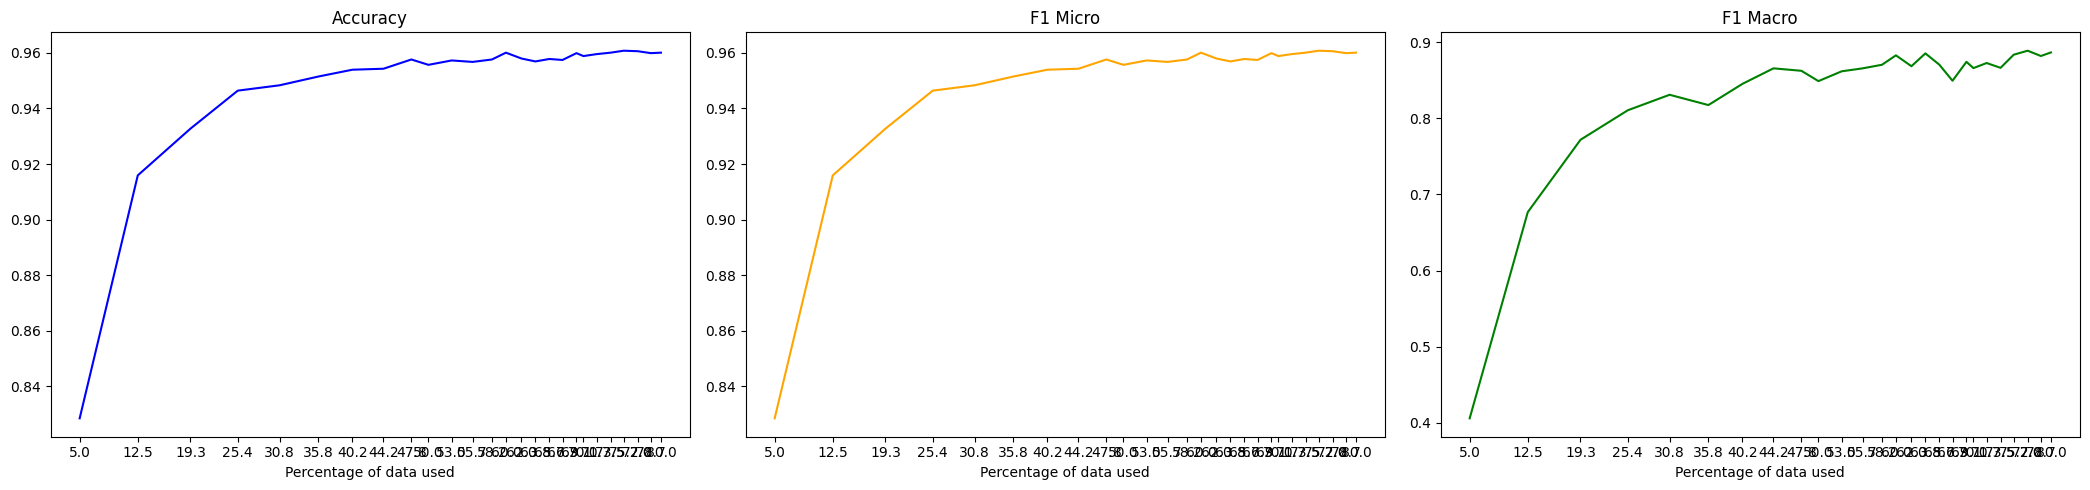

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6072, Accuracy: 0.7955, F1 Micro: 0.8818, F1 Macro: 0.8546
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4916, Accuracy: 0.8016, F1 Micro: 0.8877, F1 Macro: 0.8774
Epoch 3/10, Train Loss: 0.453, Accuracy: 0.8024, F1 Micro: 0.8857, F1 Macro: 0.8609
Epoch 4/10, Train Loss: 0.4515, Accuracy: 0.8021, F1 Micro: 0.8849, F1 Macro: 0.8543
Epoch 5/10, Train Loss: 0.417, Accuracy: 0.8047, F1 Micro: 0.8868, F1 Macro: 0.862
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4402, Accuracy: 0.8092, F1 Micro: 0.8902, F1 Macro: 0.874
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3799, Accuracy: 0.8141, F1 Micro: 0.8937, F1 Macro: 0.8828
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3851, Accuracy: 0.8252, F1 Micro: 0.899, F1 Macro: 0.8873
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3532, Accuracy: 0.8361, F1 Micro: 0.9044, F1 Macro: 0.8918
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5988, Accuracy: 0.6204, F1 Micro: 0.6204, F1 Macro: 0.3829
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5281, Accuracy: 0.6204, F1 Micro: 0.6204, F1 Macro: 0.3829
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4888, Accuracy: 0.6259, F1 Micro: 0.6259, F1 Macro: 0.4027
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3707, Accuracy: 0.6861, F1 Micro: 0.6861, F1 Macro: 0.5752
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3492, Accuracy: 0.7336, F1 Micro: 0.7336, F1 Macro: 0.6917
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2739, Accuracy: 0.7372, F1 Micro: 0.7372, F1 Macro: 0.7005
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3739, Accuracy: 0.7409, F1 Micro: 0.7409, F1 Macro: 0.7103
Epoch 8/10, Train Loss: 0.2974, Accuracy: 0.7281, F1 Micro: 0.7281, F1 Macro: 0.6718
Epoch 9/10, Train Loss: 0.18, Accuracy: 0.7372, F1 Micro: 0.7372, F1 Macro: 0.703
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5314, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4493, Accuracy: 0.8023, F1 Micro: 0.89, F1 Macro: 0.8855
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4553, Accuracy: 0.8023, F1 Micro: 0.8901, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4105, Accuracy: 0.8292, F1 Micro: 0.9024, F1 Macro: 0.8957
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3713, Accuracy: 0.8648, F1 Micro: 0.9209, F1 Macro: 0.9151
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3131, Accuracy: 0.8901, F1 Micro: 0.9349, F1 Macro: 0.9299
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2667, Accuracy: 0.9007, F1 Micro: 0.941, F1 Macro: 0.9373
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2209, Accuracy: 0.9184, F1 Micro: 0.9508, F1 Macro: 0.9472
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5184, Accuracy: 0.7526, F1 Micro: 0.7526, F1 Macro: 0.4294
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3482, Accuracy: 0.8077, F1 Micro: 0.8077, F1 Macro: 0.7113
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2982, Accuracy: 0.8288, F1 Micro: 0.8288, F1 Macro: 0.7591
Epoch 4/10, Train Loss: 0.2482, Accuracy: 0.8195, F1 Micro: 0.8195, F1 Macro: 0.7669
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2206, Accuracy: 0.8593, F1 Micro: 0.8593, F1 Macro: 0.7991
Epoch 6/10, Train Loss: 0.1836, Accuracy: 0.8558, F1 Micro: 0.8558, F1 Macro: 0.7882
Epoch 7/10, Train Loss: 0.1881, Accuracy: 0.8535, F1 Micro: 0.8535, F1 Macro: 0.7719
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.137, Accuracy: 0.8652, F1 Micro: 0.8652, F1 Macro: 0.7929
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.14, Accuracy: 0.8722, F1 Micro: 0.8722, F1 Macro: 0.8217
Epoch 10/10, Train Loss: 0.1166, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5258, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4572, Accuracy: 0.8057, F1 Micro: 0.8916, F1 Macro: 0.8865
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4114, Accuracy: 0.8365, F1 Micro: 0.9052, F1 Macro: 0.8971
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3594, Accuracy: 0.8724, F1 Micro: 0.9254, F1 Macro: 0.9208
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2928, Accuracy: 0.9137, F1 Micro: 0.9481, F1 Macro: 0.944
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2578, Accuracy: 0.9365, F1 Micro: 0.9611, F1 Macro: 0.9582
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2054, Accuracy: 0.9365, F1 Micro: 0.9613, F1 Macro: 0.9585
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.181, Accuracy: 0.9399, F1 Micro: 0.9632, F1 Macro: 0.9604
Higher F1 achieved, saving model
Epoch 9/1

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5244, Accuracy: 0.7766, F1 Micro: 0.7766, F1 Macro: 0.6806
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3685, Accuracy: 0.8297, F1 Micro: 0.8297, F1 Macro: 0.753
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3074, Accuracy: 0.8567, F1 Micro: 0.8567, F1 Macro: 0.8095
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2486, Accuracy: 0.8617, F1 Micro: 0.8617, F1 Macro: 0.8096
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.208, Accuracy: 0.8758, F1 Micro: 0.8758, F1 Macro: 0.8269
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1544, Accuracy: 0.8828, F1 Micro: 0.8828, F1 Macro: 0.8393
Epoch 7/10, Train Loss: 0.1157, Accuracy: 0.8818, F1 Micro: 0.8818, F1 Macro: 0.8285
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0961, Accuracy: 0.8938, F1 Micro: 0.8938, F1 Macro: 0.8622
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0706, Accuracy: 0.8978, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5024, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4555, Accuracy: 0.8339, F1 Micro: 0.9052, F1 Macro: 0.8998
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3845, Accuracy: 0.8776, F1 Micro: 0.928, F1 Macro: 0.923
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3034, Accuracy: 0.9139, F1 Micro: 0.9482, F1 Macro: 0.9445
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2441, Accuracy: 0.9333, F1 Micro: 0.9595, F1 Macro: 0.9568
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2043, Accuracy: 0.9392, F1 Micro: 0.9628, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1699, Accuracy: 0.9457, F1 Micro: 0.9667, F1 Macro: 0.9643
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1516, Accuracy: 0.9488, F1 Micro: 0.9686, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5085, Accuracy: 0.7966, F1 Micro: 0.7966, F1 Macro: 0.7445
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3699, Accuracy: 0.8554, F1 Micro: 0.8554, F1 Macro: 0.7988
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2921, Accuracy: 0.8584, F1 Micro: 0.8584, F1 Macro: 0.7985
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2265, Accuracy: 0.8903, F1 Micro: 0.8903, F1 Macro: 0.8572
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.181, Accuracy: 0.8973, F1 Micro: 0.8973, F1 Macro: 0.8644
Epoch 6/10, Train Loss: 0.1058, Accuracy: 0.8933, F1 Micro: 0.8933, F1 Macro: 0.8602
Epoch 7/10, Train Loss: 0.0917, Accuracy: 0.8953, F1 Micro: 0.8953, F1 Macro: 0.8628
Epoch 8/10, Train Loss: 0.1032, Accuracy: 0.8953, F1 Micro: 0.8953, F1 Macro: 0.8642
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0638, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.8631
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5067, Accuracy: 0.8012, F1 Micro: 0.8842, F1 Macro: 0.8509
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4547, Accuracy: 0.8349, F1 Micro: 0.9057, F1 Macro: 0.8999
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3639, Accuracy: 0.9078, F1 Micro: 0.9444, F1 Macro: 0.9383
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.282, Accuracy: 0.929, F1 Micro: 0.957, F1 Macro: 0.9539
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2209, Accuracy: 0.9425, F1 Micro: 0.9648, F1 Macro: 0.9618
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1897, Accuracy: 0.9455, F1 Micro: 0.9666, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1602, Accuracy: 0.9493, F1 Micro: 0.9689, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1377, Accuracy: 0.9528, F1 Micro: 0.9709, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4888, Accuracy: 0.8476, F1 Micro: 0.8476, F1 Macro: 0.7948
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3273, Accuracy: 0.883, F1 Micro: 0.883, F1 Macro: 0.8416
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2405, Accuracy: 0.8948, F1 Micro: 0.8948, F1 Macro: 0.8609
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1893, Accuracy: 0.9036, F1 Micro: 0.9036, F1 Macro: 0.8737
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1909, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.8913
Epoch 6/10, Train Loss: 0.146, Accuracy: 0.9086, F1 Micro: 0.9086, F1 Macro: 0.8772
Epoch 7/10, Train Loss: 0.0679, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.8869
Epoch 8/10, Train Loss: 0.0746, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0375, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.8878
Epoch 10/10, Train Loss: 0.0359, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4927, Accuracy: 0.8052, F1 Micro: 0.8914, F1 Macro: 0.8867
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4399, Accuracy: 0.8752, F1 Micro: 0.9264, F1 Macro: 0.9207
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3252, Accuracy: 0.9233, F1 Micro: 0.9535, F1 Macro: 0.9495
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2414, Accuracy: 0.9398, F1 Micro: 0.9632, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2047, Accuracy: 0.9479, F1 Micro: 0.9681, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1714, Accuracy: 0.9547, F1 Micro: 0.972, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1513, Accuracy: 0.9554, F1 Micro: 0.9724, F1 Macro: 0.97
Epoch 8/10, Train Loss: 0.1222, Accuracy: 0.955, F1 Micro: 0.9722, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1096, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4763, Accuracy: 0.8248, F1 Micro: 0.8248, F1 Macro: 0.7799
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3258, Accuracy: 0.8665, F1 Micro: 0.8665, F1 Macro: 0.8185
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.25, Accuracy: 0.893, F1 Micro: 0.893, F1 Macro: 0.8653
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1765, Accuracy: 0.9025, F1 Micro: 0.9025, F1 Macro: 0.875
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1322, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8798
Epoch 6/10, Train Loss: 0.0834, Accuracy: 0.9025, F1 Micro: 0.9025, F1 Macro: 0.8717
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.9053, F1 Micro: 0.9053, F1 Macro: 0.8756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0514, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8785
Epoch 9/10, Train Loss: 0.0573, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.8733
Epoch 10/10, Train Loss: 0.0348, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.494, Accuracy: 0.8149, F1 Micro: 0.894, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4018, Accuracy: 0.8932, F1 Micro: 0.9367, F1 Macro: 0.9324
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2896, Accuracy: 0.9349, F1 Micro: 0.9604, F1 Macro: 0.9574
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2261, Accuracy: 0.9413, F1 Micro: 0.9641, F1 Macro: 0.9615
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1924, Accuracy: 0.9497, F1 Micro: 0.969, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1629, Accuracy: 0.951, F1 Micro: 0.9699, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1368, Accuracy: 0.9564, F1 Micro: 0.973, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1183, Accuracy: 0.9585, F1 Micro: 0.9743, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4834, Accuracy: 0.8221, F1 Micro: 0.8221, F1 Macro: 0.7901
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3155, Accuracy: 0.8664, F1 Micro: 0.8664, F1 Macro: 0.8296
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2431, Accuracy: 0.8922, F1 Micro: 0.8922, F1 Macro: 0.8594
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1603, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8789
Epoch 5/10, Train Loss: 0.1159, Accuracy: 0.8876, F1 Micro: 0.8876, F1 Macro: 0.8489
Epoch 6/10, Train Loss: 0.0941, Accuracy: 0.9032, F1 Micro: 0.9032, F1 Macro: 0.8732
Epoch 7/10, Train Loss: 0.0731, Accuracy: 0.8995, F1 Micro: 0.8995, F1 Macro: 0.8702
Epoch 8/10, Train Loss: 0.0496, Accuracy: 0.9032, F1 Micro: 0.9032, F1 Macro: 0.8749
Epoch 9/10, Train Loss: 0.051, Accuracy: 0.894, F1 Micro: 0.894, F1 Macro: 0.866
Epoch 10/10, Train Loss: 0.0581, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8753

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4933, Accuracy: 0.803, F1 Micro: 0.8905, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.388, Accuracy: 0.9014, F1 Micro: 0.9412, F1 Macro: 0.9366
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2745, Accuracy: 0.9424, F1 Micro: 0.9645, F1 Macro: 0.9615
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2153, Accuracy: 0.9451, F1 Micro: 0.9664, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1796, Accuracy: 0.95, F1 Micro: 0.9693, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.155, Accuracy: 0.9531, F1 Micro: 0.9711, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1304, Accuracy: 0.9563, F1 Micro: 0.9729, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1138, Accuracy: 0.9582, F1 Micro: 0.9742, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 9/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4476, Accuracy: 0.8598, F1 Micro: 0.8598, F1 Macro: 0.8084
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3013, Accuracy: 0.8847, F1 Micro: 0.8847, F1 Macro: 0.8438
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2117, Accuracy: 0.9001, F1 Micro: 0.9001, F1 Macro: 0.8624
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1573, Accuracy: 0.9126, F1 Micro: 0.9126, F1 Macro: 0.8858
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8791
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0902, Accuracy: 0.9155, F1 Micro: 0.9155, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0795, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.892
Epoch 8/10, Train Loss: 0.0556, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.8858
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0434, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.8909
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4848, Accuracy: 0.8148, F1 Micro: 0.8958, F1 Macro: 0.8903
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3706, Accuracy: 0.9122, F1 Micro: 0.947, F1 Macro: 0.9429
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2601, Accuracy: 0.9439, F1 Micro: 0.9655, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2106, Accuracy: 0.9472, F1 Micro: 0.9677, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1686, Accuracy: 0.9516, F1 Micro: 0.9703, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1412, Accuracy: 0.9559, F1 Micro: 0.9727, F1 Macro: 0.9704
Epoch 7/10, Train Loss: 0.121, Accuracy: 0.9547, F1 Micro: 0.9721, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1038, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.088, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4364, Accuracy: 0.8748, F1 Micro: 0.8748, F1 Macro: 0.8315
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2883, Accuracy: 0.8937, F1 Micro: 0.8937, F1 Macro: 0.8589
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2005, Accuracy: 0.8956, F1 Micro: 0.8956, F1 Macro: 0.8589
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1652, Accuracy: 0.9156, F1 Micro: 0.9156, F1 Macro: 0.8896
Epoch 5/10, Train Loss: 0.1082, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8824
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0814, Accuracy: 0.9175, F1 Micro: 0.9175, F1 Macro: 0.8905
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0647, Accuracy: 0.9203, F1 Micro: 0.9203, F1 Macro: 0.8952
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.8993
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.9231, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4927, Accuracy: 0.8243, F1 Micro: 0.9001, F1 Macro: 0.8939
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.359, Accuracy: 0.9214, F1 Micro: 0.9522, F1 Macro: 0.9474
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.244, Accuracy: 0.9425, F1 Micro: 0.9648, F1 Macro: 0.9619
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1985, Accuracy: 0.9495, F1 Micro: 0.969, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1643, Accuracy: 0.9507, F1 Micro: 0.9697, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1395, Accuracy: 0.9569, F1 Micro: 0.9733, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1183, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0964, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9744
Epoch 9/10, Train Loss: 0.089, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4185, Accuracy: 0.8239, F1 Micro: 0.8239, F1 Macro: 0.7931
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2698, Accuracy: 0.8768, F1 Micro: 0.8768, F1 Macro: 0.8343
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2015, Accuracy: 0.8978, F1 Micro: 0.8978, F1 Macro: 0.8718
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1377, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8662
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.088, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.8768
Epoch 6/10, Train Loss: 0.0632, Accuracy: 0.9005, F1 Micro: 0.9005, F1 Macro: 0.8724
Epoch 7/10, Train Loss: 0.0647, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.8791
Epoch 8/10, Train Loss: 0.0363, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.878
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0389, Accuracy: 0.9078, F1 Micro: 0.9078, F1 Macro: 0.8804
Epoch 10/10, Train Loss: 0.0258, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4801, Accuracy: 0.8328, F1 Micro: 0.9051, F1 Macro: 0.9004
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3443, Accuracy: 0.9252, F1 Micro: 0.9545, F1 Macro: 0.9505
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2393, Accuracy: 0.9444, F1 Micro: 0.9661, F1 Macro: 0.964
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1879, Accuracy: 0.9505, F1 Micro: 0.9697, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1558, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1325, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1101, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9743
Epoch 8/10, Train Loss: 0.0962, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0819, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4076, Accuracy: 0.845, F1 Micro: 0.845, F1 Macro: 0.7804
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2782, Accuracy: 0.8881, F1 Micro: 0.8881, F1 Macro: 0.8551
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1891, Accuracy: 0.9009, F1 Micro: 0.9009, F1 Macro: 0.8745
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1416, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8776
Epoch 5/10, Train Loss: 0.1007, Accuracy: 0.9046, F1 Micro: 0.9046, F1 Macro: 0.877
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0744, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8873
Epoch 7/10, Train Loss: 0.0673, Accuracy: 0.9046, F1 Micro: 0.9046, F1 Macro: 0.8794
Epoch 8/10, Train Loss: 0.0527, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8794
Epoch 9/10, Train Loss: 0.0308, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0288, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4748, Accuracy: 0.8368, F1 Micro: 0.9066, F1 Macro: 0.901
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3413, Accuracy: 0.9266, F1 Micro: 0.9554, F1 Macro: 0.9522
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2389, Accuracy: 0.9467, F1 Micro: 0.9673, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1842, Accuracy: 0.9505, F1 Micro: 0.9697, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1546, Accuracy: 0.9552, F1 Micro: 0.9724, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1323, Accuracy: 0.9582, F1 Micro: 0.9741, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1117, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0964, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.0817, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4362, Accuracy: 0.8627, F1 Micro: 0.8627, F1 Macro: 0.8147
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2809, Accuracy: 0.9014, F1 Micro: 0.9014, F1 Macro: 0.8717
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1995, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.8789
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1291, Accuracy: 0.9106, F1 Micro: 0.9106, F1 Macro: 0.8847
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1083, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.8953
Epoch 6/10, Train Loss: 0.0767, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8874
Epoch 7/10, Train Loss: 0.0441, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0496, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.8971
Epoch 9/10, Train Loss: 0.0423, Accuracy: 0.9171, F1 Micro: 0.9171, F1 Macro: 0.8939
Epoch 10/10, Train Loss: 0.0405, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4774, Accuracy: 0.8351, F1 Micro: 0.906, F1 Macro: 0.9007
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3265, Accuracy: 0.9332, F1 Micro: 0.9593, F1 Macro: 0.9565
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.222, Accuracy: 0.9465, F1 Micro: 0.9673, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1807, Accuracy: 0.949, F1 Micro: 0.9688, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1518, Accuracy: 0.9571, F1 Micro: 0.9736, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1261, Accuracy: 0.9601, F1 Micro: 0.9754, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1061, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0891, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3951, Accuracy: 0.866, F1 Micro: 0.866, F1 Macro: 0.829
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2442, Accuracy: 0.8888, F1 Micro: 0.8888, F1 Macro: 0.8523
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1822, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8818
Epoch 4/10, Train Loss: 0.1298, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8789
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1045, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.889
Epoch 6/10, Train Loss: 0.0855, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.8877
Epoch 7/10, Train Loss: 0.0623, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.882
Epoch 8/10, Train Loss: 0.0576, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0558, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.8875
Epoch 10/10, Train Loss: 0.0348, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4741, Accuracy: 0.8458, F1 Micro: 0.9114, F1 Macro: 0.906
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3151, Accuracy: 0.9314, F1 Micro: 0.9582, F1 Macro: 0.9554
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2263, Accuracy: 0.946, F1 Micro: 0.967, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1765, Accuracy: 0.9497, F1 Micro: 0.9691, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.15, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1257, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1033, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0872, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 9/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4105, Accuracy: 0.8654, F1 Micro: 0.8654, F1 Macro: 0.8235
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2315, Accuracy: 0.8986, F1 Micro: 0.8986, F1 Macro: 0.8676
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1598, Accuracy: 0.9032, F1 Micro: 0.9032, F1 Macro: 0.8717
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1135, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8853
Epoch 5/10, Train Loss: 0.0998, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8826
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0566, Accuracy: 0.9152, F1 Micro: 0.9152, F1 Macro: 0.8898
Epoch 7/10, Train Loss: 0.0612, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8773
Epoch 8/10, Train Loss: 0.0384, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.8763
Epoch 9/10, Train Loss: 0.0261, Accuracy: 0.9106, F1 Micro: 0.9106, F1 Macro: 0.8858
Epoch 10/10, Train Loss: 0.0348, Accuracy: 0.9106, F1 Micro: 0.9106, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4702, Accuracy: 0.8625, F1 Micro: 0.9198, F1 Macro: 0.9138
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3049, Accuracy: 0.9332, F1 Micro: 0.9593, F1 Macro: 0.9566
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2131, Accuracy: 0.9474, F1 Micro: 0.9678, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1712, Accuracy: 0.9533, F1 Micro: 0.9713, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.9573, F1 Micro: 0.9737, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1165, Accuracy: 0.9597, F1 Micro: 0.975, F1 Macro: 0.9726
Epoch 7/10, Train Loss: 0.1003, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0851, Accuracy: 0.9656, F1 Micro: 0.9786, F1 Macro: 0.9765
Epoch 9/10, Train Loss: 0.0704, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4325, Accuracy: 0.8605, F1 Micro: 0.8605, F1 Macro: 0.8118
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2572, Accuracy: 0.8961, F1 Micro: 0.8961, F1 Macro: 0.8646
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1702, Accuracy: 0.9025, F1 Micro: 0.9025, F1 Macro: 0.8716
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1261, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8805
Epoch 5/10, Train Loss: 0.1003, Accuracy: 0.9025, F1 Micro: 0.9025, F1 Macro: 0.871
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0698, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.8882
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0559, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.8873
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0408, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.8883
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0332, Accuracy: 0.9134, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4584, Accuracy: 0.8724, F1 Micro: 0.9249, F1 Macro: 0.9186
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2912, Accuracy: 0.9359, F1 Micro: 0.961, F1 Macro: 0.9583
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2106, Accuracy: 0.9486, F1 Micro: 0.9685, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1701, Accuracy: 0.9514, F1 Micro: 0.9701, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1401, Accuracy: 0.9569, F1 Micro: 0.9734, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1172, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0985, Accuracy: 0.9634, F1 Micro: 0.9772, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0823, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3986, Accuracy: 0.8703, F1 Micro: 0.8703, F1 Macro: 0.8367
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2213, Accuracy: 0.8971, F1 Micro: 0.8971, F1 Macro: 0.8614
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1701, Accuracy: 0.9045, F1 Micro: 0.9045, F1 Macro: 0.8714
Epoch 4/10, Train Loss: 0.1194, Accuracy: 0.9036, F1 Micro: 0.9036, F1 Macro: 0.8699
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0803, Accuracy: 0.911, F1 Micro: 0.911, F1 Macro: 0.8837
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0751, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8871
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0541, Accuracy: 0.9194, F1 Micro: 0.9194, F1 Macro: 0.8935
Epoch 8/10, Train Loss: 0.0299, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.8916
Epoch 9/10, Train Loss: 0.0294, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8836
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4617, Accuracy: 0.8734, F1 Micro: 0.9258, F1 Macro: 0.9203
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.289, Accuracy: 0.9339, F1 Micro: 0.9597, F1 Macro: 0.9571
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2047, Accuracy: 0.9451, F1 Micro: 0.9665, F1 Macro: 0.9645
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1678, Accuracy: 0.9531, F1 Micro: 0.9712, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1359, Accuracy: 0.9578, F1 Micro: 0.974, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1147, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0975, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9759
Epoch 8/10, Train Loss: 0.0808, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9749
Epoch 9/10, Train Loss: 0.0664, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9743
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3885, Accuracy: 0.8581, F1 Micro: 0.8581, F1 Macro: 0.8035
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2271, Accuracy: 0.8899, F1 Micro: 0.8899, F1 Macro: 0.8531
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1474, Accuracy: 0.9063, F1 Micro: 0.9063, F1 Macro: 0.8792
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1112, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8818
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0837, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0675, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.886
Epoch 7/10, Train Loss: 0.0427, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8818
Epoch 8/10, Train Loss: 0.0373, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.885
Epoch 9/10, Train Loss: 0.0176, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8812
Epoch 10/10, Train Loss: 0.0166, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4582, Accuracy: 0.8766, F1 Micro: 0.9274, F1 Macro: 0.9217
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2845, Accuracy: 0.9363, F1 Micro: 0.9612, F1 Macro: 0.9587
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2032, Accuracy: 0.9519, F1 Micro: 0.9705, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1625, Accuracy: 0.9542, F1 Micro: 0.9718, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1349, Accuracy: 0.9582, F1 Micro: 0.9742, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1132, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0937, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0758, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9762
Epoch 9/10, Train Loss: 0.0663, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3704, Accuracy: 0.8737, F1 Micro: 0.8737, F1 Macro: 0.8288
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2019, Accuracy: 0.8968, F1 Micro: 0.8968, F1 Macro: 0.8602
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.144, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.8766
Epoch 4/10, Train Loss: 0.1108, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.88
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0754, Accuracy: 0.9106, F1 Micro: 0.9106, F1 Macro: 0.8829
Epoch 6/10, Train Loss: 0.0548, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8807
Epoch 7/10, Train Loss: 0.0385, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8826
Epoch 8/10, Train Loss: 0.0325, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.877
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.031, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.8959
Epoch 10/10, Train Loss: 0.0149, Accuracy: 0.9143, F1 Micro: 0.9143, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4521, Accuracy: 0.879, F1 Micro: 0.9284, F1 Macro: 0.922
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2782, Accuracy: 0.9384, F1 Micro: 0.9624, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2022, Accuracy: 0.9477, F1 Micro: 0.968, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1629, Accuracy: 0.954, F1 Micro: 0.9716, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1347, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1148, Accuracy: 0.9637, F1 Micro: 0.9776, F1 Macro: 0.9757
Epoch 7/10, Train Loss: 0.0925, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0762, Accuracy: 0.9651, F1 Micro: 0.9784, F1 Macro: 0.9762
Epoch 9/10, Train Loss: 0.0668, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3762, Accuracy: 0.8725, F1 Micro: 0.8725, F1 Macro: 0.8205
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1919, Accuracy: 0.9039, F1 Micro: 0.9039, F1 Macro: 0.8744
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1392, Accuracy: 0.9104, F1 Micro: 0.9104, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0952, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.8843
Epoch 5/10, Train Loss: 0.0726, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.8744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0522, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.8838
Epoch 7/10, Train Loss: 0.0416, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.8692
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.029, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.8838
Epoch 9/10, Train Loss: 0.0248, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.88
Epoch 10/10, Train Loss: 0.0307, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4542, Accuracy: 0.88, F1 Micro: 0.9294, F1 Macro: 0.9243
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2791, Accuracy: 0.9411, F1 Micro: 0.9641, F1 Macro: 0.9619
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1928, Accuracy: 0.9488, F1 Micro: 0.9686, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1543, Accuracy: 0.9517, F1 Micro: 0.9704, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1325, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1091, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0907, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9752
Epoch 8/10, Train Loss: 0.0722, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9747
Epoch 9/10, Train Loss: 0.062, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3515, Accuracy: 0.8711, F1 Micro: 0.8711, F1 Macro: 0.8249
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2274, Accuracy: 0.8984, F1 Micro: 0.8984, F1 Macro: 0.8706
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1673, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8803
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1026, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.8899
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0891, Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.8933
Epoch 6/10, Train Loss: 0.0613, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.8839
Epoch 7/10, Train Loss: 0.0462, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.8797
Epoch 8/10, Train Loss: 0.035, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.8886
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0378, Accuracy: 0.9247, F1 Micro: 0.9247, F1 Macro: 0.8992
Epoch 10/10, Train Loss: 0.021, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4579, Accuracy: 0.8868, F1 Micro: 0.9329, F1 Macro: 0.9278
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2722, Accuracy: 0.9411, F1 Micro: 0.9641, F1 Macro: 0.9618
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1944, Accuracy: 0.9521, F1 Micro: 0.9705, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1541, Accuracy: 0.9549, F1 Micro: 0.9722, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1292, Accuracy: 0.9606, F1 Micro: 0.9757, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1083, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0891, Accuracy: 0.9658, F1 Micro: 0.9788, F1 Macro: 0.9767
Epoch 8/10, Train Loss: 0.0738, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9753
Epoch 9/10, Train Loss: 0.0628, Accuracy: 0.9628, F1 Micro: 0.977, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3601, Accuracy: 0.8801, F1 Micro: 0.8801, F1 Macro: 0.8449
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1957, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8855
Epoch 3/10, Train Loss: 0.1371, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8733
Epoch 4/10, Train Loss: 0.1029, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.8756
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0702, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8866
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0516, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.8922
Epoch 7/10, Train Loss: 0.037, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8863
Epoch 8/10, Train Loss: 0.0377, Accuracy: 0.9133, F1 Micro: 0.9133, F1 Macro: 0.8874
Epoch 9/10, Train Loss: 0.0256, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.8807
Epoch 10/10, Train Loss: 0.0294, Accuracy: 0.9096, F1 Micro: 0.9096, F1 Macro: 0.8806

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4467, Accuracy: 0.8882, F1 Micro: 0.9338, F1 Macro: 0.9289
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.261, Accuracy: 0.9441, F1 Micro: 0.9658, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1889, Accuracy: 0.9533, F1 Micro: 0.9713, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1493, Accuracy: 0.9564, F1 Micro: 0.9732, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1225, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1021, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9763
Epoch 7/10, Train Loss: 0.0863, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9756
Epoch 8/10, Train Loss: 0.0718, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0593, Accuracy: 0.9656, F1 Micro: 0.9787, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3592, Accuracy: 0.8635, F1 Micro: 0.8635, F1 Macro: 0.8157
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2081, Accuracy: 0.8987, F1 Micro: 0.8987, F1 Macro: 0.8697
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1209, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8839
Epoch 4/10, Train Loss: 0.0907, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8779
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0683, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.8868
Epoch 6/10, Train Loss: 0.0502, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8862
Epoch 7/10, Train Loss: 0.0362, Accuracy: 0.9078, F1 Micro: 0.9078, F1 Macro: 0.8806
Epoch 8/10, Train Loss: 0.036, Accuracy: 0.9005, F1 Micro: 0.9005, F1 Macro: 0.8726
Epoch 9/10, Train Loss: 0.0259, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8845
Epoch 10/10, Train Loss: 0.0329, Accuracy: 0.9123, F1 Micro: 0.9123, F1 Macro: 0.886

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4396, Accuracy: 0.8918, F1 Micro: 0.9355, F1 Macro: 0.9296
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2574, Accuracy: 0.9429, F1 Micro: 0.965, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1843, Accuracy: 0.9497, F1 Micro: 0.9691, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.153, Accuracy: 0.9569, F1 Micro: 0.9734, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1197, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.102, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0829, Accuracy: 0.9663, F1 Micro: 0.9791, F1 Macro: 0.9771
Epoch 8/10, Train Loss: 0.0716, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0564, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3642, Accuracy: 0.8813, F1 Micro: 0.8813, F1 Macro: 0.8409
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1864, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8785
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1397, Accuracy: 0.914, F1 Micro: 0.914, F1 Macro: 0.8866
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0885, Accuracy: 0.9168, F1 Micro: 0.9168, F1 Macro: 0.8927
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0572, Accuracy: 0.9262, F1 Micro: 0.9262, F1 Macro: 0.9035
Epoch 6/10, Train Loss: 0.0477, Accuracy: 0.914, F1 Micro: 0.914, F1 Macro: 0.884
Epoch 7/10, Train Loss: 0.0407, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.8984
Epoch 8/10, Train Loss: 0.0306, Accuracy: 0.9196, F1 Micro: 0.9196, F1 Macro: 0.8948
Epoch 9/10, Train Loss: 0.0283, Accuracy: 0.9206, F1 Micro: 0.9206, F1 Macro: 0.8946
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0274, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4391, Accuracy: 0.8802, F1 Micro: 0.9297, F1 Macro: 0.925
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2607, Accuracy: 0.9443, F1 Micro: 0.9658, F1 Macro: 0.9637
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1823, Accuracy: 0.9523, F1 Micro: 0.9706, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1507, Accuracy: 0.9569, F1 Micro: 0.9735, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1219, Accuracy: 0.9613, F1 Micro: 0.9761, F1 Macro: 0.9741
Epoch 6/10, Train Loss: 0.0982, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0823, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0715, Accuracy: 0.9644, F1 Micro: 0.9778, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0588, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3487, Accuracy: 0.8731, F1 Micro: 0.8731, F1 Macro: 0.8379
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1891, Accuracy: 0.9014, F1 Micro: 0.9014, F1 Macro: 0.8734
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.132, Accuracy: 0.9032, F1 Micro: 0.9032, F1 Macro: 0.8731
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.099, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.8806
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0678, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.8817
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0537, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8843
Epoch 7/10, Train Loss: 0.0373, Accuracy: 0.9078, F1 Micro: 0.9078, F1 Macro: 0.8778
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0325, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.888
Epoch 9/10, Train Loss: 0.0234, Accuracy: 0.9123, F1 Micro: 0.9123, F1 Macro: 0.8869
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4275, Accuracy: 0.8925, F1 Micro: 0.9363, F1 Macro: 0.9317
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2462, Accuracy: 0.9384, F1 Micro: 0.9625, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1808, Accuracy: 0.9526, F1 Micro: 0.9708, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1427, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1151, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0964, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9761
Epoch 7/10, Train Loss: 0.082, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 0.976
Epoch 9/10, Train Loss: 0.053, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3271, Accuracy: 0.8672, F1 Micro: 0.8672, F1 Macro: 0.83
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1778, Accuracy: 0.8943, F1 Micro: 0.8943, F1 Macro: 0.8616
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1258, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8741
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0913, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8899
Epoch 5/10, Train Loss: 0.0689, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.876
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0543, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.8907
Epoch 7/10, Train Loss: 0.0376, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8835
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0344, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.8914
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0298, Accuracy: 0.9178, F1 Micro: 0.9178, F1 Macro: 0.8936
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4263, Accuracy: 0.8967, F1 Micro: 0.9383, F1 Macro: 0.9335
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2428, Accuracy: 0.9444, F1 Micro: 0.9659, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1784, Accuracy: 0.9502, F1 Micro: 0.9694, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1372, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1131, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0946, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0797, Accuracy: 0.9661, F1 Micro: 0.9789, F1 Macro: 0.9768
Epoch 8/10, Train Loss: 0.0652, Accuracy: 0.9646, F1 Micro: 0.9781, F1 Macro: 0.976
Epoch 9/10, Train Loss: 0.0553, Accuracy: 0.9658, F1 Micro: 0.9788, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3529, Accuracy: 0.8705, F1 Micro: 0.8705, F1 Macro: 0.8344
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2105, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8671
Epoch 3/10, Train Loss: 0.1487, Accuracy: 0.894, F1 Micro: 0.894, F1 Macro: 0.8571
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1331, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.8775
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0914, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.8867
Epoch 6/10, Train Loss: 0.0533, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.8768
Epoch 7/10, Train Loss: 0.0665, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8715
Epoch 8/10, Train Loss: 0.0495, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.8833
Epoch 9/10, Train Loss: 0.0441, Accuracy: 0.8976, F1 Micro: 0.8976, F1 Macro: 0.8606
Epoch 10/10, Train Loss: 0.0385, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.883

Sentiment analysis ac

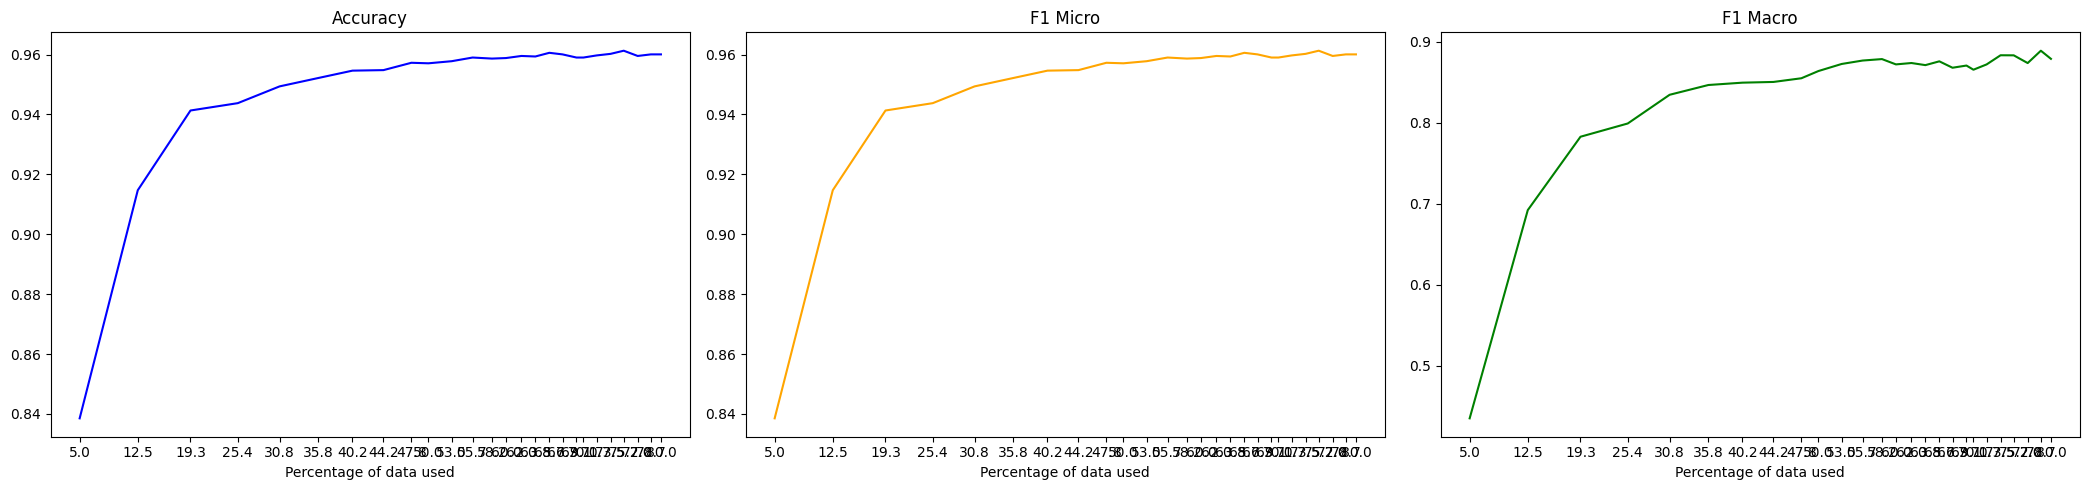

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6222, Accuracy: 0.7984, F1 Micro: 0.8875, F1 Macro: 0.8819
Epoch 2/10, Train Loss: 0.4944, Accuracy: 0.7981, F1 Micro: 0.8873, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4566, Accuracy: 0.7997, F1 Micro: 0.8881, F1 Macro: 0.8821
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4288, Accuracy: 0.8017, F1 Micro: 0.8893, F1 Macro: 0.8836
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4243, Accuracy: 0.804, F1 Micro: 0.8907, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4161, Accuracy: 0.8135, F1 Micro: 0.8944, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4005, Accuracy: 0.8179, F1 Micro: 0.8965, F1 Macro: 0.8903
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3794, Accuracy: 0.8247, F1 Micro: 0.9001, F1 Macro: 0.8939
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3213, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5506, Accuracy: 0.6036, F1 Micro: 0.6036, F1 Macro: 0.3764
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4796, Accuracy: 0.6036, F1 Micro: 0.6036, F1 Macro: 0.3764
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4879, Accuracy: 0.6036, F1 Micro: 0.6036, F1 Macro: 0.3764
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4287, Accuracy: 0.6036, F1 Micro: 0.6036, F1 Macro: 0.3764
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3515, Accuracy: 0.6036, F1 Micro: 0.6036, F1 Macro: 0.3849
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3279, Accuracy: 0.7, F1 Micro: 0.7, F1 Macro: 0.6242
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2793, Accuracy: 0.7073, F1 Micro: 0.7073, F1 Macro: 0.6432
Epoch 8/10, Train Loss: 0.202, Accuracy: 0.6873, F1 Micro: 0.6873, F1 Macro: 0.6008
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2003, Accuracy: 0.7309, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5618, Accuracy: 0.7991, F1 Micro: 0.8882, F1 Macro: 0.8831


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4795, Accuracy: 0.8033, F1 Micro: 0.8901, F1 Macro: 0.8845
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4507, Accuracy: 0.8057, F1 Micro: 0.8915, F1 Macro: 0.8866
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4151, Accuracy: 0.8222, F1 Micro: 0.8984, F1 Macro: 0.8904
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3779, Accuracy: 0.8476, F1 Micro: 0.9113, F1 Macro: 0.9054
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3209, Accuracy: 0.8641, F1 Micro: 0.92, F1 Macro: 0.9138
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.278, Accuracy: 0.884, F1 Micro: 0.9316, F1 Macro: 0.9276
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.242, Accuracy: 0.8995, F1 Micro: 0.9401, F1 Macro: 0.9361
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2207, Accuracy: 0.9137, F1 Micro: 0.948, F1 Macro: 0.9442
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.18

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5245, Accuracy: 0.7211, F1 Micro: 0.7211, F1 Macro: 0.419
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4352, Accuracy: 0.7211, F1 Micro: 0.7211, F1 Macro: 0.419
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3539, Accuracy: 0.7794, F1 Micro: 0.7794, F1 Macro: 0.6516
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2804, Accuracy: 0.7874, F1 Micro: 0.7874, F1 Macro: 0.6426
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2862, Accuracy: 0.8251, F1 Micro: 0.8251, F1 Macro: 0.7453
Epoch 6/10, Train Loss: 0.2358, Accuracy: 0.8229, F1 Micro: 0.8229, F1 Macro: 0.7349
Epoch 7/10, Train Loss: 0.1829, Accuracy: 0.8229, F1 Micro: 0.8229, F1 Macro: 0.7349
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1346, Accuracy: 0.8423, F1 Micro: 0.8423, F1 Macro: 0.7892
Epoch 9/10, Train Loss: 0.1724, Accuracy: 0.7874, F1 Micro: 0.7874, F1 Macro: 0.6391
Epoch 10/10, Train Loss: 0.1312, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5352, Accuracy: 0.8009, F1 Micro: 0.8894, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4729, Accuracy: 0.8042, F1 Micro: 0.8907, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4259, Accuracy: 0.8323, F1 Micro: 0.9044, F1 Macro: 0.8989
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3687, Accuracy: 0.8898, F1 Micro: 0.9344, F1 Macro: 0.9292
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.309, Accuracy: 0.9075, F1 Micro: 0.9447, F1 Macro: 0.9408
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2509, Accuracy: 0.9222, F1 Micro: 0.953, F1 Macro: 0.9497
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2196, Accuracy: 0.9328, F1 Micro: 0.959, F1 Macro: 0.9553
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1921, Accuracy: 0.937, F1 Micro: 0.9616, F1 Macro: 0.9582
Epoch 9/10, Train Loss: 0.158, Accuracy: 0.9

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.538, Accuracy: 0.7152, F1 Micro: 0.7152, F1 Macro: 0.417
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3689, Accuracy: 0.8501, F1 Micro: 0.8501, F1 Macro: 0.7987
Epoch 3/10, Train Loss: 0.2632, Accuracy: 0.848, F1 Micro: 0.848, F1 Macro: 0.7834
Epoch 4/10, Train Loss: 0.235, Accuracy: 0.8458, F1 Micro: 0.8458, F1 Macro: 0.7773
Epoch 5/10, Train Loss: 0.1788, Accuracy: 0.8415, F1 Micro: 0.8415, F1 Macro: 0.7688
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1633, Accuracy: 0.863, F1 Micro: 0.863, F1 Macro: 0.8079
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1269, Accuracy: 0.8779, F1 Micro: 0.8779, F1 Macro: 0.8351
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1054, Accuracy: 0.8801, F1 Micro: 0.8801, F1 Macro: 0.8421
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0735, Accuracy: 0.8844, F1 Micro: 0.8844, F1 Macro: 0.8429
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5209, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4596, Accuracy: 0.8122, F1 Micro: 0.8946, F1 Macro: 0.8892
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.415, Accuracy: 0.8602, F1 Micro: 0.9192, F1 Macro: 0.9154
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3375, Accuracy: 0.8995, F1 Micro: 0.9402, F1 Macro: 0.9366
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2608, Accuracy: 0.9264, F1 Micro: 0.9555, F1 Macro: 0.9522
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.225, Accuracy: 0.9378, F1 Micro: 0.9621, F1 Macro: 0.9591
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1883, Accuracy: 0.9427, F1 Micro: 0.965, F1 Macro: 0.962
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1594, Accuracy: 0.9427, F1 Micro: 0.965, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5408, Accuracy: 0.8137, F1 Micro: 0.8137, F1 Macro: 0.7256
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3286, Accuracy: 0.8235, F1 Micro: 0.8235, F1 Macro: 0.7434
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2713, Accuracy: 0.8765, F1 Micro: 0.8765, F1 Macro: 0.8435
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1754, Accuracy: 0.8892, F1 Micro: 0.8892, F1 Macro: 0.8579
Epoch 5/10, Train Loss: 0.191, Accuracy: 0.8814, F1 Micro: 0.8814, F1 Macro: 0.8424
Epoch 6/10, Train Loss: 0.1158, Accuracy: 0.8863, F1 Micro: 0.8863, F1 Macro: 0.8492
Epoch 7/10, Train Loss: 0.0905, Accuracy: 0.8833, F1 Micro: 0.8833, F1 Macro: 0.8466
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.086, Accuracy: 0.8971, F1 Micro: 0.8971, F1 Macro: 0.8695
Epoch 9/10, Train Loss: 0.0643, Accuracy: 0.8922, F1 Micro: 0.8922, F1 Macro: 0.8664
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0605, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5181, Accuracy: 0.8007, F1 Micro: 0.8893, F1 Macro: 0.8849
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4496, Accuracy: 0.8288, F1 Micro: 0.9029, F1 Macro: 0.8979
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3692, Accuracy: 0.896, F1 Micro: 0.9381, F1 Macro: 0.9345
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.283, Accuracy: 0.9175, F1 Micro: 0.9503, F1 Macro: 0.9471
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.228, Accuracy: 0.9295, F1 Micro: 0.9574, F1 Macro: 0.9549
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1989, Accuracy: 0.9502, F1 Micro: 0.9693, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1681, Accuracy: 0.9512, F1 Micro: 0.97, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1463, Accuracy: 0.9556, F1 Micro: 0.9725, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5218, Accuracy: 0.8063, F1 Micro: 0.8063, F1 Macro: 0.6851
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3228, Accuracy: 0.8659, F1 Micro: 0.8659, F1 Macro: 0.8105
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.239, Accuracy: 0.8963, F1 Micro: 0.8963, F1 Macro: 0.8675
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.185, Accuracy: 0.911, F1 Micro: 0.911, F1 Macro: 0.8877
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.137, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8871
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1046, Accuracy: 0.9159, F1 Micro: 0.9159, F1 Macro: 0.8915
Epoch 7/10, Train Loss: 0.0996, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0529, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.8961
Epoch 9/10, Train Loss: 0.0437, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.8936
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5154, Accuracy: 0.801, F1 Micro: 0.8894, F1 Macro: 0.8846
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4424, Accuracy: 0.8575, F1 Micro: 0.9174, F1 Macro: 0.9127
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3336, Accuracy: 0.9089, F1 Micro: 0.9455, F1 Macro: 0.9422
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2582, Accuracy: 0.9344, F1 Micro: 0.96, F1 Macro: 0.9568
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2109, Accuracy: 0.9472, F1 Micro: 0.9676, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1775, Accuracy: 0.953, F1 Micro: 0.9709, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1511, Accuracy: 0.9547, F1 Micro: 0.972, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1302, Accuracy: 0.9552, F1 Micro: 0.9723, F1 Macro: 0.9693
Epoch 9/10, Train Loss: 0.1096, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4723, Accuracy: 0.8449, F1 Micro: 0.8449, F1 Macro: 0.7846
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2998, Accuracy: 0.8801, F1 Micro: 0.8801, F1 Macro: 0.8369
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2244, Accuracy: 0.8896, F1 Micro: 0.8896, F1 Macro: 0.8585
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1938, Accuracy: 0.9001, F1 Micro: 0.9001, F1 Macro: 0.8729
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1257, Accuracy: 0.9049, F1 Micro: 0.9049, F1 Macro: 0.8763
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0833, Accuracy: 0.9058, F1 Micro: 0.9058, F1 Macro: 0.8765
Epoch 7/10, Train Loss: 0.0766, Accuracy: 0.9049, F1 Micro: 0.9049, F1 Macro: 0.8739
Epoch 8/10, Train Loss: 0.0478, Accuracy: 0.8963, F1 Micro: 0.8963, F1 Macro: 0.8623
Epoch 9/10, Train Loss: 0.044, Accuracy: 0.9049, F1 Micro: 0.9049, F1 Macro: 0.8774
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5123, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4242, Accuracy: 0.8674, F1 Micro: 0.9222, F1 Macro: 0.916
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3217, Accuracy: 0.925, F1 Micro: 0.9546, F1 Macro: 0.9513
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2437, Accuracy: 0.9325, F1 Micro: 0.9591, F1 Macro: 0.9566
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.195, Accuracy: 0.954, F1 Micro: 0.9716, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1629, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1439, Accuracy: 0.9569, F1 Micro: 0.9734, F1 Macro: 0.9708
Epoch 8/10, Train Loss: 0.1243, Accuracy: 0.9564, F1 Micro: 0.9732, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1065, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4653, Accuracy: 0.854, F1 Micro: 0.854, F1 Macro: 0.8135
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3059, Accuracy: 0.8644, F1 Micro: 0.8644, F1 Macro: 0.8331
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2087, Accuracy: 0.8974, F1 Micro: 0.8974, F1 Macro: 0.8658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1586, Accuracy: 0.8983, F1 Micro: 0.8983, F1 Macro: 0.8662
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1117, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8825
Epoch 6/10, Train Loss: 0.0872, Accuracy: 0.9002, F1 Micro: 0.9002, F1 Macro: 0.869
Epoch 7/10, Train Loss: 0.0541, Accuracy: 0.903, F1 Micro: 0.903, F1 Macro: 0.8747
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.903, F1 Micro: 0.903, F1 Macro: 0.8758
Epoch 9/10, Train Loss: 0.0436, Accuracy: 0.9058, F1 Micro: 0.9058, F1 Macro: 0.8785
Epoch 10/10, Train Loss: 0.0289, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5021, Accuracy: 0.8057, F1 Micro: 0.8916, F1 Macro: 0.8866
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4056, Accuracy: 0.8885, F1 Micro: 0.9332, F1 Macro: 0.9269
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2965, Accuracy: 0.9319, F1 Micro: 0.9585, F1 Macro: 0.9551
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2206, Accuracy: 0.947, F1 Micro: 0.9675, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1785, Accuracy: 0.953, F1 Micro: 0.971, F1 Macro: 0.968
Epoch 6/10, Train Loss: 0.1511, Accuracy: 0.9517, F1 Micro: 0.9703, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1298, Accuracy: 0.9583, F1 Micro: 0.9742, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1091, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0974, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4774, Accuracy: 0.8532, F1 Micro: 0.8532, F1 Macro: 0.7895
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2778, Accuracy: 0.8816, F1 Micro: 0.8816, F1 Macro: 0.8472
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2165, Accuracy: 0.9072, F1 Micro: 0.9072, F1 Macro: 0.8769
Epoch 4/10, Train Loss: 0.1752, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8648
Epoch 5/10, Train Loss: 0.119, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8782
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0964, Accuracy: 0.9148, F1 Micro: 0.9148, F1 Macro: 0.888
Epoch 7/10, Train Loss: 0.0692, Accuracy: 0.9053, F1 Micro: 0.9053, F1 Macro: 0.8756
Epoch 8/10, Train Loss: 0.0556, Accuracy: 0.9025, F1 Micro: 0.9025, F1 Macro: 0.8698
Epoch 9/10, Train Loss: 0.0442, Accuracy: 0.9138, F1 Micro: 0.9138, F1 Macro: 0.8893
Epoch 10/10, Train Loss: 0.0371, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.885

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5037, Accuracy: 0.8142, F1 Micro: 0.893, F1 Macro: 0.8781
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3892, Accuracy: 0.9026, F1 Micro: 0.9418, F1 Macro: 0.9372
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.266, Accuracy: 0.9352, F1 Micro: 0.9607, F1 Macro: 0.9584
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2145, Accuracy: 0.9457, F1 Micro: 0.9668, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.18, Accuracy: 0.9545, F1 Micro: 0.972, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1473, Accuracy: 0.9589, F1 Micro: 0.9745, F1 Macro: 0.9721
Epoch 7/10, Train Loss: 0.1251, Accuracy: 0.9569, F1 Micro: 0.9734, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1083, Accuracy: 0.9608, F1 Micro: 0.9756, F1 Macro: 0.9729
Epoch 9/10, Train Loss: 0.0925, Accuracy: 0.9595, F1 Micro: 0.9749, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4622, Accuracy: 0.8009, F1 Micro: 0.8009, F1 Macro: 0.699
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.291, Accuracy: 0.8733, F1 Micro: 0.8733, F1 Macro: 0.8364
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2223, Accuracy: 0.8733, F1 Micro: 0.8733, F1 Macro: 0.8306
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1752, Accuracy: 0.8968, F1 Micro: 0.8968, F1 Macro: 0.8679
Epoch 5/10, Train Loss: 0.1205, Accuracy: 0.8959, F1 Micro: 0.8959, F1 Macro: 0.8666
Epoch 6/10, Train Loss: 0.0925, Accuracy: 0.8878, F1 Micro: 0.8878, F1 Macro: 0.8534
Epoch 7/10, Train Loss: 0.0719, Accuracy: 0.8932, F1 Micro: 0.8932, F1 Macro: 0.8611
Epoch 8/10, Train Loss: 0.0495, Accuracy: 0.8941, F1 Micro: 0.8941, F1 Macro: 0.8649
Epoch 9/10, Train Loss: 0.0352, Accuracy: 0.8941, F1 Micro: 0.8941, F1 Macro: 0.8671
Epoch 10/10, Train Loss: 0.043, Accuracy: 0.8896, F1 Micro: 0.8896, F1 Macro: 0.8599

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4974, Accuracy: 0.8168, F1 Micro: 0.8968, F1 Macro: 0.8926
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3778, Accuracy: 0.9064, F1 Micro: 0.9442, F1 Macro: 0.9407
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2591, Accuracy: 0.9378, F1 Micro: 0.9622, F1 Macro: 0.9598
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1973, Accuracy: 0.9483, F1 Micro: 0.9683, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1677, Accuracy: 0.9542, F1 Micro: 0.9718, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.137, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1173, Accuracy: 0.9594, F1 Micro: 0.9748, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0983, Accuracy: 0.9608, F1 Micro: 0.9758, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4626, Accuracy: 0.8615, F1 Micro: 0.8615, F1 Macro: 0.8217
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2885, Accuracy: 0.8615, F1 Micro: 0.8615, F1 Macro: 0.8075
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2123, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1384, Accuracy: 0.9203, F1 Micro: 0.9203, F1 Macro: 0.8988
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1107, Accuracy: 0.9203, F1 Micro: 0.9203, F1 Macro: 0.8979
Epoch 6/10, Train Loss: 0.086, Accuracy: 0.9127, F1 Micro: 0.9127, F1 Macro: 0.8879
Epoch 7/10, Train Loss: 0.0648, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8872
Epoch 8/10, Train Loss: 0.047, Accuracy: 0.9184, F1 Micro: 0.9184, F1 Macro: 0.8947
Epoch 9/10, Train Loss: 0.0212, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.8856
Epoch 10/10, Train Loss: 0.0334, Accuracy: 0.9137, F1 Micro: 0.9137, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4929, Accuracy: 0.8236, F1 Micro: 0.9005, F1 Macro: 0.8967
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3558, Accuracy: 0.92, F1 Micro: 0.9515, F1 Macro: 0.9477
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2444, Accuracy: 0.9422, F1 Micro: 0.9647, F1 Macro: 0.9623
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1951, Accuracy: 0.949, F1 Micro: 0.9687, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1611, Accuracy: 0.9589, F1 Micro: 0.9745, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1368, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9736
Epoch 7/10, Train Loss: 0.1125, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.973
Epoch 8/10, Train Loss: 0.0979, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9725
Epoch 9/10, Train Loss: 0.0829, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.9724
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.43, Accuracy: 0.8475, F1 Micro: 0.8475, F1 Macro: 0.8059
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2591, Accuracy: 0.8799, F1 Micro: 0.8799, F1 Macro: 0.8459
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1945, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.8682
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.144, Accuracy: 0.9039, F1 Micro: 0.9039, F1 Macro: 0.8767
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1158, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8791
Epoch 6/10, Train Loss: 0.0748, Accuracy: 0.8983, F1 Micro: 0.8983, F1 Macro: 0.8672
Epoch 7/10, Train Loss: 0.052, Accuracy: 0.8983, F1 Micro: 0.8983, F1 Macro: 0.8702
Epoch 8/10, Train Loss: 0.0463, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.8709
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0415, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8766
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4852, Accuracy: 0.8306, F1 Micro: 0.9029, F1 Macro: 0.8955
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3499, Accuracy: 0.9071, F1 Micro: 0.9446, F1 Macro: 0.941
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2381, Accuracy: 0.945, F1 Micro: 0.9663, F1 Macro: 0.9637
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1873, Accuracy: 0.9554, F1 Micro: 0.9725, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1583, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1356, Accuracy: 0.9595, F1 Micro: 0.9749, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1122, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0953, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9744
Epoch 9/10, Train Loss: 0.0804, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4382, Accuracy: 0.8578, F1 Micro: 0.8578, F1 Macro: 0.8148
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2884, Accuracy: 0.8831, F1 Micro: 0.8831, F1 Macro: 0.8418
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1808, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.8784
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1437, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8789
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0968, Accuracy: 0.9205, F1 Micro: 0.9205, F1 Macro: 0.8963
Epoch 6/10, Train Loss: 0.076, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8852
Epoch 7/10, Train Loss: 0.0489, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.886
Epoch 8/10, Train Loss: 0.0434, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8827
Epoch 9/10, Train Loss: 0.0373, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8807
Epoch 10/10, Train Loss: 0.0426, Accuracy: 0.9111, F1 Micro: 0.9111, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.488, Accuracy: 0.8274, F1 Micro: 0.9021, F1 Macro: 0.898
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3389, Accuracy: 0.92, F1 Micro: 0.9517, F1 Macro: 0.9476
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2382, Accuracy: 0.9448, F1 Micro: 0.9662, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1853, Accuracy: 0.9543, F1 Micro: 0.9718, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1531, Accuracy: 0.9583, F1 Micro: 0.9742, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1307, Accuracy: 0.9602, F1 Micro: 0.9753, F1 Macro: 0.9726
Epoch 7/10, Train Loss: 0.115, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0952, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9737
Epoch 9/10, Train Loss: 0.0807, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3966, Accuracy: 0.8632, F1 Micro: 0.8632, F1 Macro: 0.8237
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2483, Accuracy: 0.8941, F1 Micro: 0.8941, F1 Macro: 0.8661
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1781, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8886
Epoch 4/10, Train Loss: 0.1413, Accuracy: 0.9025, F1 Micro: 0.9025, F1 Macro: 0.8701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0986, Accuracy: 0.9166, F1 Micro: 0.9166, F1 Macro: 0.8919
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0621, Accuracy: 0.9175, F1 Micro: 0.9175, F1 Macro: 0.8935
Epoch 7/10, Train Loss: 0.0629, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8854
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.041, Accuracy: 0.9175, F1 Micro: 0.9175, F1 Macro: 0.8927
Epoch 9/10, Train Loss: 0.043, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8827
Epoch 10/10, Train Loss: 0.0329, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4812, Accuracy: 0.8323, F1 Micro: 0.9043, F1 Macro: 0.8993
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3275, Accuracy: 0.9247, F1 Micro: 0.9545, F1 Macro: 0.9518
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2268, Accuracy: 0.9446, F1 Micro: 0.9661, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1789, Accuracy: 0.9545, F1 Micro: 0.972, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1473, Accuracy: 0.9597, F1 Micro: 0.975, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1255, Accuracy: 0.9608, F1 Micro: 0.9758, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1061, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9748
Epoch 8/10, Train Loss: 0.0875, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0739, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3962, Accuracy: 0.8565, F1 Micro: 0.8565, F1 Macro: 0.8166
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.227, Accuracy: 0.9025, F1 Micro: 0.9025, F1 Macro: 0.874
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.185, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.8874
Epoch 4/10, Train Loss: 0.1263, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8843
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0849, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.8929
Epoch 6/10, Train Loss: 0.064, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.8859
Epoch 7/10, Train Loss: 0.0518, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8816
Epoch 8/10, Train Loss: 0.0415, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.8824
Epoch 9/10, Train Loss: 0.0305, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.8766
Epoch 10/10, Train Loss: 0.0323, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.883

Sentiment analysis accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4793, Accuracy: 0.8396, F1 Micro: 0.9085, F1 Macro: 0.9044
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3113, Accuracy: 0.9344, F1 Micro: 0.96, F1 Macro: 0.9571
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2175, Accuracy: 0.9484, F1 Micro: 0.9684, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1683, Accuracy: 0.9531, F1 Micro: 0.9712, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1356, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1191, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1017, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9753
Epoch 8/10, Train Loss: 0.0854, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9745
Epoch 9/10, Train Loss: 0.0719, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9742
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3873, Accuracy: 0.8617, F1 Micro: 0.8617, F1 Macro: 0.8193
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2445, Accuracy: 0.88, F1 Micro: 0.88, F1 Macro: 0.8402
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1673, Accuracy: 0.9066, F1 Micro: 0.9066, F1 Macro: 0.88
Epoch 4/10, Train Loss: 0.128, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8763
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0947, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.8863
Epoch 6/10, Train Loss: 0.0668, Accuracy: 0.9066, F1 Micro: 0.9066, F1 Macro: 0.88
Epoch 7/10, Train Loss: 0.0688, Accuracy: 0.9011, F1 Micro: 0.9011, F1 Macro: 0.8751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0618, Accuracy: 0.9121, F1 Micro: 0.9121, F1 Macro: 0.8876
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8708
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0302, Accuracy: 0.913

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4767, Accuracy: 0.8373, F1 Micro: 0.9073, F1 Macro: 0.9031
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.312, Accuracy: 0.9335, F1 Micro: 0.9595, F1 Macro: 0.9568
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2216, Accuracy: 0.9446, F1 Micro: 0.966, F1 Macro: 0.9632
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1721, Accuracy: 0.9524, F1 Micro: 0.9708, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1355, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9728
Epoch 6/10, Train Loss: 0.1142, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1048, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9746
Epoch 8/10, Train Loss: 0.0868, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0712, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3861, Accuracy: 0.8568, F1 Micro: 0.8568, F1 Macro: 0.8127
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2314, Accuracy: 0.8912, F1 Micro: 0.8912, F1 Macro: 0.8543
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.147, Accuracy: 0.8994, F1 Micro: 0.8994, F1 Macro: 0.8697
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1124, Accuracy: 0.9039, F1 Micro: 0.9039, F1 Macro: 0.8735
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0867, Accuracy: 0.9066, F1 Micro: 0.9066, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0664, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8809
Epoch 7/10, Train Loss: 0.0466, Accuracy: 0.9021, F1 Micro: 0.9021, F1 Macro: 0.8731
Epoch 8/10, Train Loss: 0.0453, Accuracy: 0.903, F1 Micro: 0.903, F1 Macro: 0.8727
Epoch 9/10, Train Loss: 0.0253, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.8807
Epoch 10/10, Train Loss: 0.033, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4704, Accuracy: 0.8597, F1 Micro: 0.9181, F1 Macro: 0.9116
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3044, Accuracy: 0.9358, F1 Micro: 0.9609, F1 Macro: 0.9586
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2115, Accuracy: 0.9497, F1 Micro: 0.9691, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1715, Accuracy: 0.9576, F1 Micro: 0.9739, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1371, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9723
Epoch 6/10, Train Loss: 0.1129, Accuracy: 0.9554, F1 Micro: 0.9725, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0974, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0809, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0718, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3879, Accuracy: 0.8537, F1 Micro: 0.8537, F1 Macro: 0.7944
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2294, Accuracy: 0.8951, F1 Micro: 0.8951, F1 Macro: 0.8665
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1554, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.877
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1097, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.8835
Epoch 5/10, Train Loss: 0.1016, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8808
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0569, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.889
Epoch 7/10, Train Loss: 0.0523, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8762
Epoch 8/10, Train Loss: 0.0437, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8827
Epoch 9/10, Train Loss: 0.0336, Accuracy: 0.9126, F1 Micro: 0.9126, F1 Macro: 0.8877
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.037, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4701, Accuracy: 0.8578, F1 Micro: 0.9172, F1 Macro: 0.9114
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.298, Accuracy: 0.9378, F1 Micro: 0.962, F1 Macro: 0.9593
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2061, Accuracy: 0.9505, F1 Micro: 0.9696, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1605, Accuracy: 0.9563, F1 Micro: 0.9729, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1349, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1135, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9744
Epoch 7/10, Train Loss: 0.0989, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0797, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0673, Accuracy: 0.

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3982, Accuracy: 0.8493, F1 Micro: 0.8493, F1 Macro: 0.7938
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2265, Accuracy: 0.8831, F1 Micro: 0.8831, F1 Macro: 0.8446
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.149, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.8788
Epoch 4/10, Train Loss: 0.1205, Accuracy: 0.8968, F1 Micro: 0.8968, F1 Macro: 0.862
Epoch 5/10, Train Loss: 0.0868, Accuracy: 0.9014, F1 Micro: 0.9014, F1 Macro: 0.8707
Epoch 6/10, Train Loss: 0.0618, Accuracy: 0.9014, F1 Micro: 0.9014, F1 Macro: 0.8707
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0519, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8843
Epoch 8/10, Train Loss: 0.0404, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.879
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0379, Accuracy: 0.9123, F1 Micro: 0.9123, F1 Macro: 0.8859
Epoch 10/10, Train Loss: 0.0333, Accuracy: 0.9032, F1 Micro: 0.9032, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4687, Accuracy: 0.8536, F1 Micro: 0.9155, F1 Macro: 0.9107
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2998, Accuracy: 0.9299, F1 Micro: 0.9574, F1 Macro: 0.9546
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2068, Accuracy: 0.9446, F1 Micro: 0.9662, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1624, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1342, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1116, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0932, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0799, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3578, Accuracy: 0.8703, F1 Micro: 0.8703, F1 Macro: 0.8234
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2191, Accuracy: 0.8997, F1 Micro: 0.8997, F1 Macro: 0.8717
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1607, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1021, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.8875
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0793, Accuracy: 0.9181, F1 Micro: 0.9181, F1 Macro: 0.8926
Epoch 6/10, Train Loss: 0.0689, Accuracy: 0.9126, F1 Micro: 0.9126, F1 Macro: 0.8869
Epoch 7/10, Train Loss: 0.056, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.8914
Epoch 8/10, Train Loss: 0.0416, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.881
Epoch 9/10, Train Loss: 0.0292, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.8875
Epoch 10/10, Train Loss: 0.0298, Accuracy: 0.9117, F1 Micro: 0.9117, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.468, Accuracy: 0.8573, F1 Micro: 0.9175, F1 Macro: 0.9131
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2948, Accuracy: 0.9335, F1 Micro: 0.9595, F1 Macro: 0.9572
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2114, Accuracy: 0.9448, F1 Micro: 0.9663, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.16, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1307, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1087, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0928, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9749
Epoch 8/10, Train Loss: 0.0758, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0633, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3697, Accuracy: 0.8508, F1 Micro: 0.8508, F1 Macro: 0.8016
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2204, Accuracy: 0.8861, F1 Micro: 0.8861, F1 Macro: 0.8464
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1437, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8721
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1177, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8762
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0872, Accuracy: 0.9078, F1 Micro: 0.9078, F1 Macro: 0.88
Epoch 6/10, Train Loss: 0.0585, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.8795
Epoch 7/10, Train Loss: 0.0512, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8773
Epoch 8/10, Train Loss: 0.0499, Accuracy: 0.9005, F1 Micro: 0.9005, F1 Macro: 0.8679
Epoch 9/10, Train Loss: 0.0345, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.8795
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0391, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4625, Accuracy: 0.8656, F1 Micro: 0.9211, F1 Macro: 0.9149
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2829, Accuracy: 0.9375, F1 Micro: 0.9619, F1 Macro: 0.9599
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1986, Accuracy: 0.9481, F1 Micro: 0.9682, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1553, Accuracy: 0.9576, F1 Micro: 0.9738, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1315, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1096, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0947, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.078, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3747, Accuracy: 0.86, F1 Micro: 0.86, F1 Macro: 0.8161
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2028, Accuracy: 0.8902, F1 Micro: 0.8902, F1 Macro: 0.8532
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1323, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.8878
Epoch 4/10, Train Loss: 0.1131, Accuracy: 0.9058, F1 Micro: 0.9058, F1 Macro: 0.8787
Epoch 5/10, Train Loss: 0.0683, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.8764
Epoch 6/10, Train Loss: 0.066, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.877
Epoch 7/10, Train Loss: 0.0507, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.8824
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.048, Accuracy: 0.9131, F1 Micro: 0.9131, F1 Macro: 0.8866
Epoch 9/10, Train Loss: 0.0314, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.8827
Epoch 10/10, Train Loss: 0.0312, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.8856

Sentiment analysis accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4565, Accuracy: 0.8689, F1 Micro: 0.9232, F1 Macro: 0.9176
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2811, Accuracy: 0.9408, F1 Micro: 0.964, F1 Macro: 0.962
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1949, Accuracy: 0.9438, F1 Micro: 0.9655, F1 Macro: 0.9623
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1561, Accuracy: 0.9538, F1 Micro: 0.9716, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1312, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9749
Epoch 6/10, Train Loss: 0.1066, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0894, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0751, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9754
Epoch 9/10, Train Loss: 0.0617, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3552, Accuracy: 0.8654, F1 Micro: 0.8654, F1 Macro: 0.8339
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2038, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.8781
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1384, Accuracy: 0.9143, F1 Micro: 0.9143, F1 Macro: 0.8892
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0974, Accuracy: 0.9217, F1 Micro: 0.9217, F1 Macro: 0.8973
Epoch 5/10, Train Loss: 0.0625, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.8861
Epoch 6/10, Train Loss: 0.0565, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8784
Epoch 7/10, Train Loss: 0.0431, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.8732
Epoch 8/10, Train Loss: 0.0318, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8845
Epoch 9/10, Train Loss: 0.0266, Accuracy: 0.9152, F1 Micro: 0.9152, F1 Macro: 0.891
Epoch 10/10, Train Loss: 0.0219, Accuracy: 0.9143, F1 Micro: 0.9143, F1 Macro: 0.8885

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4489, Accuracy: 0.8717, F1 Micro: 0.9244, F1 Macro: 0.9193
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2692, Accuracy: 0.9399, F1 Micro: 0.9632, F1 Macro: 0.961
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1929, Accuracy: 0.9491, F1 Micro: 0.9688, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1514, Accuracy: 0.9564, F1 Micro: 0.9732, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.122, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1007, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0849, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0712, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3481, Accuracy: 0.8729, F1 Micro: 0.8729, F1 Macro: 0.8312
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1958, Accuracy: 0.9006, F1 Micro: 0.9006, F1 Macro: 0.8713
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1261, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.8943
Epoch 4/10, Train Loss: 0.0905, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8832
Epoch 5/10, Train Loss: 0.0644, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8764
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0704, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.894
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0316, Accuracy: 0.919, F1 Micro: 0.919, F1 Macro: 0.8965
Epoch 8/10, Train Loss: 0.0446, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.8886
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0306, Accuracy: 0.919, F1 Micro: 0.919, F1 Macro: 0.8956
Epoch 10/10, Train Loss: 0.0238, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4487, Accuracy: 0.874, F1 Micro: 0.9261, F1 Macro: 0.9213
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2608, Accuracy: 0.9408, F1 Micro: 0.964, F1 Macro: 0.9617
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1882, Accuracy: 0.9528, F1 Micro: 0.9711, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1478, Accuracy: 0.9564, F1 Micro: 0.9732, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.121, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1005, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9753
Epoch 7/10, Train Loss: 0.0843, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0717, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9762
Epoch 9/10, Train Loss: 0.0599, Accuracy: 0.9642, F1 Micro: 0.9777, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.351, Accuracy: 0.8636, F1 Micro: 0.8636, F1 Macro: 0.8283
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2, Accuracy: 0.9011, F1 Micro: 0.9011, F1 Macro: 0.8694
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1485, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.872
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0995, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8749
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0721, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.8799
Epoch 6/10, Train Loss: 0.056, Accuracy: 0.9066, F1 Micro: 0.9066, F1 Macro: 0.8778
Epoch 7/10, Train Loss: 0.0473, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8705
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0392, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8807
Epoch 9/10, Train Loss: 0.0225, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.87
Epoch 10/10, Train Loss: 0.0229, Accuracy: 0.90

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4415, Accuracy: 0.8804, F1 Micro: 0.9297, F1 Macro: 0.9255
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2557, Accuracy: 0.9429, F1 Micro: 0.965, F1 Macro: 0.9624
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1838, Accuracy: 0.9505, F1 Micro: 0.9696, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.143, Accuracy: 0.9576, F1 Micro: 0.9738, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1166, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9742
Epoch 6/10, Train Loss: 0.0971, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9737
Epoch 7/10, Train Loss: 0.0865, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0687, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0594, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9763
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3499, Accuracy: 0.8692, F1 Micro: 0.8692, F1 Macro: 0.8259
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.189, Accuracy: 0.8941, F1 Micro: 0.8941, F1 Macro: 0.8567
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1257, Accuracy: 0.8987, F1 Micro: 0.8987, F1 Macro: 0.8644
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0988, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.888
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0726, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.8931
Epoch 6/10, Train Loss: 0.0498, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.8817
Epoch 7/10, Train Loss: 0.0557, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.8869
Epoch 8/10, Train Loss: 0.0309, Accuracy: 0.9162, F1 Micro: 0.9162, F1 Macro: 0.8894
Epoch 9/10, Train Loss: 0.0362, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8809
Epoch 10/10, Train Loss: 0.0395, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4455, Accuracy: 0.8764, F1 Micro: 0.9276, F1 Macro: 0.9227
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.26, Accuracy: 0.9406, F1 Micro: 0.9637, F1 Macro: 0.9609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1782, Accuracy: 0.9533, F1 Micro: 0.9712, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1405, Accuracy: 0.9575, F1 Micro: 0.9738, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.117, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0999, Accuracy: 0.9651, F1 Micro: 0.9784, F1 Macro: 0.9764
Epoch 7/10, Train Loss: 0.0821, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9758
Epoch 8/10, Train Loss: 0.0673, Accuracy: 0.9642, F1 Micro: 0.9777, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0563, Accuracy: 0.9661, F1 Micro: 0.9789, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.352, Accuracy: 0.875, F1 Micro: 0.875, F1 Macro: 0.8349
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.208, Accuracy: 0.8986, F1 Micro: 0.8986, F1 Macro: 0.8685
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1244, Accuracy: 0.9058, F1 Micro: 0.9058, F1 Macro: 0.8787
Epoch 4/10, Train Loss: 0.0875, Accuracy: 0.904, F1 Micro: 0.904, F1 Macro: 0.8735
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.078, Accuracy: 0.9085, F1 Micro: 0.9085, F1 Macro: 0.8818
Epoch 6/10, Train Loss: 0.0456, Accuracy: 0.9058, F1 Micro: 0.9058, F1 Macro: 0.8795
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0469, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8846
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0246, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8836
Epoch 9/10, Train Loss: 0.0205, Accuracy: 0.9085, F1 Micro: 0.9085, F1 Macro: 0.8828
Epoch 10/10, Train Loss: 0.0242, Accuracy: 0

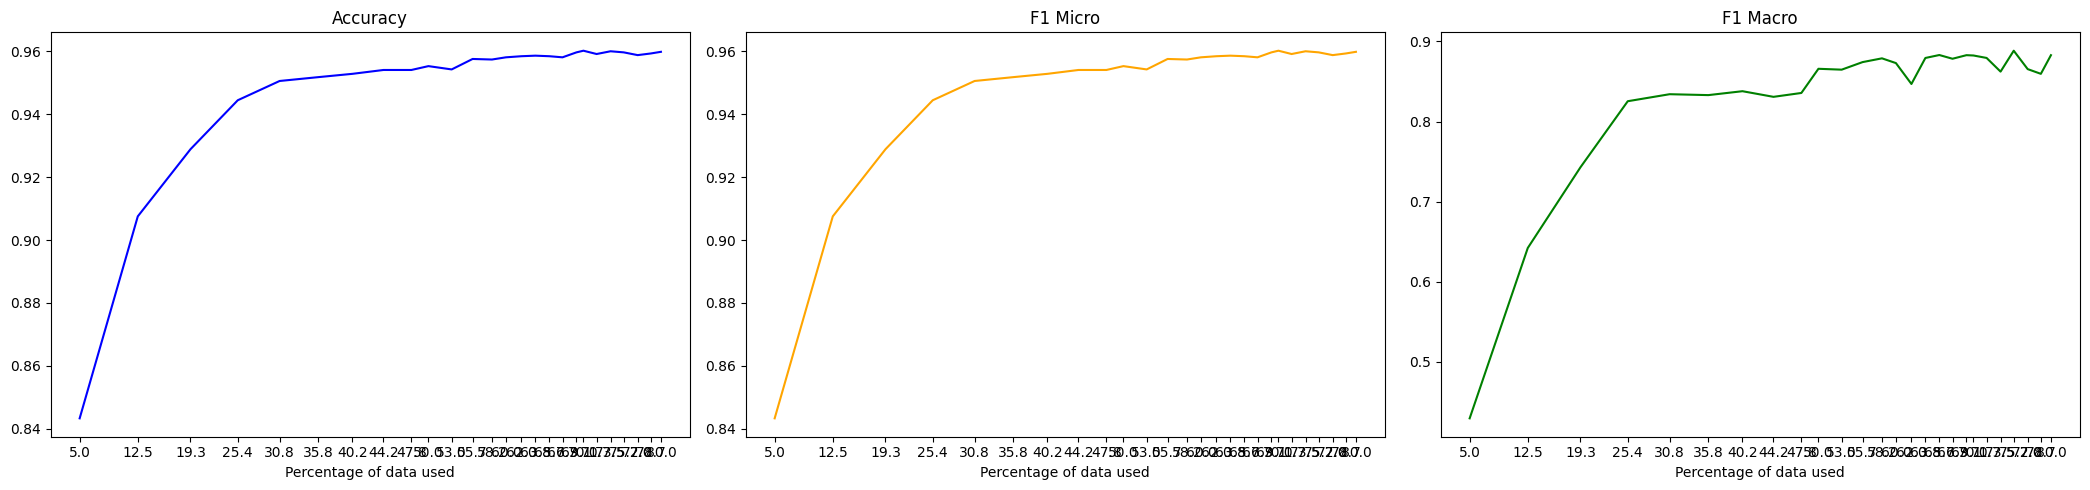

In [26]:
active_learning(seeds[4], 4)